In order to understand the interactions between neurons through volume transmission, we look at the distances between their dendrites within 5 microns. This program does the following:
(1) displays the minimum distance between a given pair of neurons
(2) displays the number of dendrodendritic interactions that exists between a pair of neurons within 5 microns
(3) displays the coordinates of where those interactions occur

In [14]:
import numpy as np
import pandas as pd
from meshparty import meshwork, trimesh_vtk
from tqdm.auto import tqdm
import glob # Glob lets you do shell-like file lists in python

In [15]:
# skel_dir = 'data'
skel_dir = "C:\\Users\\hoda.aboueich\\Skeleton\\inhibitory_skeletons" # data file
# The files in the directory `data` contain skeletons of all of the basket cells in a central column of primary visual cortex.

files = glob.glob(f"{skel_dir}/*.h5") 
# This command loads a neuron file into python
# The number is the so-called `root id` of a given cell at a given state of proofreading, and the suffix `.h5` indicates that it's an "hdf5" file, which is a generic file format that can hold all sorts of data. In this case, these h5 files are formatted as a "meshwork" object, which holds information about the morphology and connectivity of neurons.

In [18]:
# Define constants
NUMFILES = int(164) # This is the number of neuron files
SUM1TONUMFILES = int(NUMFILES*(NUMFILES-1)/2) # This is the sum of numbers of 1 and the number of files; this represents the number of unique dendrodendritic interactions
NUMCOLUMNS = int(10) # This is the number of data columns output by the program
NUMROWS = SUM1TONUMFILES

r, c = NUMCOLUMNS, NUMROWS
r1, c1 = 7, SUM1TONUMFILES
r2, c2 = 5, SUM1TONUMFILES
r3, c3 = 6, 371199 # c3 is the number of coordinates that exist within 5 microns
DataMatrix = [[0 for x in range(r)] for y in range(c)] # Table with Nrn 1, Nrn 2, # Vertices, # Vertices w/o axons, Min Distance, Index Value, Seg ID Nrn 1, Seg ID Nrn 2, Coordinates, # Interactions < 5 Microns
dist_data = [[0 for x in range(r1)] for y in range(c1)] # Table with Neuron 1, Neuron 2, # of interactions: 0-1, 1-2, 2-3, 3-4, 4-5
dist_data1 = [[0 for x in range(r2)] for y in range(c2)] # Table with # of interactions: 0-1, 1-2, 2-3, 3-4, 4-5; used to plot swarm plot
DataMatrix1 = [[0 for x in range(r3)] for y in range(c3)]  # Table with Neuron 1, Neuron 2, Distance, Seg ID Nrn 1, Seg ID Nrn 2, Coordinates

print("NUMFILES = ", NUMFILES, " SUM1TONUMFILES = ", SUM1TONUMFILES, " NUMCOLUMNS = ", NUMCOLUMNS, " NUMROWS = ", NUMROWS)

NUMFILES =  164  SUM1TONUMFILES =  13366  NUMCOLUMNS =  10  NUMROWS =  13366


The following code includes 3 arrays: 
(1) DataMatrix contains the individual neuron-to-neuron interaction with only the minimum distances between the dendrites 
(2) dist_data contains the number of individual neuron-to-neuron interaction with distances less than 5 microns within different ranges (i.e. 0-1, 1-2, 2-3, 3-4, 4-5)
(3) DataMatrix1 contains the individual neuron-to-neuron interactions with ALL distances less than 5 microns AND the coordinates where those interactions occur 

Each array is populated with data in a while loop, and then converted to a dataframe and feather file for further processing. 
This may take some time to run depending on the number of neuron data files on hand.

In [19]:
q = 0 # DataMatrix1 Index, total number of coordinates within 5 microns
z = 0 # Row number
j = 0 # Nrn 1, column 0
while j < NUMFILES-1:
    DataMatrix[z][0] = j # DataMatrix column 0, returns Nrn 1

    nrn = meshwork.load_meshwork(files[j])

# Since we are interested in dendrite-dendrite interactions, the first thing we want to do is limit our analysis to dendrites.
# To show you how this goes, we're going to plot the cell along the way. We've been using vtk as a quick way to plot cells in 3d.

# The following two lines of code will bring up a 3d plot of the neuron, with the dendrite in red and the axon in blue.
# You'll have to close the window to continue.

    ###ska = trimesh_vtk.skeleton_actor(
       ### nrn.skeleton, line_width=2, vertex_data=nrn.anno.is_axon.skel_mask
    ###)

    ###trimesh_vtk.render_actors([ska])

# You can see all of the vertices of the object like so:

    nrn.skeleton.vertices

# How many vertices are there?

### len(nrn.skeleton.vertices)

    DataMatrix[z][2] = len(nrn.skeleton.vertices) 

    nlength = DataMatrix[z][2] # DataMatrix column 2, returns the number of vertices on Nrn 1

# But now we want to mask out the axon and leave only the dendrite.
# When I made these skeletons to begin with, I already labeled the axon and dendrite (which is how we did the colors before), so we can just use that.
# However, these objects contain both skeletons (which are trees) and "meshes", which are somewhat more fleshed out.
# In this case, these aren't true meshes, but they still capture a bit more structure of the cells.

# Meshwork objects have meshes, skeletons, and annotations ( like axon/dendrite labels or like synapses) that are all linked together into a core object.
# One key operation is masking, which limits an object to a given subset.
# The function `apply_mask` takes a boolean array on the mesh, which we can get similar to the colors above.

    nrn.apply_mask(~nrn.anno.is_axon.mesh_mask)

# After applying a mask, you can see the effect by plotting the object again.

    ###ska = trimesh_vtk.skeleton_actor(
        ###nrn.skeleton, line_width=2, vertex_data=nrn.anno.is_axon.skel_mask.astype(int)
    ###)

    ###trimesh_vtk.render_actors([ska])

# This time, you should see just a red part, and the skeleton will be much smaller.
# You can reset the mask to the original state with `nrn.reset_mask()`
# Now how many vertices are there?

    DataMatrix[z][3] = len(nrn.skeleton.vertices) 

    nlength2 = DataMatrix[z][3] # DataMatrix column 3, displays number of vertices without axons on Nrn 1

# How do we measure the distance between dendrites?
# As a first approximation, we can measure the closest distances between the dendrite vertices.
# Scipy has an object called a K-d tree that does this very efficiently.
# Let's use it here.
# We're going to use the mesh vertices instead of the skeleton vertices to get a slightly richer representation.

    i = j + 1 # Nrn 2, column 1
    while i < NUMFILES:
        print("i = ", i, " z = ", z)
        nrn_other = meshwork.load_meshwork(files[i])
        nrn_other.apply_mask(~nrn_other.anno.is_axon.mesh_mask)

        DataMatrix[z][0] = j # DataMatrix column 0, returns Nrn 1
        DataMatrix[z][1] = i # DataMatrix column 1, returns Nrn 2, i.e. the neuron 'Nrn 1' is being compared to
        DataMatrix[z][2] = nlength # DataMatrix column 2, returns the number of vertices on Nrn 1
        DataMatrix[z][3] = nlength2 # DataMatrix column 3, returns number of vertices without axons on Nrn 1
        # i += 1

        from scipy import spatial

        kdt = spatial.KDTree(nrn_other.mesh.vertices)
        ds, inds = kdt.query(
        nrn.mesh.vertices)  # This returns the distance and closest index in the tree object for each of the vertices queried.
        print("Distance = ", ds)

        # Count the number of distances/interactions less than 5 microns
        NUMDIST = len(ds)
        # print("NUMDIST = ", NUMDIST)
        h = 0
        count0_1 = 0
        count1_2 = 0
        count2_3 = 0
        count3_4 = 0
        count4_5 = 0
        dist_less_than_5 = 0 # This returns the total number of interactions between a given pair of neurons within 5 microns
        while h < NUMDIST:
            # print("ds array row ",  h , " = " , ds[h])
            l = ds[h]/1000
            if l >= 0 and l <= 5:
                DataMatrix1[q][0] = j # DataMatrix1 column 0, returns Nrn 1
                DataMatrix1[q][1] = i # DataMatrix1 column 1, returns Nrn 2
                DataMatrix1[q][2] = l # DataMatrix1 column 2, returns all distances (in microns) within 5 microns 
                DataMatrix1[q][3] = nrn.seg_id # DataMatrix1 column 3, returns seg ID of Nrn 1, can be used to display neurons in Neuroglancer
                DataMatrix1[q][4] = nrn_other.seg_id # DataMatrix1 column 4, returns seg ID of Nrn 2, can be used to display neurons in Neuroglancer
                DataMatrix1[q][5] = nrn.mesh.vertices[h] / [4, 4, 40] # DataMatrix1 column 5, returns the coordinates of all interactions within 5 microns
                # print(DataMatrix1[q][5], "q = ", q) # This prints all the coordinates of interactions within 5 microns

                q += 1
            if l > 0 and l <= 1:
                dist_less_than_5 += 1
                count0_1 += 1
            elif l <= 2:
                dist_less_than_5 += 1
                count1_2 += 1
            elif l <= 3:
                dist_less_than_5 += 1
                count2_3 += 1
            elif l <= 4:
                dist_less_than_5 += 1
                count3_4 += 1
            elif l <= 5:
                dist_less_than_5 += 1
                count4_5 += 1
            h += 1
        dist_data[z][0] = j
        dist_data[z][1] = i
        dist_data[z][2] = count0_1
        dist_data[z][3] = count1_2
        dist_data[z][4] = count2_3
        dist_data[z][5] = count3_4
        dist_data[z][6] = count4_5
        print("There are ", dist_less_than_5, " interactions between ", i, " and ", j)

# What is the closest distance between the two dendrites?

        # The vertex units are in nanometers, so let's divide by 1000 to bring into microns
        DataMatrix[z][4] = (np.min(ds) / 1000) # DataMatrix column 4, returns the minimum distance between a pair of neuron's dendrites. 

        DataMatrix[z][5] = np.argmin(ds)  # DataMatrix column 5, returns the index of the minimum value along an axis

        DataMatrix[z][6] = nrn.seg_id # DataMatrix column 6, returns the seg ID of Nrn 1

        DataMatrix[z][7] = nrn_other.seg_id # DataMatrix column 7, returns the seg ID of Nrn 2

        DataMatrix[z][8] = nrn.mesh.vertices[np.argmin(ds)] / [4, 4, 40] # DataMatrix column 8, returns the coordinates of the minimum distance between two dendrites

        DataMatrix[z][9] = dist_less_than_5 # DataMatrix column 9, returns the number of interactions within 5 microns between a given pair of neurons

        i += 1
        z += 1
    j += 1


i =  1  z =  0
Distance =  [35293.9645832  35823.65698809 35459.12621597 ... 60899.24794281
 64770.78551322 64118.47933318]
There are  37  interactions between  1  and  0
i =  2  z =  1
Distance =  [448463.58507241 448406.53418968 447979.05701048 ... 289692.78303748
 289721.06706969 289328.48199927]
There are  0  interactions between  2  and  0
i =  3  z =  2
Distance =  [446253.62166374 446284.15593655 445890.53200085 ... 303455.14404604
 305581.32696878 305324.05656941]
There are  0  interactions between  3  and  0
i =  4  z =  3
Distance =  [556921.21674793 556904.45669612 556381.07717643 ... 400136.06605754
 399978.05203786 399372.86758116]
There are  0  interactions between  4  and  0
i =  5  z =  4
Distance =  [68101.50588643 68057.34852314 67549.70578766 ... 26598.12925752
 28631.56635603 29654.23032216]
There are  18  interactions between  5  and  0
i =  6  z =  5
Distance =  [163958.87679537 163164.51535797 162496.8294583  ...  43092.25452445
  46720.47260035  47038.00676049]


Distance =  [316187.67591416 316218.4528961  315761.58013286 ... 193303.31150811
 193821.07212581 193558.34824672]
There are  0  interactions between  48  and  0
i =  49  z =  48
Distance =  [280632.90333102 280870.79506421 280624.50139644 ... 141192.15252981
 144475.77291712 144719.97147595]
There are  0  interactions between  49  and  0
i =  50  z =  49
Distance =  [144385.01861343 143647.89529958 143012.05946353 ...  24299.93646082
  19792.03395308  18845.52275741]
There are  0  interactions between  50  and  0
i =  51  z =  50
Distance =  [66458.14032908 65821.04708982 65319.26760153 ... 37406.72538461
 37921.45566826 37193.20454061]
There are  39  interactions between  51  and  0
i =  52  z =  51
Distance =  [ 44627.31647769  43655.80208861  42936.3950047  ... 112144.97188907
 114572.32475602 114112.98737655]
There are  17  interactions between  52  and  0
i =  53  z =  52
Distance =  [485802.16226773 485711.75840821 485223.09359716 ... 320102.97593118
 320737.8635085  320320.2667

Exception ignored in: <function ZipFile.__del__ at 0x000001C1A0D4B280>
Traceback (most recent call last):
  File "C:\Users\hoda.aboueich\Anaconda3\envs\snakes\lib\zipfile.py", line 1816, in __del__
    self.close()
  File "C:\Users\hoda.aboueich\Anaconda3\envs\snakes\lib\zipfile.py", line 1833, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


Distance =  [270761.84428387 270855.96609268 270350.89518624 ... 153118.74315054
 152614.77590325 151879.06325758]
There are  0  interactions between  64  and  0
i =  65  z =  64
Distance =  [353850.97437198 353577.98456352 352977.05788337 ... 177243.15375213
 176923.71599082 176302.26952595]
There are  0  interactions between  65  and  0
i =  66  z =  65
Distance =  [92258.08287624 92680.961238   92550.13568872 ... 65566.44263646
 67671.66946367 67416.54159032]
There are  0  interactions between  66  and  0
i =  67  z =  66
Distance =  [454836.47044625 454835.29298417 454464.65631554 ... 298559.29796273
 298196.18959336 297839.60085925]
There are  0  interactions between  67  and  0
i =  68  z =  67
Distance =  [157322.11806355 157321.18687577 156715.88274326 ...  62896.36682671
  63102.3336494   62422.4749269 ]
There are  7  interactions between  68  and  0
i =  69  z =  68
Distance =  [252783.50857601 252866.55655503 252376.62649303 ... 136442.55992908
 135391.62585625 134462.643734

Distance =  [350383.53367703 350146.68377696 349657.70745688 ... 177235.58324445
 178845.77042804 178608.54160986]
There are  0  interactions between  110  and  0
i =  111  z =  110
Distance =  [493834.3550625  494010.33919545 493607.69400811 ... 328474.70633825
 329977.5988518  329827.55251798]
There are  0  interactions between  111  and  0
i =  112  z =  111
Distance =  [23145.896915   22347.11614504 21652.96173737 ... 34389.16108311
 36633.35223536 36799.6739116 ]
There are  58  interactions between  112  and  0
i =  113  z =  112
Distance =  [414460.66969014 414760.94566388 414419.70841165 ... 257655.78998346
 256940.57523093 256272.64743628]
There are  0  interactions between  113  and  0
i =  114  z =  113
Distance =  [433561.71712918 433352.96800645 432816.75871435 ... 255645.28500248
 255897.51761203 255467.04235185]
There are  0  interactions between  114  and  0
i =  115  z =  114
Distance =  [429872.99877057 430216.76880382 429973.69646061 ... 308517.63764168
 310450.384776

Distance =  [305786.22660937 305852.40885107 305321.75479648 ... 138349.93822912
 139655.45603377 139205.43874432]
There are  0  interactions between  156  and  0
i =  157  z =  156
Distance =  [604471.44160167 604436.52331738 604017.66390065 ... 442037.60730508
 443130.8767757  442855.55525024]
There are  0  interactions between  157  and  0
i =  158  z =  157
Distance =  [368615.37955978 368399.79239951 367891.65378954 ... 196457.03155652
 197756.28685834 197446.45127224]
There are  0  interactions between  158  and  0
i =  159  z =  158
Distance =  [130948.73965029 131049.29612936 130814.2693134  ...  26835.7516757
  28464.25294997  28542.08177411]
There are  0  interactions between  159  and  0
i =  160  z =  159
Distance =  [214752.05647444 215021.6344836  214642.63121757 ...  87701.54224414
  91324.66216746  91032.06503205]
There are  5  interactions between  160  and  0
i =  161  z =  160
Distance =  [223371.50872929 223290.22018888 222800.29314164 ... 119326.02975043
 122936.39

Distance =  [ 8268.19254735  8102.79951622  7781.5165617  ... 82592.35218832
 83064.63873394 83471.43223882]
There are  79  interactions between  41  and  1
i =  42  z =  203
Distance =  [ 5101.30336287  4782.45459989  6090.70110907 ... 70370.95446276
 70216.92787355 70183.25954243]
There are  105  interactions between  42  and  1
i =  43  z =  204
Distance =  [60989.2087504  60694.23484978 61681.58493424 ... 76321.45491276
 75665.1697943  75563.5645533 ]
There are  97  interactions between  43  and  1
i =  44  z =  205
Distance =  [ 73426.34862228  73153.59578312  73131.05124364 ... 137626.44955095
 137880.80324686 138512.72218825]
There are  6  interactions between  44  and  1
i =  45  z =  206
Distance =  [98804.34257663 98989.62499171 96896.75131809 ... 43416.05601618
 42630.22251877 42471.60218311]
There are  66  interactions between  45  and  1
i =  46  z =  207
Distance =  [19905.75072686 19982.67089255 21074.15326887 ... 37784.05504972
 38360.39624404 38661.87041518]
There are 

Distance =  [ 36552.98138319  36803.64764531  34763.61960441 ... 154919.70648049
 155489.36694192 156305.55470616]
There are  0  interactions between  87  and  1
i =  88  z =  249
Distance =  [162774.06948283 162716.26308393 161534.1549023  ... 172588.08876629
 172672.08691621 173173.46106145]
There are  0  interactions between  88  and  1
i =  89  z =  250
Distance =  [27559.19998839 27713.89947301 26555.75267244 ...  2743.90670395
  4078.10936587  5107.20275689]
There are  188  interactions between  89  and  1
i =  90  z =  251
Distance =  [515524.52151959 515203.3799268  515789.0332762  ... 514949.79197588
 514451.66651883 514547.21109729]
There are  0  interactions between  90  and  1
i =  91  z =  252
Distance =  [27296.24736113 27340.82368913 25687.42073467 ... 77030.91202887
 77268.19868484 77831.11562865]
There are  502  interactions between  91  and  1
i =  92  z =  253
Distance =  [ 30487.94122272  30649.99314845  28452.37086782 ... 160305.86704173
 160577.80568933 160828.640

Distance =  [436629.39180958 436391.18847199 436199.79524984 ... 442334.91253574
 442353.92902969 442836.35406321]
There are  0  interactions between  133  and  1
i =  134  z =  295
Distance =  [219022.51193884 218677.9257264  219386.23738056 ... 301577.05132851
 301710.00508435 302270.07949845]
There are  0  interactions between  134  and  1
i =  135  z =  296
Distance =  [295621.32513065 295430.25155864 295192.56847014 ... 316443.65494034
 316429.69165361 316893.35008485]
There are  0  interactions between  135  and  1
i =  136  z =  297
Distance =  [149878.91112495 149659.69418651 149745.21080823 ... 242129.72192608
 241814.11796667 242065.65390406]
There are  0  interactions between  136  and  1
i =  137  z =  298
Distance =  [246925.32960391 246787.02967539 246006.67425092 ... 242497.46660945
 242459.34455079 242908.30691436]
There are  0  interactions between  137  and  1
i =  138  z =  299
Distance =  [ 83038.78765974  82733.86460211  83490.42579841 ... 140950.38378096
 140822.0

Distance =  [49251.99723869 48578.50520549 48068.53440662 ... 17350.91375115
 15002.39127606 14734.69483905]
There are  40  interactions between  18  and  2
i =  19  z =  341
Distance =  [450672.39507207 452228.20285338 453146.55423604 ... 419970.35575383
 418679.88321389 419039.02665026]
There are  0  interactions between  19  and  2
i =  20  z =  342
Distance =  [417457.86822624 419034.48908175 419940.08098299 ... 356883.88780666
 355343.77063345 355714.24360573]
There are  0  interactions between  20  and  2
i =  21  z =  343
Distance =  [271141.15113719 272601.75471189 273347.37541817 ... 115769.03185222
 114112.31463782 114435.12327952]
There are  0  interactions between  21  and  2
i =  22  z =  344
Distance =  [134769.97267938 136145.05088324 136790.50516757 ... 154511.68789448
 155383.16140432 155594.31681138]
There are  0  interactions between  22  and  2
i =  23  z =  345
Distance =  [65287.8843278  65464.35243703 65107.90354481 ... 73159.46637312
 75698.3635226  75948.213935

Distance =  [55912.46014977 57260.42682342 58281.8915273  ... 36643.5325808
 37660.12639384 37919.48522857]
There are  0  interactions between  64  and  2
i =  65  z =  387
Distance =  [131456.59396166 132379.32285671 132850.11367703 ...  13369.89573632
  15738.60273341  15442.28376892]
There are  9  interactions between  65  and  2
i =  66  z =  388
Distance =  [227230.97324089 228645.86276598 229324.47161173 ... 178105.08502567
 177274.69125625 177709.2872756 ]
There are  0  interactions between  66  and  2
i =  67  z =  389
Distance =  [106734.59510393 107292.21854356 107203.0378674  ...  27661.9895163
  30565.22887204  30347.69183974]
There are  75  interactions between  67  and  2
i =  68  z =  390
Distance =  [117040.80546544 117807.62216427 117933.96308104 ... 157584.631738
 156603.53099467 156809.69357792]
There are  0  interactions between  68  and  2
i =  69  z =  391
Distance =  [ 91805.74413401  93379.55133754  94601.35914457 ... 106902.47069175
 108835.89113891 108665.9865

Distance =  [23578.28153195 22676.11677514 21745.03161644 ... 50216.3702392
 52683.04987375 52913.56816545]
There are  114  interactions between  110  and  2
i =  111  z =  433
Distance =  [ 7104.18468228  6803.54731004  7043.58999375 ... 83940.23816978
 85712.18779147 85603.58048587]
There are  93  interactions between  111  and  2
i =  112  z =  434
Distance =  [401210.04477954 402726.76076963 403563.22916738 ... 345603.10396754
 343640.1016878  343943.71297641]
There are  0  interactions between  112  and  2
i =  113  z =  435
Distance =  [56502.68892717 57825.94407357 58720.48664648 ... 95853.57032474
 96235.03295578 96277.34105178]
There are  114  interactions between  113  and  2
i =  114  z =  436
Distance =  [25607.89003413 27242.49621455 28292.65798754 ... 74443.86019008
 76340.18056044 76394.83040102]
There are  163  interactions between  114  and  2
i =  115  z =  437
Distance =  [56392.51127588 55232.86499902 54337.08420591 ... 34387.27020279
 37295.22950727 37233.81259017]

Distance =  [192789.94662585 194050.72376057 194577.69935941 ...  79278.260324
  79355.14098028  79574.28529368]
There are  0  interactions between  156  and  2
i =  157  z =  479
Distance =  [130945.85531432 130399.93006133 129634.0051684  ... 172275.47985712
 175192.17699429 175301.987667  ]
There are  0  interactions between  157  and  2
i =  158  z =  480
Distance =  [52635.06542221 53431.54424121 54429.08869346 ... 29343.65757706
 31134.01226954 31113.03263907]
There are  57  interactions between  158  and  2
i =  159  z =  481
Distance =  [228706.18020508 230074.33386625 230702.72237666 ... 202885.75543887
 203048.55238095 203444.67615546]
There are  0  interactions between  159  and  2
i =  160  z =  482
Distance =  [143822.32638919 145221.26323648 145896.44656399 ...  84560.51239201
  85456.78861273  85844.21723098]
There are  43  interactions between  160  and  2
i =  161  z =  483
Distance =  [118783.12311099 119717.21934626 120190.41372755 ...  28253.29092336
  26613.8466216

Distance =  [479058.12056576 477003.76531847 478735.85060657 ... 529979.20695816
 530007.39605406 530069.84034936]
There are  0  interactions between  42  and  3
i =  43  z =  525
Distance =  [376172.35156242 373892.00314529 375775.9211445  ... 455803.41874979
 455804.86442336 455885.40707507]
There are  0  interactions between  43  and  3
i =  44  z =  526
Distance =  [276826.14362087 274167.34918659 276347.92586158 ... 363216.45504575
 363379.45425684 363341.20550249]
There are  0  interactions between  44  and  3
i =  45  z =  527
Distance =  [540601.46888443 538094.81977808 540158.27967736 ... 551226.69224195
 551206.71212169 551301.8715731 ]
There are  0  interactions between  45  and  3
i =  46  z =  528
Distance =  [595228.20943904 593514.01177731 594984.17619295 ... 632558.27560154
 632524.69262788 632629.22438977]
There are  0  interactions between  46  and  3
i =  47  z =  529
Distance =  [329302.95294151 327376.62127892 329020.23777269 ... 371028.30330852
 371159.93395839 37

Distance =  [353347.45415809 350198.27736869 352726.59426814 ... 348035.48416792
 348073.87739961 348127.92361429]
There are  0  interactions between  88  and  3
i =  89  z =  571
Distance =  [603168.66921285 600736.91205385 602735.26803067 ... 608997.07091578
 608932.0815986  609057.48279124]
There are  0  interactions between  89  and  3
i =  90  z =  572
Distance =  [79619.48304278 80399.80338284 79870.22554119 ... 76573.5908522
 76698.99816816 76639.70521864]
There are  32  interactions between  90  and  3
i =  91  z =  573
Distance =  [555713.75428722 553598.61693469 555374.77882958 ... 600691.17917279
 600659.87873338 600762.58040594]
There are  0  interactions between  91  and  3
i =  92  z =  574
Distance =  [380683.06582773 378537.47633755 380340.81844577 ... 524852.61461862
 524989.35675307 524972.88115864]
There are  0  interactions between  92  and  3
i =  93  z =  575
Distance =  [422981.39049372 420306.48033072 422497.47458654 ... 473802.30186017
 473889.56033236 473910.0

Distance =  [186745.14140936 184593.76024124 186406.98956852 ... 337644.15692264
 337893.97532362 337789.40667818]
There are  0  interactions between  134  and  3
i =  135  z =  617
Distance =  [227977.49811769 224730.04975748 227325.23942581 ... 237722.24962759
 237867.00916268 237845.45597509]
There are  46  interactions between  135  and  3
i =  136  z =  618
Distance =  [203717.89451101 200335.27369887 203019.79694601 ... 386070.95331299
 386367.59756481 386226.39147526]
There are  0  interactions between  136  and  3
i =  137  z =  619
Distance =  [223966.93584545 220473.70586081 223232.19051024 ... 127995.00115239
 128072.72958753 128095.95653259]
There are  48  interactions between  137  and  3
i =  138  z =  620
Distance =  [311611.87694952 309062.82908173 311166.33452866 ... 399334.98206894
 399438.98401633 399445.25700526]
There are  0  interactions between  138  and  3
i =  139  z =  621
Distance =  [274574.6433158  272129.73811769 274157.44218241 ... 355926.55655907
 355975

Distance =  [218473.2578967  215593.14126382 217276.48789503 ... 247384.60045848
 247469.26965585 246127.06207973]
There are  0  interactions between  22  and  4
i =  23  z =  664
Distance =  [109548.57362832 107279.05532768 108796.7381864  ...  37838.07606103
  38203.98387603  33468.68243597]
There are  0  interactions between  23  and  4
i =  24  z =  665
Distance =  [299048.18169653 296530.59773319 297888.56257332 ... 214119.11600789
 214437.12186093 211510.95790053]
There are  0  interactions between  24  and  4
i =  25  z =  666
Distance =  [432095.12952589 430353.98125729 431351.98375341 ... 431150.19749503
 431552.29348944 428429.51420274]
There are  0  interactions between  25  and  4
i =  26  z =  667
Distance =  [250079.17453479 247963.5531928  249199.96699839 ... 189700.52710522
 189846.14317915 188195.68267099]
There are  0  interactions between  26  and  4
i =  27  z =  668
Distance =  [86610.2142706  83300.01911164 85501.65378518 ... 81548.15097843
 81055.43189694 81249.9

Distance =  [181915.49686599 178946.04058207 180629.96500027 ... 230285.36328651
 230248.29241495 229225.55920316]
There are  0  interactions between  68  and  4
i =  69  z =  710
Distance =  [185803.29383517 184488.05272971 184758.09013951 ... 174333.17380235
 174460.7169537  171315.55614129]
There are  0  interactions between  69  and  4
i =  70  z =  711
Distance =  [92904.30345253 91102.9957795  92438.74996991 ... 36270.64929113
 36733.23073186 36599.98688524]
There are  8  interactions between  70  and  4
i =  71  z =  712
Distance =  [256502.9409578  254396.98652303 255651.61769877 ... 172611.92468656
 172887.76474927 170862.94840017]
There are  0  interactions between  71  and  4
i =  72  z =  713
Distance =  [518655.2361791  518046.27901376 518219.27331198 ... 500160.95796453
 500643.84651766 497285.81167775]
There are  0  interactions between  72  and  4
i =  73  z =  714
Distance =  [153936.93919264 151379.89911478 152960.22384921 ... 151903.22919543
 152339.68045129 149499.4

Distance =  [113480.33951306 111764.95393459 112550.31116794 ... 155504.65665053
 155632.853087   155220.11044965]
There are  20  interactions between  114  and  4
i =  115  z =  756
Distance =  [66376.99938985 65403.80857412 66056.40741064 ... 65265.02279169
 65728.0516066  61095.01321712]
There are  10  interactions between  115  and  4
i =  116  z =  757
Distance =  [455997.89388987 454042.24980502 455098.340142   ... 470855.42062931
 471229.56416592 468288.97041037]
There are  0  interactions between  116  and  4
i =  117  z =  758
Distance =  [121071.79886332 119458.64127806 121145.85747767 ...  10522.07127898
  10703.13299927  12852.24836361]
There are  32  interactions between  117  and  4
i =  118  z =  759
Distance =  [158332.08746176 155090.05631568 157288.9203981  ... 142436.71144758
 142474.86683622 142136.79000174]
There are  22  interactions between  118  and  4
i =  119  z =  760
Distance =  [337132.32004066 335514.06394367 336243.40231445 ... 383762.45877886
 384123.645

Distance =  [228834.59402809 226355.14311807 227654.63527018 ... 203399.3769902
 203565.42684847 201600.1888888 ]
There are  0  interactions between  160  and  4
i =  161  z =  802
Distance =  [192620.63108608 190046.2579479  191225.01476533 ... 114477.18515058
 114572.40044618 114176.29175972]
There are  0  interactions between  161  and  4
i =  162  z =  803
Distance =  [367150.01428844 364732.73502662 366146.86758185 ... 348332.43762819
 348711.36029674 345689.11897252]
There are  0  interactions between  162  and  4
i =  163  z =  804
Distance =  [357853.38655936 356747.36087041 357058.81375482 ... 372276.85740588
 372641.43898391 369272.37773763]
There are  0  interactions between  163  and  4
i =  6  z =  805
Distance =  [93307.67685459 93650.78622201 92199.30064811 ... 47408.13904806
 47324.42244761 48140.90651411]
There are  70  interactions between  6  and  5
i =  7  z =  806
Distance =  [176644.59432431 177189.7396578  175878.35850951 ... 101150.29229814
 101554.82491738 1035

Distance =  [204756.12311235 205090.00935199 205052.26120187 ... 213769.61939434
 213293.61816988 211848.29757163]
There are  20  interactions between  48  and  5
i =  49  z =  848
Distance =  [179695.17406987 179515.57213791 179159.72726034 ... 154981.49525669
 154242.67653279 152080.60389149]
There are  0  interactions between  49  and  5
i =  50  z =  849
Distance =  [136723.37152075 137653.40196305 136995.31437243 ...  48105.12621333
  48197.98170048  49215.75682645]
There are  37  interactions between  50  and  5
i =  51  z =  850
Distance =  [117587.71418818 117934.5396735  116416.50082355 ...  43080.7576535
  43849.01367192  46211.51579423]
There are  87  interactions between  51  and  5
i =  52  z =  851
Distance =  [ 81723.82487378  82286.02797559  81031.36182985 ... 110512.79976546
 110671.90429373 111790.72619855]
There are  170  interactions between  52  and  5
i =  53  z =  852
Distance =  [376681.40290702 376931.86864472 376980.94347593 ... 340340.26615727
 339751.9032706

Distance =  [ 90716.65778676  91533.24694339  90980.92459411 ... 112066.36776482
 111609.53794367 111190.57514016]
There are  20  interactions between  94  and  5
i =  95  z =  894
Distance =  [335963.87586763 335863.29380866 337035.30886837 ... 301461.11826237
 301177.24620562 300328.12743398]
There are  0  interactions between  95  and  5
i =  96  z =  895
Distance =  [197717.79047926 198256.8588473  196939.43466965 ...  96421.55476863
  96282.9609848   96942.52812878]
There are  36  interactions between  96  and  5
i =  97  z =  896
Distance =  [145106.18368629 145542.48314496 145694.14406901 ... 176018.31995562
 175590.43800845 175019.51415771]
There are  20  interactions between  97  and  5
i =  98  z =  897
Distance =  [ 99471.40968138  99716.60997046  99533.5768874  ... 153866.22366199
 153542.44713433 153577.91445387]
There are  39  interactions between  98  and  5
i =  99  z =  898
Distance =  [312908.92599605 313112.55228751 312767.30192269 ... 237548.08793169
 236956.4618236

Distance =  [284983.02265223 285234.15548633 285696.56574765 ... 289009.40718253
 288553.6014816  287233.02149997]
There are  0  interactions between  141  and  5
i =  142  z =  941
Distance =  [147343.21076996 147530.84038261 146178.53193954 ... 154838.94207854
 154261.64101292 153221.56673262]
There are  110  interactions between  142  and  5
i =  143  z =  942
Distance =  [291041.20890348 291251.35865778 291487.29838537 ... 295556.48437481
 295156.13256716 294181.52393378]
There are  0  interactions between  143  and  5
i =  144  z =  943
Distance =  [175638.17370948 175800.95089618 174652.64727453 ... 128996.67294934
 128399.81208709 127434.08021405]
There are  63  interactions between  144  and  5
i =  145  z =  944
Distance =  [231676.00811478 231894.42080395 232206.47928945 ... 171138.88123977
 170617.23054838 169602.80771261]
There are  0  interactions between  145  and  5
i =  146  z =  945
Distance =  [262212.99836583 262459.40900642 263081.37618615 ... 247717.96272374
 24720

Distance =  [24356.99817301 24663.51475358 25671.22716194 ... 24641.46619014
 21824.45307448 22575.68249245]
There are  78  interactions between  30  and  6
i =  31  z =  987
Distance =  [281830.28969932 281463.31148482 280136.54670535 ... 355338.23049033
 352610.91613278 358864.49739142]
There are  0  interactions between  31  and  6
i =  32  z =  988
Distance =  [135470.68429738 135532.71345325 135919.10582402 ... 159630.60157752
 160391.68936076 162943.06932177]
There are  10  interactions between  32  and  6
i =  33  z =  989
Distance =  [169923.9187872  169663.74839664 168790.40351868 ... 188924.23810618
 187820.89408796 193606.00403913]
There are  0  interactions between  33  and  6
i =  34  z =  990
Distance =  [101066.97407165 100785.0214268   99589.07281424 ...  87622.92850618
  85993.03971834  92056.66081278]
There are  0  interactions between  34  and  6
i =  35  z =  991
Distance =  [209683.72755176 209368.95999169 208413.38152815 ... 258930.43686674
 257343.90972393 262938

Distance =  [144083.53577005 143761.67723006 142789.05616328 ... 238166.62523536
 235622.16547685 241874.10146603]
There are  0  interactions between  76  and  6
i =  77  z =  1033
Distance =  [315117.41679571 314768.63691289 313461.91051546 ... 361577.27061307
 358562.07710242 364648.29170037]
There are  0  interactions between  77  and  6
i =  78  z =  1034
Distance =  [201156.4507939  200875.55375406 200122.17500317 ... 273871.77624575
 271449.5362899  277333.07489732]
There are  0  interactions between  78  and  6
i =  79  z =  1035
Distance =  [ 52534.92126196  52553.0302837   52305.25602652 ... 163123.16818895
 161593.63749851 166820.51020183]
There are  0  interactions between  79  and  6
i =  80  z =  1036
Distance =  [250995.53296423 250637.34642706 249419.92298932 ... 339371.72426706
 335994.9071995  341959.95002924]
There are  0  interactions between  80  and  6
i =  81  z =  1037
Distance =  [66057.6819454  66203.93317621 67141.52598802 ... 66245.56546668
 67415.78924851 65

Distance =  [41804.05415746 41617.29025297 40913.21390456 ... 71108.83916926
 67795.92388927 73216.13024464]
There are  128  interactions between  122  and  6
i =  123  z =  1079
Distance =  [ 42612.19130718  42470.51193475  41662.2457388  ... 112528.70097891
 113724.26583628 111981.92425566]
There are  8  interactions between  123  and  6
i =  124  z =  1080
Distance =  [ 89763.06804026  89679.12113753  89584.93766253 ... 175115.19079737
 173879.2861269  178699.97828763]
There are  15  interactions between  124  and  6
i =  125  z =  1081
Distance =  [82941.33753443 82951.72957811 83172.73168533 ... 50645.4455208
 47113.69872977 52134.67176458]
There are  45  interactions between  125  and  6
i =  126  z =  1082
Distance =  [219571.1022152  219255.88207389 218184.32060989 ... 276088.48031021
 273725.92061403 280001.80113706]
There are  0  interactions between  126  and  6
i =  127  z =  1083
Distance =  [362213.21190702 361880.53339189 360840.52801203 ... 470093.38728385
 467881.69020

Distance =  [153121.54252097 152329.04384916 151364.7419976  ... 201973.82864124
 201413.83865067 201829.63397876]
There are  0  interactions between  12  and  7
i =  13  z =  1125
Distance =  [112185.01375852 111348.57355171 110161.84108846 ... 197907.91490994
 197273.46120551 197953.99772674]
There are  0  interactions between  13  and  7
i =  14  z =  1126
Distance =  [ 32401.58020838  32144.48780118  31415.10872176 ... 112215.74876995
 111739.85473411 111822.06837651]
There are  24  interactions between  14  and  7
i =  15  z =  1127
Distance =  [128289.49762159 127420.13078003 126024.67745644 ... 166648.25750064
 166068.78285819 166735.78888769]
There are  0  interactions between  15  and  7
i =  16  z =  1128
Distance =  [377117.83274727 376243.74754672 375582.32137309 ... 397445.04328523
 396890.76340978 397128.32271698]
There are  0  interactions between  16  and  7
i =  17  z =  1129
Distance =  [610962.27141126 610170.82848658 610522.96606762 ... 649997.97493838
 649549.42123

Distance =  [363264.46159238 362372.53026133 361939.39620881 ... 412691.89468173
 412096.19265409 412447.38567725]
There are  0  interactions between  59  and  7
i =  60  z =  1172
Distance =  [337453.40144085 336624.51447273 336929.25557749 ... 374307.33733658
 373736.25575264 374016.73656669]
There are  0  interactions between  60  and  7
i =  61  z =  1173
Distance =  [55367.96994653 55109.56185636 52475.59859592 ... 98118.65143794
 97613.28991485 98346.65285611]
There are  28  interactions between  61  and  7
i =  62  z =  1174
Distance =  [491480.27411077 490693.36673731 490513.39308932 ... 520584.99328352
 520149.69937509 520129.93736565]
There are  0  interactions between  62  and  7
i =  63  z =  1175
Distance =  [136786.10034649 136114.15655985 134146.69677633 ...  87679.65291902
  87081.93401619  87839.91147537]
There are  106  interactions between  63  and  7
i =  64  z =  1176
Distance =  [248003.3936542  247122.00530103 246918.68860821 ... 340290.06102441
 339685.06769654 

Distance =  [480386.53536501 479522.95854943 479353.62305505 ... 519467.36093041
 518921.81200639 519133.69253016]
There are  0  interactions between  106  and  7
i =  107  z =  1219
Distance =  [253554.31474933 252705.92857311 252659.64635454 ... 338805.52203292
 338234.7579537  338557.31993268]
There are  0  interactions between  107  and  7
i =  108  z =  1220
Distance =  [462964.12889121 462097.29150472 461329.69929975 ... 470723.93533365
 470195.70733898 470398.15190113]
There are  0  interactions between  108  and  7
i =  109  z =  1221
Distance =  [107782.36145121 106922.07345539 106170.4088341  ... 229592.77410232
 228973.48136411 229699.47183222]
There are  0  interactions between  109  and  7
i =  110  z =  1222
Distance =  [362412.14964181 361577.74710289 361838.08533652 ... 378911.18993242
 378362.26391119 378608.25913865]
There are  0  interactions between  110  and  7
i =  111  z =  1223
Distance =  [465845.15861818 465032.94362443 465208.43287284 ... 528508.31259309
 527

Distance =  [312372.07660097 311512.49328398 310777.64686669 ... 368774.0035957
 368175.21541788 368591.02105179]
There are  0  interactions between  152  and  7
i =  153  z =  1265
Distance =  [ 58934.62303265  58741.34217057  56258.82472999 ... 149998.60074014
 149488.58096858 150320.21820101]
There are  0  interactions between  153  and  7
i =  154  z =  1266
Distance =  [ 81915.97724498  81728.71221303  79140.37149268 ... 154676.51301992
 154118.30406542 154944.28624509]
There are  0  interactions between  154  and  7
i =  155  z =  1267
Distance =  [509166.22492856 508325.51794298 508511.75187207 ... 541814.61419936
 541287.40686626 541523.49953072]
There are  0  interactions between  155  and  7
i =  156  z =  1268
Distance =  [277078.79947769 276197.36074047 275965.28303394 ... 337576.82801993
 336996.45700215 337313.67782526]
There are  0  interactions between  156  and  7
i =  157  z =  1269
Distance =  [605975.96176746 605126.83433475 604857.45324994 ... 643368.85171727
 6428

Distance =  [453425.39009632 453346.19389601 454007.51007004 ... 419355.81607985
 419636.46064659 419783.96234254]
There are  0  interactions between  43  and  8
i =  44  z =  1311
Distance =  [408824.06778466 408414.50168181 408843.6205299  ... 309292.37357555
 310347.45740863 310596.05849399]
There are  0  interactions between  44  and  8
i =  45  z =  1312
Distance =  [641575.25757778 641377.63578098 641968.51586351 ... 528772.70428796
 529155.69187149 529319.90423939]
There are  0  interactions between  45  and  8
i =  46  z =  1313
Distance =  [689822.30291576 689852.30363608 690567.71270021 ... 610761.31345723
 611137.25096741 611305.79958643]
There are  0  interactions between  46  and  8
i =  47  z =  1314
Distance =  [452519.38230312 452255.83174128 452784.28658247 ... 329004.25169289
 329902.124152   330143.27042664]
There are  0  interactions between  47  and  8
i =  48  z =  1315
Distance =  [264557.75662792 263818.5389695  263955.40083885 ... 214249.1155641
 215104.6978566

Distance =  [687325.6965835  687277.26564466 687955.73169209 ... 596527.31411059
 596766.33497542 596919.73388723]
There are  0  interactions between  89  and  8
i =  90  z =  1357
Distance =  [230381.4645322  229612.99949262 229507.88633073 ...  68941.98836703
  69306.51917388  69439.07510905]
There are  6  interactions between  90  and  8
i =  91  z =  1358
Distance =  [659570.04395288 659448.65693699 660083.76573886 ... 582804.97145443
 583204.70900705 583380.53118012]
There are  0  interactions between  91  and  8
i =  92  z =  1359
Distance =  [496703.24114103 496461.92651602 497015.78167298 ... 467800.18955105
 468835.77372039 469078.80862815]
There are  0  interactions between  92  and  8
i =  93  z =  1360
Distance =  [534310.98420302 533974.49778805 534470.74531727 ... 425824.15014651
 426588.15548489 426802.10301263]
There are  0  interactions between  93  and  8
i =  94  z =  1361
Distance =  [349350.62400975 348628.03733492 348773.52248128 ... 248385.26899959
 249739.099317

Distance =  [342188.83179905 341630.03755525 341949.34698578 ... 197615.66901438
 197924.01402559 198094.00709764]
There are  0  interactions between  135  and  8
i =  136  z =  1403
Distance =  [318902.28371713 318262.8153712  318507.95657252 ... 287698.14559013
 289231.76445197 289503.60329364]
There are  0  interactions between  136  and  8
i =  137  z =  1404
Distance =  [286985.08560551 286929.88043771 287555.91472964 ... 113733.81920959
 113956.07996066 114042.09664856]
There are  4  interactions between  137  and  8
i =  138  z =  1405
Distance =  [433852.37717915 433534.27324723 434042.38001375 ... 360815.10868588
 361683.92981718 361918.10830629]
There are  0  interactions between  138  and  8
i =  139  z =  1406
Distance =  [412054.99182512 411517.66445683 411839.59331759 ... 322842.47918761
 323390.09756021 323585.79291434]
There are  0  interactions between  139  and  8
i =  140  z =  1407
Distance =  [409167.3306998  408776.11405756 409232.52539357 ... 353941.69445263
 355

Distance =  [ 20476.08400061  19739.04151675  19101.7770901  ... 106141.5366009
 105433.45047944 107516.54458733]
There are  251  interactions between  26  and  9
i =  27  z =  1448
Distance =  [122497.43285473 122447.36599862 121945.0215794  ... 255963.53177748
 255438.0219153  256787.49502264]
There are  0  interactions between  27  and  9
i =  28  z =  1449
Distance =  [ 63162.80931054  62787.87908506  61663.222102   ... 165282.90278187
 165041.63993368 166342.6608901 ]
There are  0  interactions between  28  and  9
i =  29  z =  1450
Distance =  [ 12277.4642333   13409.12883076  15033.9455899  ... 218648.70015621
 218148.66241167 219280.08434876]
There are  18  interactions between  29  and  9
i =  30  z =  1451
Distance =  [34363.65987493 33084.1603188  31211.177485   ... 85094.61200335
 84567.53987199 86398.91665987]
There are  199  interactions between  30  and  9
i =  31  z =  1452
Distance =  [ 94546.83664724  93876.72802138  93303.03317685 ... 303094.4919328
 302449.17716535 

Distance =  [250528.3134498  250380.14349385 249865.47740734 ... 132129.87695446
 131763.81755247 133393.12102204]
There are  0  interactions between  72  and  9
i =  73  z =  1494
Distance =  [ 43874.52509145  42844.88114116  40629.73886207 ... 250476.15991946
 249821.71114617 251579.17433683]
There are  26  interactions between  73  and  9
i =  74  z =  1495
Distance =  [42356.37529345 40971.60304406 38755.98658272 ... 67409.81056196
 66699.86122924 68881.5827925 ]
There are  59  interactions between  74  and  9
i =  75  z =  1496
Distance =  [37226.27115358 37378.07357262 37068.80262431 ... 91267.45119702
 90582.4671777  92825.56544401]
There are  78  interactions between  75  and  9
i =  76  z =  1497
Distance =  [ 24907.90717824  25685.21940728  26446.05074487 ... 173521.2697049
 172958.13171979 174341.83507122]
There are  24  interactions between  76  and  9
i =  77  z =  1498
Distance =  [135645.24106654 134306.83675822 132502.90574927 ... 302828.35270166
 302170.75045742 303945

Distance =  [ 97977.42989077  98563.37461755  98857.31908159 ... 190215.65882966
 189631.07492181 191619.64224995]
There are  12  interactions between  119  and  9
i =  120  z =  1541
Distance =  [  7009.88559108   6063.39838704   5692.29654885 ... 166579.30973563
 165936.54652306 167992.05847897]
There are  76  interactions between  120  and  9
i =  121  z =  1542
Distance =  [167674.38635641 167634.48428053 167177.32094994 ... 149659.07047687
 149347.49299536 150787.84799844]
There are  0  interactions between  121  and  9
i =  122  z =  1543
Distance =  [ 83861.75442954  84151.70947759  83973.52535174 ... 113957.84343344
 113528.55499829 115312.29249304]
There are  27  interactions between  122  and  9
i =  123  z =  1544
Distance =  [ 59580.70076795  60220.83944948  61393.79616867 ... 205353.02364465
 204705.64373265 206917.47054321]
There are  2  interactions between  123  and  9
i =  124  z =  1545
Distance =  [ 16280.20835248  15239.82992031  13059.88667638 ... 181150.71506345
 

i =  11  z =  1585
Distance =  [103379.52540034 101888.52418207 100564.70633378 ...  58668.93038057
  59862.63636025  61272.28410954]
There are  14  interactions between  11  and  10
i =  12  z =  1586
Distance =  [82940.60795533 81545.24201938 80154.60061656 ... 37289.23662399
 38427.31195387 39398.68424199]
There are  64  interactions between  12  and  10
i =  13  z =  1587
Distance =  [201340.07291148 200264.24543587 199150.50694387 ... 137287.24223321
 137981.96241538 139411.75365083]
There are  20  interactions between  13  and  10
i =  14  z =  1588
Distance =  [298219.61679273 297927.80967207 297541.10255896 ... 265363.60383444
 265733.0263253  266801.53786663]
There are  0  interactions between  14  and  10
i =  15  z =  1589
Distance =  [281819.47776547 280787.2429011  279709.48929202 ... 245223.23504921
 245640.39342095 246625.75190762]
There are  0  interactions between  15  and  10
i =  16  z =  1590
Distance =  [126853.12022966 125128.1969182  123438.9552775  ...  39275.23

Distance =  [150901.05431043 149541.27703079 148169.97655396 ... 145617.4057728
 146352.69815073 147612.51979422]
There are  24  interactions between  57  and  10
i =  58  z =  1632
Distance =  [390938.1226537  390487.28507853 389947.73229242 ... 372648.95214666
 372942.07927773 373736.21037304]
There are  0  interactions between  58  and  10
i =  59  z =  1633
Distance =  [148412.44972037 146740.20493375 145200.09366388 ...  59259.63860842
  60171.21225304  61712.98210263]
There are  65  interactions between  59  and  10
i =  60  z =  1634
Distance =  [97717.38449222 95888.79225436 94187.31464481 ... 33660.06535941
 32954.74424116 32628.87065162]
There are  41  interactions between  60  and  10
i =  61  z =  1635
Distance =  [370212.14216716 369843.52851442 369379.23571311 ... 380223.90111091
 380688.58412093 381681.54768079]
There are  0  interactions between  61  and  10
i =  62  z =  1636
Distance =  [184381.79970919 182838.60423882 181357.07470071 ... 117700.63449277
 118457.93555

Distance =  [182457.72735623 180887.63362928 179340.00691424 ...  70784.62838781
  71999.35288598  73375.34452389]
There are  34  interactions between  102  and  10
i =  103  z =  1677
Distance =  [177417.8916795  175693.63389719 174030.03216686 ...  26210.92779739
  26842.652626    27163.2516463 ]
There are  9  interactions between  103  and  10
i =  104  z =  1678
Distance =  [190114.81432019 188820.95510827 187505.14702269 ... 161006.88462299
 160680.73308272 160995.99378867]
There are  29  interactions between  104  and  10
i =  105  z =  1679
Distance =  [274644.48933121 273222.79003041 271917.70861053 ... 192957.48588744
 193664.09418372 194261.47706635]
There are  0  interactions between  105  and  10
i =  106  z =  1680
Distance =  [142896.95979971 141106.58348922 139466.97639226 ... 102240.94835241
 103311.63512403 104390.92343686]
There are  9  interactions between  106  and  10
i =  107  z =  1681
Distance =  [152490.82144182 150963.19487875 149440.4421835  ...  79884.976910

Distance =  [152876.34323204 150906.51940854 149049.67204258 ...  35319.69648794
  34722.33264054  34483.238827  ]
There are  94  interactions between  147  and  10
i =  148  z =  1722
Distance =  [225372.54420182 223709.93605113 222194.91407321 ... 138619.89306012
 139752.02564543 140793.77713521]
There are  0  interactions between  148  and  10
i =  149  z =  1723
Distance =  [212359.22124551 211435.14833632 210457.90442747 ... 215505.82299325
 216091.88519702 217330.71455273]
There are  0  interactions between  149  and  10
i =  150  z =  1724
Distance =  [171426.21689812 169910.17184383 168400.09558192 ...  80611.78792211
  81689.83995577  83155.77093624]
There are  146  interactions between  150  and  10
i =  151  z =  1725
Distance =  [430422.30722861 430020.57997263 429524.81509687 ... 409612.3290332
 409916.40701001 410820.18964992]
There are  0  interactions between  151  and  10
i =  152  z =  1726
Distance =  [35547.58118353 33758.39711835 32139.89421264 ... 34113.57313446
 

Distance =  [391615.01176538 391628.03135629 390894.07768346 ... 479667.60824554
 482010.81853419 482653.37584648]
There are  0  interactions between  41  and  11
i =  42  z =  1768
Distance =  [327273.08073839 327299.06783857 326469.25637799 ... 386107.41005062
 388329.43045821 388957.57564033]
There are  0  interactions between  42  and  11
i =  43  z =  1769
Distance =  [196022.92551638 196037.63312181 195607.24420123 ... 308415.5203358
 310336.26180645 310921.60411268]
There are  0  interactions between  43  and  11
i =  44  z =  1770
Distance =  [179335.69451729 179354.70803968 177961.69205759 ... 248751.53598722
 251522.42301632 252262.12107251]
There are  0  interactions between  44  and  11
i =  45  z =  1771
Distance =  [382211.74160928 382235.96314319 381377.54522258 ... 408186.59207769
 410203.26598407 410761.36005228]
There are  0  interactions between  45  and  11
i =  46  z =  1772
Distance =  [454717.93567441 454720.80337719 454321.17428973 ... 488117.19071551
 490022.84

Distance =  [121517.825392   121537.74932917 119949.91167983 ... 234597.80582094
 237266.81676122 237964.90726155]
There are  11  interactions between  87  and  11
i =  88  z =  1814
Distance =  [202976.7119647  203017.1054074  201629.47244885 ... 213471.12336801
 215903.30961799 216532.39838879]
There are  0  interactions between  88  and  11
i =  89  z =  1815
Distance =  [428718.62474122 428739.12679857 428237.93050126 ... 465262.94088397
 466978.87815189 467467.26526678]
There are  0  interactions between  89  and  11
i =  90  z =  1816
Distance =  [171229.23133624 171221.9808319  170187.24464542 ...  75310.65093332
  75240.29771339  75360.84118426]
There are  8  interactions between  90  and  11
i =  91  z =  1817
Distance =  [410615.32324062 410629.23913428 409913.65061437 ... 458031.13340471
 459989.37657298 460530.11888475]
There are  0  interactions between  91  and  11
i =  92  z =  1818
Distance =  [260655.96967651 260665.05134367 259695.41211196 ... 397028.15835656
 399708.

Distance =  [369810.42261137 369827.82458869 369006.92823848 ... 428165.90235095
 430334.62997997 430926.55166281]
There are  0  interactions between  132  and  11
i =  133  z =  1859
Distance =  [211229.99862709 211271.03184299 209781.72961438 ...  51148.34018812
  50279.53730893  49845.47385671]
There are  17  interactions between  133  and  11
i =  134  z =  1860
Distance =  [150240.28178887 150272.14501697 148839.26385198 ... 245264.57564027
 247985.24575466 248687.47680573]
There are  19  interactions between  134  and  11
i =  135  z =  1861
Distance =  [120576.32855582 120613.79503191 118939.27405193 ... 103785.16425771
 106391.86585449 107145.75911346]
There are  74  interactions between  135  and  11
i =  136  z =  1862
Distance =  [133993.43219725 134020.53812756 132366.19604718 ... 261491.00469423
 263971.12678473 264684.07335539]
There are  0  interactions between  136  and  11
i =  137  z =  1863
Distance =  [68465.88639607 68502.18425715 68896.18857382 ... 16742.71566981


Distance =  [119036.03057898 119228.02381991 116126.34829357 ... 144476.04047731
 145313.33296019 145982.60170308]
There are  59  interactions between  26  and  12
i =  27  z =  1904
Distance =  [140218.54530696 140349.84790872 138483.65333136 ... 159793.69899968
 160678.0006846  161864.61305671]
There are  19  interactions between  27  and  12
i =  28  z =  1905
Distance =  [122817.54402365 123070.43186728 120586.38065719 ... 222910.1402449
 223471.91422637 224511.15749557]
There are  0  interactions between  28  and  12
i =  29  z =  1906
Distance =  [51841.12900005 51695.08510487 51002.60510994 ... 91957.72176386
 92560.36853859 93957.96370718]
There are  101  interactions between  29  and  12
i =  30  z =  1907
Distance =  [183422.46265929 183598.20774724 180624.92585466 ... 151469.62858606
 152037.92305869 152550.40662024]
There are  80  interactions between  30  and  12
i =  31  z =  1908
Distance =  [113753.50192412 113388.60471846 115148.57796777 ... 233208.59867509
 233633.664

Distance =  [130478.32788628 130689.09181718 127511.78844327 ... 220407.38615573
 220827.7433295  222241.64448636]
There are  41  interactions between  71  and  12
i =  72  z =  1949
Distance =  [331793.15397398 332172.58646673 330026.60285498 ... 290955.67112535
 291092.24709703 291403.15221356]
There are  0  interactions between  72  and  12
i =  73  z =  1950
Distance =  [ 37259.51797863  37190.45038716  36210.83594727 ... 133627.16777662
 134518.84340865 135683.64028135]
There are  129  interactions between  73  and  12
i =  74  z =  1951
Distance =  [159043.03779795 159159.98793667 156463.04754798 ... 166902.80381108
 167459.90096737 168171.19163519]
There are  156  interactions between  74  and  12
i =  75  z =  1952
Distance =  [149355.44888621 149695.96686618 146523.45920023 ... 175818.92030154
 176328.31740818 177402.59118739]
There are  178  interactions between  75  and  12
i =  76  z =  1953
Distance =  [29380.49420959 29284.67394389 28330.77761022 ... 66430.26683674
 66579

Distance =  [289824.71072012 290177.85773556 286867.83119757 ... 305242.27806777
 305662.68770656 306300.31600375]
There are  0  interactions between  116  and  12
i =  117  z =  1994
Distance =  [147924.80403232 147791.64187463 146905.14403519 ... 207830.68893693
 207858.59655064 209111.58942536]
There are  0  interactions between  117  and  12
i =  118  z =  1995
Distance =  [129711.63660983 129566.27956378 128217.54238793 ... 181194.38578499
 181556.66337538 182983.1880365 ]
There are  35  interactions between  118  and  12
i =  119  z =  1996
Distance =  [159601.9795366  159958.3465781  156847.59624553 ... 258057.15187144
 258648.77461144 259321.62850021]
There are  41  interactions between  119  and  12
i =  120  z =  1997
Distance =  [ 96568.78369328  96785.29309766  93898.79079094 ... 157795.84582618
 158327.31706184 159623.7179369 ]
There are  152  interactions between  120  and  12
i =  121  z =  1998
Distance =  [286256.16611699 286597.46187292 283329.99592701 ... 281572.6359

Distance =  [107630.4851982  107975.22382473 104624.02599786 ... 143028.48521885
 143734.87526693 144228.8414985 ]
There are  245  interactions between  161  and  12
i =  162  z =  2039
Distance =  [227880.26849203 228246.42150097 225005.99401794 ... 156139.44085976
 155983.83588052 156166.68018499]
There are  46  interactions between  162  and  12
i =  163  z =  2040
Distance =  [169145.42874107 169509.75145991 167206.09730509 ... 212026.23399947
 212585.90628732 213483.71141612]
There are  0  interactions between  163  and  12
i =  14  z =  2041
Distance =  [39643.41054955 39661.59895919 41018.19849774 ... 61300.35536602
 65705.01350734 65690.75916748]
There are  177  interactions between  14  and  13
i =  15  z =  2042
Distance =  [98460.98922924 98414.15898132 99049.39826168 ... 17346.77837525
 23590.50249571 23620.16765394]
There are  154  interactions between  15  and  13
i =  16  z =  2043
Distance =  [260365.22643395 260008.08910494 257351.46395542 ... 108076.93141462
 108202.5

Distance =  [92998.41478219 92890.23681744 92552.30564389 ... 23921.71498869
 25485.08332339 25455.00186604]
There are  57  interactions between  57  and  13
i =  58  z =  2085
Distance =  [121024.35351614 121178.02705111 123091.57566625 ... 147815.14856063
 149041.73461148 148969.48412343]
There are  0  interactions between  58  and  13
i =  59  z =  2086
Distance =  [251634.09689468 251269.8548732  248943.16832562 ... 133793.5139833
 137584.33980653 137692.00505476]
There are  0  interactions between  59  and  13
i =  60  z =  2087
Distance =  [203017.55904355 202587.99269453 199481.23905771 ...  91446.03619622
  95021.83058645  95138.00367887]
There are  5  interactions between  60  and  13
i =  61  z =  2088
Distance =  [135517.49159426 135671.86225596 137285.4698211  ... 147857.66950686
 149646.69410314 149585.64508669]
There are  0  interactions between  61  and  13
i =  62  z =  2089
Distance =  [388375.37520291 388080.88311588 385728.98498298 ... 259799.95762894
 258574.4325179

Distance =  [235055.49656198 234657.22814352 232159.09427804 ... 140310.52510771
 145598.0714158  145713.82320151]
There are  7  interactions between  103  and  13
i =  104  z =  2131
Distance =  [99558.43437901 99365.61916478 98562.29185647 ... 19186.56363188
 20183.71620887 20176.71212066]
There are  95  interactions between  104  and  13
i =  105  z =  2132
Distance =  [508830.86346644 508466.18344979 505764.77194838 ... 365160.64164693
 364045.60417618 364121.28063051]
There are  0  interactions between  105  and  13
i =  106  z =  2133
Distance =  [346288.52312486 345861.03891592 342683.78987049 ... 231424.04245022
 230973.60638826 231047.14808887]
There are  4  interactions between  106  and  13
i =  107  z =  2134
Distance =  [139519.342659   139196.35627415 136859.27253935 ...  35249.602324
  33395.73912942  33463.9005497 ]
There are  55  interactions between  107  and  13
i =  108  z =  2135
Distance =  [359356.6073749  359009.28825867 356644.71078091 ... 176652.60118096
 1747

Distance =  [34055.56588871 34156.61341527 36108.64494827 ... 43877.73631353
 48265.49110907 48364.40013067]
There are  104  interactions between  149  and  13
i =  150  z =  2177
Distance =  [196191.56075632 195877.62857458 194041.33794633 ...  60000.05439998
  64453.00725335  64542.1447428 ]
There are  34  interactions between  150  and  13
i =  151  z =  2178
Distance =  [153229.06439707 153423.38033038 155696.49532343 ... 183445.86837539
 187285.5520749  187251.47753756]
There are  0  interactions between  151  and  13
i =  152  z =  2179
Distance =  [227017.61397742 226779.34763113 225303.34168849 ...  75507.32944556
  74964.91381973  75004.61511134]
There are  13  interactions between  152  and  13
i =  153  z =  2180
Distance =  [146672.76317026 146732.00605185 147637.35483948 ...  43844.13265193
  49907.94020995  49984.893718  ]
There are  42  interactions between  153  and  13
i =  154  z =  2181
Distance =  [150560.19681177 150260.94976407 148592.51275889 ...  48883.27975903


Distance =  [107691.46744288 107461.7675641  107361.50460943 ...  96235.48119067
  98246.359729    97445.26389723]
There are  102  interactions between  45  and  14
i =  46  z =  2222
Distance =  [101067.86947393  99947.43578502 101025.37471348 ...  97439.59967077
  95311.14050309  95867.79229752]
There are  66  interactions between  46  and  14
i =  47  z =  2223
Distance =  [88390.06785833 86370.23264991 87581.55276084 ... 41665.05682223
 47293.69750823 45645.22459141]
There are  114  interactions between  47  and  14
i =  48  z =  2224
Distance =  [157541.92229372 157014.69587271 157004.11979308 ... 265836.84837133
 271476.09721668 269973.74367149]
There are  0  interactions between  48  and  14
i =  49  z =  2225
Distance =  [142176.90951769 142164.13612441 141787.44903552 ... 230768.20370233
 236041.44693676 234315.58452651]
There are  0  interactions between  49  and  14
i =  50  z =  2226
Distance =  [64154.65563776 61762.83775864 63520.65138205 ... 87190.63252437
 92071.6569634

Distance =  [84304.00835073 82917.12604764 83808.82702914 ... 89525.82644131
 90650.28326486 90494.57035646]
There are  251  interactions between  91  and  14
i =  92  z =  2268
Distance =  [ 33283.3334869   34099.75108414  33126.38102782 ... 190832.15007959
 189554.07528196 189904.26236396]
There are  35  interactions between  92  and  14
i =  93  z =  2269
Distance =  [ 10359.3945769   11269.82519829  10399.73845825 ... 159798.296061
 162200.19255229 161768.92655884]
There are  7  interactions between  93  and  14
i =  94  z =  2270
Distance =  [ 36460.42545007  36269.53763146  36373.90273259 ... 166496.09244664
 169143.03305782 168578.56717863]
There are  8  interactions between  94  and  14
i =  95  z =  2271
Distance =  [322444.15776999 321811.58591946 321995.12980168 ... 333632.05841166
 338855.94097787 337713.22139354]
There are  0  interactions between  95  and  14
i =  96  z =  2272
Distance =  [113847.26947977 111959.61843451 112968.89200129 ... 128216.70405996
 130022.929177

Distance =  [ 78096.26879691  77219.50012788  77380.61276573 ... 256416.25059266
 261682.89292195 260103.7775658 ]
There are  0  interactions between  136  and  14
i =  137  z =  2313
Distance =  [201742.20397329 200617.7769192  200942.23759081 ... 242457.27706134
 247737.182288   246306.21851671]
There are  0  interactions between  137  and  14
i =  138  z =  2314
Distance =  [ 37140.24534114  34589.02947468  36233.75222082 ... 148808.20106432
 153256.00668163 152087.89563933]
There are  6  interactions between  138  and  14
i =  139  z =  2315
Distance =  [47366.84342449 45453.51700364 47017.81857977 ... 77953.15516385
 78154.04562785 77774.96358083]
There are  104  interactions between  139  and  14
i =  140  z =  2316
Distance =  [ 69475.68668246  67579.32086075  68596.50743296 ... 215518.11387445
 217215.45875006 216743.8908943 ]
There are  0  interactions between  140  and  14
i =  141  z =  2317
Distance =  [257639.75606261 257365.22904231 257255.33152881 ... 337623.58012437
 34

Distance =  [61823.74792909 61313.12629446 61264.38338872 ... 34788.80555581
 35241.85239172 35247.35905001]
There are  0  interactions between  34  and  15
i =  35  z =  2359
Distance =  [201037.46946278 199167.95549485 198195.81315457 ... 196644.63216676
 195676.22596524 195295.41880956]
There are  0  interactions between  35  and  15
i =  36  z =  2360
Distance =  [29069.48695798 27988.74516658 27153.28930351 ... 25861.75431018
 26882.41060619 27099.69033033]
There are  269  interactions between  36  and  15
i =  37  z =  2361
Distance =  [140079.73340923 138651.39572323 137737.44902531 ... 167135.56212847
 166960.32582623 166752.39819565]
There are  0  interactions between  37  and  15
i =  38  z =  2362
Distance =  [282360.91038244 280510.62411253 279566.34864733 ... 323251.16872179
 323051.84544899 322846.13469577]
There are  0  interactions between  38  and  15
i =  39  z =  2363
Distance =  [  6640.62647647   7069.39771126   7057.70047537 ... 160667.38451845
 161945.51478815 16

Distance =  [257219.77105969 255443.861543   254460.00839425 ... 293814.98102037
 293547.31341983 293311.52727433]
There are  0  interactions between  80  and  15
i =  81  z =  2405
Distance =  [ 44499.45689556  45784.09016241  46685.6257107  ... 100518.56998585
 101808.26968375 102237.67540393]
There are  68  interactions between  81  and  15
i =  82  z =  2406
Distance =  [44474.44137929 43865.80043724 43573.32982456 ... 45798.88837079
 47271.62903899 47644.91998104]
There are  48  interactions between  82  and  15
i =  83  z =  2407
Distance =  [150554.56632065 148737.41694678 147933.60672951 ... 181782.38911402
 181814.72574024 181690.90200668]
There are  0  interactions between  83  and  15
i =  84  z =  2408
Distance =  [81671.19208142 83275.96147749 84242.84591584 ... 72255.32417753
 73202.17483108 73484.49196939]
There are  17  interactions between  84  and  15
i =  85  z =  2409
Distance =  [276607.39402988 274735.92627103 273776.74256226 ... 296220.38044672
 295686.91604466 2

Distance =  [197060.41972958 195245.05742272 194398.31340832 ... 222733.28839668
 222569.23676016 222374.98046318]
There are  0  interactions between  126  and  15
i =  127  z =  2451
Distance =  [363325.8935116  361469.54620272 360484.31386678 ... 416238.14306716
 416045.43528802 415848.23877949]
There are  0  interactions between  127  and  15
i =  128  z =  2452
Distance =  [130022.82088926 128352.09000246 127645.78614275 ... 155682.41457531
 155806.45429506 155693.1630612 ]
There are  0  interactions between  128  and  15
i =  129  z =  2453
Distance =  [166008.94915636 164254.26728094 163372.99654472 ... 216945.07913295
 216765.95245564 216546.11628935]
There are  0  interactions between  129  and  15
i =  130  z =  2454
Distance =  [ 91192.70742773  93029.09927544  94001.04510057 ... 130637.671749
 131751.24731098 132159.99927361]
There are  0  interactions between  130  and  15
i =  131  z =  2455
Distance =  [ 8767.3685904   7997.54362289  7639.02402143 ... 77123.20325298
 7758

Distance =  [158913.98891224 157183.19930578 154646.23225931 ... 239098.50355032
 239799.03105726 239386.41418426]
There are  0  interactions between  24  and  16
i =  25  z =  2496
Distance =  [290716.41494763 290083.68800744 288829.93451511 ... 414323.58407409
 416157.46112259 415459.76744806]
There are  0  interactions between  25  and  16
i =  26  z =  2497
Distance =  [109294.53051274 108555.04277554 107142.37645302 ... 198501.27431329
 200920.96531721 200115.73627279]
There are  103  interactions between  26  and  16
i =  27  z =  2498
Distance =  [107471.98362364 106645.39371206 105889.59865823 ... 209757.58076408
 209736.66765733 209504.48510712]
There are  5  interactions between  27  and  16
i =  28  z =  2499
Distance =  [145496.81464554 144096.18942914 142058.45332116 ... 355755.02438616
 357115.71350474 356521.85553203]
There are  0  interactions between  28  and  16
i =  29  z =  2500
Distance =  [ 27039.35857227  26313.91054176  25190.99521655 ... 150147.37187177
 151772

Distance =  [ 50250.08879594  48536.41799721  46047.21750551 ... 238145.31698104
 237660.32338613 237533.44832255]
There are  23  interactions between  69  and  16
i =  70  z =  2541
Distance =  [145496.80980695 145792.67098177 146393.4700183  ...  16237.30815129
  17005.26977146  16454.73791952]
There are  0  interactions between  70  and  16
i =  71  z =  2542
Distance =  [117628.44880385 116961.15402987 115690.79313411 ... 213575.14087552
 214067.07524512 213759.69176624]
There are  60  interactions between  71  and  16
i =  72  z =  2543
Distance =  [388479.88517296 387955.96698595 386889.12569882 ... 459364.89680427
 461597.44838116 460810.46224234]
There are  0  interactions between  72  and  16
i =  73  z =  2544
Distance =  [ 50236.92474664  50117.43584822  49958.32503197 ... 168944.86485241
 169583.58128074 169217.67661802]
There are  58  interactions between  73  and  16
i =  74  z =  2545
Distance =  [120853.97602065 119062.3814981  116555.83739993 ... 256921.01136341
 25811

Distance =  [  9749.48285808   9253.61767094   9746.49885856 ... 220733.71323837
 220897.48934743 220741.13128278]
There are  93  interactions between  114  and  16
i =  115  z =  2586
Distance =  [79508.37983508 80529.94474107 81691.93291874 ... 25587.12051013
 22947.17411796 23460.63937748]
There are  122  interactions between  115  and  16
i =  116  z =  2587
Distance =  [309818.95038232 308788.5376111  307048.48294691 ... 458583.86155642
 460419.36654315 459727.16688053]
There are  0  interactions between  116  and  16
i =  117  z =  2588
Distance =  [75785.76119562 74131.0882154  72080.21709179 ... 85044.9876242
 86072.5781187  85855.08944728]
There are  92  interactions between  117  and  16
i =  118  z =  2589
Distance =  [ 53296.29780763  52129.87228068  50687.44002216 ... 207111.2668688
 207682.46084829 207270.69774573]
There are  104  interactions between  118  and  16
i =  119  z =  2590
Distance =  [192350.12908756 191360.498996   189730.77228536 ... 379035.01845608
 380766

Distance =  [166971.92137602 165689.09101084 163653.10492624 ... 353234.50332039
 354790.16184782 354268.62359515]
There are  0  interactions between  159  and  16
i =  160  z =  2631
Distance =  [ 91712.94556386  89780.64290258  87055.47105151 ... 235047.19172115
 235996.48038053 235540.70262271]
There are  22  interactions between  160  and  16
i =  161  z =  2632
Distance =  [110757.71987541 108933.70225968 106797.49809804 ... 172740.56903924
 173310.61502401 172870.32457886]
There are  67  interactions between  161  and  16
i =  162  z =  2633
Distance =  [225665.88626551 224410.67468371 222400.35841698 ... 308905.7246993
 311122.57638429 310333.07154733]
There are  0  interactions between  162  and  16
i =  163  z =  2634
Distance =  [222862.74807603 222070.25151515 220763.34565321 ... 368047.56379577
 369476.85610874 368863.20239352]
There are  0  interactions between  163  and  16
i =  18  z =  2635
Distance =  [105460.86288287 106123.43605444 105825.98516433 ...  77497.61327938

Distance =  [87732.37669185 88418.72634233 88155.88012152 ... 44441.5243663
 49024.77414532 48237.9893445 ]
There are  0  interactions between  59  and  17
i =  60  z =  2677
Distance =  [127773.32428954 128296.32948764 128193.14053412 ... 100423.38819219
 107350.62760878 106217.63680293]
There are  0  interactions between  60  and  17
i =  61  z =  2678
Distance =  [586967.26085191 587146.86348136 587272.78033977 ... 557372.26603411
 555628.74684451 556474.41682076]
There are  0  interactions between  61  and  17
i =  62  z =  2679
Distance =  [246582.75326551 246920.66988407 246958.69711351 ... 109278.43307808
 114974.69551166 114508.40234673]
There are  0  interactions between  62  and  17
i =  63  z =  2680
Distance =  [624190.43955511 624471.92287884 624532.60147409 ... 554700.45826554
 553631.96543552 554288.62840942]
There are  0  interactions between  63  and  17
i =  64  z =  2681
Distance =  [198927.38244897 199294.20471253 199268.45699207 ... 182675.53294298
 184158.77462668

Distance =  [165306.87525932 165934.83983781 165710.11469431 ... 163811.92747782
 167966.52104512 167274.90876996]
There are  0  interactions between  106  and  17
i =  107  z =  2724
Distance =  [297470.60724717 297929.92410968 297878.86998577 ... 172241.62990404
 175514.43619258 175564.64664619]
There are  0  interactions between  107  and  17
i =  108  z =  2725
Distance =  [119009.28071373 119768.86139561 119409.41229233 ...  18604.86646015
  17118.20738278  17765.60271986]
There are  61  interactions between  108  and  17
i =  109  z =  2726
Distance =  [339532.56574296 339896.00376586 339901.20070397 ... 293303.1966822
 294544.18534407 294524.00225449]
There are  0  interactions between  109  and  17
i =  110  z =  2727
Distance =  [126081.92511221 126573.03422135 126390.84776992 ...  46677.57114504
  43792.45450988  45052.37840558]
There are  0  interactions between  110  and  17
i =  111  z =  2728
Distance =  [107521.12558935 108213.31230491 107905.57916994 ... 109675.88759613

Distance =  [90013.12650942 90518.26352731 90430.04456485 ... 51217.55948891
 55804.72238082 54291.61614835]
There are  0  interactions between  152  and  17
i =  153  z =  2770
Distance =  [297047.8118014  297391.82159569 297405.69430998 ... 341640.0715607
 341784.3580271  342295.07569932]
There are  0  interactions between  153  and  17
i =  154  z =  2771
Distance =  [224886.7882291  225508.57963279 225316.26838735 ... 173056.72596002
 177040.09868953 176097.70469827]
There are  0  interactions between  154  and  17
i =  155  z =  2772
Distance =  [62283.28212289 62909.55895569 62630.09576873 ... 87817.90505358
 81852.61329976 82389.0050917 ]
There are  38  interactions between  155  and  17
i =  156  z =  2773
Distance =  [313343.37847161 313669.40864547 313707.09650883 ... 228397.44460917
 230125.47770293 230174.42707651]
There are  0  interactions between  156  and  17
i =  157  z =  2774
Distance =  [125552.98712496 126240.71001068 125969.19496448 ... 146523.11915872
 148560.137

Distance =  [222666.09146433 222677.1838155  222531.41024134 ...  45096.37466582
  44816.34701758  45106.25109672]
There are  35  interactions between  53  and  18
i =  54  z =  2816
Distance =  [151943.2955283  152320.15756294 151804.21601523 ... 252279.00618165
 253907.71224207 254980.77580869]
There are  17  interactions between  54  and  18
i =  55  z =  2817
Distance =  [101427.12694344 101188.98311575 101320.23150388 ...  79800.47959756
  81281.63384185  82421.22833348]
There are  34  interactions between  55  and  18
i =  56  z =  2818
Distance =  [218653.09481459 218697.48603951 218573.65081821 ... 268700.84325882
 270445.03127993 271806.72721623]
There are  13  interactions between  56  and  18
i =  57  z =  2819
Distance =  [213740.2435481  213983.68012538 213608.59877823 ... 247841.94770055
 249285.83074054 250546.48201082]
There are  10  interactions between  57  and  18
i =  58  z =  2820
Distance =  [404524.75092632 405061.1376669  404456.48650009 ... 485626.94870857
 487

Distance =  [ 77203.45111457  77529.82806636  77186.03687196 ... 121618.47096556
 123207.36964971 124597.83702778]
There are  79  interactions between  98  and  18
i =  99  z =  2861
Distance =  [218406.88545923 218460.20415627 218277.10256461 ...  39924.94959296
  40531.70216016  40888.95948786]
There are  57  interactions between  99  and  18
i =  100  z =  2862
Distance =  [204545.43225406 204757.89645335 204455.79042913 ... 168955.51603899
 170674.93125823 172115.74542731]
There are  10  interactions between  100  and  18
i =  101  z =  2863
Distance =  [429338.48129419 429825.84409968 429284.07430046 ... 541210.74756512
 542824.70847227 543817.96377832]
There are  0  interactions between  101  and  18
i =  102  z =  2864
Distance =  [165127.31088466 165644.12185164 165010.4578504  ... 100790.71036559
 102398.35436178 103314.4404234 ]
There are  47  interactions between  102  and  18
i =  103  z =  2865
Distance =  [111474.51009087 111170.25271178 111377.15988478 ...  87101.1175129

Distance =  [118177.93174701 118142.53628562 118052.65672572 ... 129224.87141414
 129878.23589809 130386.51218589]
There are  25  interactions between  143  and  18
i =  144  z =  2906
Distance =  [180539.28848868 180696.56333201 180467.53237078 ... 155567.031983
 156826.53714216 157827.53321268]
There are  18  interactions between  144  and  18
i =  145  z =  2907
Distance =  [192858.02562507 193249.63817819 192741.80864566 ... 113797.64468564
 113936.9566032  114658.50318228]
There are  36  interactions between  145  and  18
i =  146  z =  2908
Distance =  [155427.02447129 155527.60413509 155329.65017665 ...  74156.15653471
  76027.35928598  77435.31597404]
There are  111  interactions between  146  and  18
i =  147  z =  2909
Distance =  [172817.67965113 172850.89935548 172686.57499644 ...  98517.8627458
 100391.3589907  101764.43418012]
There are  134  interactions between  147  and  18
i =  148  z =  2910
Distance =  [246596.71666914 246147.67768963 246541.9578084  ... 118649.3347

Distance =  [158514.43744972 158390.08393204 158441.50890471 ...  96246.16239622
  96656.99122154  96621.26738974]
There are  0  interactions between  44  and  19
i =  45  z =  2951
Distance =  [180241.73723086 180268.44657898 179961.87631829 ...  73981.10288445
  73660.19017081  73528.19932516]
There are  0  interactions between  45  and  19
i =  46  z =  2952
Distance =  [22121.53918696 22166.66758897 21812.56151854 ... 35782.95638988
 35891.32218239 36031.94760209]
There are  91  interactions between  46  and  19
i =  47  z =  2953
Distance =  [47709.86648483 47783.15552577 47366.98394452 ... 37713.12853636
 37810.07696369 37778.56746887]
There are  0  interactions between  47  and  19
i =  48  z =  2954
Distance =  [319990.58586152 319867.6233194  319921.65180869 ... 256273.370665
 256550.20436554 256475.46970422]
There are  0  interactions between  48  and  19
i =  49  z =  2955
Distance =  [313015.98159838 312920.23448796 312929.36097465 ... 259150.4532892
 259414.17201071 259353

Distance =  [105481.62092042 105383.89858038 105360.59225346 ...  13790.44306757
  13655.61569465  13562.27709494]
There are  0  interactions between  91  and  19
i =  92  z =  2998
Distance =  [37541.74636322 37734.9052205  37136.08013779 ... 58188.82641882
 58877.48418538 59137.78676954]
There are  62  interactions between  92  and  19
i =  93  z =  2999
Distance =  [172794.44842934 172619.03579849 172870.85584331 ...  89099.62100929
  89570.54122869  89545.36691532]
There are  0  interactions between  93  and  19
i =  94  z =  3000
Distance =  [182374.10026646 182272.5409051  182259.41424245 ...  93668.61929163
  94123.65551762  94092.81613386]
There are  0  interactions between  94  and  19
i =  95  z =  3001
Distance =  [464638.21287535 464444.44617629 464726.73246974 ... 382896.3604528
 382802.19159247 382636.55043396]
There are  0  interactions between  95  and  19
i =  96  z =  3002
Distance =  [123745.45900355 123871.73366027 123366.30852871 ...  32576.22298548
  32269.1729054

Distance =  [242625.52386754 242493.79373502 242580.43396779 ... 208306.64719111
 208832.69782292 208833.79726471]
There are  0  interactions between  136  and  19
i =  137  z =  3043
Distance =  [343202.73089823 343112.38210242 343070.77930946 ... 247154.06964887
 247183.81370956 247045.90018861]
There are  0  interactions between  137  and  19
i =  138  z =  3044
Distance =  [169719.53994753 169568.12945834 169710.72404536 ... 139404.39935669
 139335.20789808 139174.14587487]
There are  0  interactions between  138  and  19
i =  139  z =  3045
Distance =  [87176.67137486 87233.67753339 87004.4346456  ... 30769.40506412
 30100.14750794 29880.62649946]
There are  35  interactions between  139  and  19
i =  140  z =  3046
Distance =  [50499.97576237 50584.18725254 50204.32873767 ... 96758.96684029
 97614.95918147 97796.74399488]
There are  82  interactions between  140  and  19
i =  141  z =  3047
Distance =  [404513.10054435 404360.15463445 404501.8128612  ... 343367.09526686
 343651.8

Distance =  [448954.29397657 449993.32048376 450491.96766202 ... 433288.11550745
 434520.72591305 432829.17890549]
There are  0  interactions between  38  and  20
i =  39  z =  3088
Distance =  [ 23021.5731869   25560.23536668  23626.37170621 ... 234127.13865761
 234011.70637385 234126.93350403]
There are  0  interactions between  39  and  20
i =  40  z =  3089
Distance =  [ 23171.98998791  23882.3543228   25032.26078484 ... 163097.30592502
 163531.24031817 162890.51635992]
There are  1  interactions between  40  and  20
i =  41  z =  3090
Distance =  [ 16601.27416797  16786.18479584  18758.45963825 ... 158864.69614109
 158394.14635649 159053.29220107]
There are  30  interactions between  41  and  20
i =  42  z =  3091
Distance =  [ 29050.24392324  30850.79033023  31619.47754154 ... 131101.78689858
 130555.94307422 131290.25334731]
There are  257  interactions between  42  and  20
i =  43  z =  3092
Distance =  [ 45387.56552185  45623.10782926  46419.05953377 ... 103074.11733311
 10292

Distance =  [442753.16774926 443933.70676262 444411.47153511 ... 339265.24938461
 340668.25951356 338716.34622498]
There are  0  interactions between  85  and  20
i =  86  z =  3135
Distance =  [434127.89459329 434553.71401934 434948.53999985 ... 351565.95293629
 352911.56485443 351056.02470261]
There are  0  interactions between  86  and  20
i =  87  z =  3136
Distance =  [ 91775.12028867  94692.74945845  92739.4661188  ... 198848.87560155
 199501.80670861 198668.06632169]
There are  0  interactions between  87  and  20
i =  88  z =  3137
Distance =  [204924.52636032 205761.69517187 205601.6511996  ... 187704.74772898
 188851.21305409 187335.72549837]
There are  0  interactions between  88  and  20
i =  89  z =  3138
Distance =  [38304.56390562 40807.14917756 40639.71259741 ... 81619.66547346
 80283.83090013 82112.66796299]
There are  134  interactions between  89  and  20
i =  90  z =  3139
Distance =  [580531.6994618  581581.99135805 582174.43208715 ... 475028.60814903
 476453.95032

Distance =  [ 83956.42183895  83651.30291872  84238.14660829 ... 179958.43360065
 180018.19588031 179913.16394305]
There are  34  interactions between  131  and  20
i =  132  z =  3181
Distance =  [ 24159.78145597  23355.4954561   25264.38125108 ... 112157.33720092
 111384.2887305  112474.47781608]
There are  50  interactions between  132  and  20
i =  133  z =  3182
Distance =  [499134.306639   500125.01886628 500344.47813481 ... 403349.66825324
 404790.61056304 402795.45697537]
There are  0  interactions between  133  and  20
i =  134  z =  3183
Distance =  [302149.28495696 304084.23233045 304198.75702573 ... 315850.21949019
 316920.52545709 315462.65574232]
There are  0  interactions between  134  and  20
i =  135  z =  3184
Distance =  [338741.01795915 339247.71032389 339892.10673977 ... 299053.69578054
 300369.98997903 298537.6974521 ]
There are  0  interactions between  135  and  20
i =  136  z =  3185
Distance =  [203631.55857578 204823.96422294 205318.88033983 ... 235565.541792

Distance =  [85531.19103579 85646.48083839 85134.53823214 ... 33507.61871575
 33655.22699374 32472.28085614]
There are  7  interactions between  34  and  21
i =  35  z =  3226
Distance =  [141649.71104806 140733.97088123 139171.92015633 ...  14074.82859576
  13910.11603115  13605.30249572]
There are  15  interactions between  35  and  21
i =  36  z =  3227
Distance =  [37978.54973534 37022.77353198 36455.86043423 ... 38487.87029702
 38422.57836221 25185.84237225]
There are  189  interactions between  36  and  21
i =  37  z =  3228
Distance =  [89756.48656225 88830.82239853 87360.95017798 ...  9478.97378412
 10266.87099364 27665.48752507]
There are  0  interactions between  37  and  21
i =  38  z =  3229
Distance =  [233862.4895104  233059.20415208 231560.1299015  ... 161800.43905997
 161984.87317031 152638.24946585]
There are  0  interactions between  38  and  21
i =  39  z =  3230
Distance =  [59635.68864363 60371.12422342 60447.12069239 ... 94545.17650309
 95035.26486521 93512.817174

Distance =  [213868.95127624 213202.20846886 211734.47416989 ... 121988.74833361
 122480.83082671 126506.85559289]
There are  0  interactions between  80  and  21
i =  81  z =  3272
Distance =  [ 76608.23642403  77698.7618949   79027.44961088 ... 255336.54654201
 255876.01660179 266894.10358417]
There are  0  interactions between  81  and  21
i =  82  z =  3273
Distance =  [ 90078.06285661  90632.92929173  91383.60255538 ... 115552.07255606
 115943.49271951 125098.83324796]
There are  30  interactions between  82  and  21
i =  83  z =  3274
Distance =  [101132.92164276 100435.00935431  99249.07882696 ...  69308.60795024
  68856.84814163  48585.79347916]
There are  0  interactions between  83  and  21
i =  84  z =  3275
Distance =  [132895.01492532 133395.86344411 134562.5098458  ... 236288.91305349
 236476.51161162 240739.7991193 ]
There are  0  interactions between  84  and  21
i =  85  z =  3276
Distance =  [222861.07055293 221979.47061834 220441.43363715 ... 119083.58556913
 119475.

Distance =  [154973.8089872  154322.98203443 153036.81836735 ...  74796.91886702
  74214.43395998  53576.80871422]
There are  0  interactions between  126  and  21
i =  127  z =  3318
Distance =  [303129.22762413 302146.49818921 300577.4824833  ... 228548.68505419
 228593.41330843 223359.31146026]
There are  0  interactions between  127  and  21
i =  128  z =  3319
Distance =  [102040.71375681 101742.73973115 100902.36960548 ...  24382.28340414
  25187.07605102  39351.4470382 ]
There are  0  interactions between  128  and  21
i =  129  z =  3320
Distance =  [137876.02384751 137512.71859723 136331.07232029 ...  92166.40255538
  92484.01963583  85914.99761974]
There are  0  interactions between  129  and  21
i =  130  z =  3321
Distance =  [145745.23789133 146674.31655201 148174.93034923 ... 303304.09622028
 303650.60321363 310395.65976347]
There are  0  interactions between  130  and  21
i =  131  z =  3322
Distance =  [ 72645.58304536  73777.4712497   74578.05489553 ... 157424.74356975

Distance =  [183521.78447258 183025.69699362 190807.30132781 ...  36533.56243237
  35772.99271797  35851.49369273]
There are  0  interactions between  31  and  22
i =  32  z =  3364
Distance =  [37101.50573764 36489.4671926  46391.10949309 ... 19763.82958842
 18945.40704234 19042.55445049]
There are  40  interactions between  32  and  22
i =  33  z =  3365
Distance =  [94097.49531204 94545.597888   92121.11888161 ... 38835.07775195
 38903.37486646 38824.8646102 ]
There are  0  interactions between  33  and  22
i =  34  z =  3366
Distance =  [26905.41893374 26323.74927703 34254.18210963 ... 30989.99890287
 29956.40352245 30005.50882755]
There are  46  interactions between  34  and  22
i =  35  z =  3367
Distance =  [88411.605754   87937.49962331 96067.20114586 ... 28429.05555941
 27503.13669384 27708.91553273]
There are  0  interactions between  35  and  22
i =  36  z =  3368
Distance =  [17947.75885731 18585.25695276 11582.05784824 ... 24465.41526318
 23811.15570484 23797.91318582]
The

Distance =  [88315.20204359 87703.46766235 95525.50235408 ... 17893.01539708
 17041.31825887 17061.98956746]
There are  0  interactions between  78  and  22
i =  79  z =  3411
Distance =  [10283.26173935 10070.19523147 16116.69643568 ... 35802.04865647
 36858.57164894 36776.64128221]
There are  32  interactions between  79  and  22
i =  80  z =  3412
Distance =  [143907.88720567 143275.31851648 153483.83857592 ...  39798.64279093
  40117.77940016  40128.32695242]
There are  0  interactions between  80  and  22
i =  81  z =  3413
Distance =  [125958.39440069 126419.60227749 117707.57583095 ... 285160.50049051
 285090.68524945 285218.82125835]
There are  36  interactions between  81  and  22
i =  82  z =  3414
Distance =  [114736.39771232 115421.42775066 107109.84059366 ... 184381.13534741
 183711.20118273 183855.17970403]
There are  0  interactions between  82  and  22
i =  83  z =  3415
Distance =  [87955.76852032 88248.65669233 87669.46031544 ... 19179.58414565
 18000.32888588 18113.8

Distance =  [13419.6655696  13967.06067861  8589.70174104 ... 37756.37101206
 37732.37803267 37872.7089076 ]
There are  153  interactions between  124  and  22
i =  125  z =  3457
Distance =  [ 57270.09802681  57969.77143305  51325.16575716 ... 134093.92147297
 133818.4680827  133869.8011054 ]
There are  0  interactions between  125  and  22
i =  126  z =  3458
Distance =  [116144.07659455 116105.70356361 120258.63461723 ...  25563.88202132
  25513.77228087  25451.0202546 ]
There are  0  interactions between  126  and  22
i =  127  z =  3459
Distance =  [245735.3647809  245088.82060184 254791.28324179 ... 137372.57624431
 138282.63231512 138148.28184237]
There are  0  interactions between  127  and  22
i =  128  z =  3460
Distance =  [57787.6698267  57456.62711994 65120.18722332 ... 17373.86727243
 16766.15256998 16759.23625945]
There are  7  interactions between  128  and  22
i =  129  z =  3461
Distance =  [80598.62509994 80128.2172521  88898.50932384 ... 35214.60151698
 34172.105583

Distance =  [196905.74362369 194520.85231152 196735.43819048 ... 305040.4881192
 305058.46605528 306697.92565324]
There are  0  interactions between  30  and  23
i =  31  z =  3503
Distance =  [ 58127.87558478  57159.50790551  58020.71795488 ... 200207.41005268
 200197.58831714 203406.78627814]
There are  17  interactions between  31  and  23
i =  32  z =  3504
Distance =  [ 85313.00862119  82497.49921058  84891.66705867 ... 271408.61415954
 271454.16113959 271141.42104813]
There are  0  interactions between  32  and  23
i =  33  z =  3505
Distance =  [173101.85949319 171587.43543745 172939.45428386 ... 225371.73714554
 225398.82164732 226464.11261831]
There are  0  interactions between  33  and  23
i =  34  z =  3506
Distance =  [168146.76046835 166280.48881333 168186.93618709 ... 141575.78730842
 141622.13612285 141347.09935474]
There are  0  interactions between  34  and  23
i =  35  z =  3507
Distance =  [ 53796.30321872  53959.0517337   53428.41790658 ... 112854.95087058
 112906.2

Distance =  [52450.65093972 50130.56424977 52089.84545955 ... 72301.67422681
 72332.49493831 73199.46447892]
There are  21  interactions between  76  and  23
i =  77  z =  3549
Distance =  [65705.3797493  64442.16756131 65186.1118951  ... 68242.09375451
 68188.73056451 71329.34094747]
There are  38  interactions between  77  and  23
i =  78  z =  3550
Distance =  [ 85772.26591387  81983.3110822   85381.15764031 ... 229712.15462835
 229761.62255694 229051.46544827]
There are  0  interactions between  78  and  23
i =  79  z =  3551
Distance =  [119793.93747598 116780.17064553 119450.69878406 ... 267746.04086709
 267793.39331656 267295.24458172]
There are  0  interactions between  79  and  23
i =  80  z =  3552
Distance =  [ 51090.16343681  48550.25470582  50601.0434675  ... 178032.17057599
 178018.32265247 181336.11082187]
There are  26  interactions between  80  and  23
i =  81  z =  3553
Distance =  [346709.85827346 345178.66168116 346897.63921941 ... 546125.6192489
 546140.82034582 54

Distance =  [210372.99431248 207290.74599702 210281.37568506 ... 317005.87381309
 317024.42202455 318618.03881136]
There are  0  interactions between  122  and  23
i =  123  z =  3595
Distance =  [215579.837573   214094.16545063 215631.39007111 ... 437047.02465524
 437061.28595427 438906.8808392 ]
There are  0  interactions between  123  and  23
i =  124  z =  3596
Distance =  [153267.14163186 150861.94483699 153290.63199035 ... 307795.45997951
 307805.96485448 309767.1141745 ]
There are  0  interactions between  124  and  23
i =  125  z =  3597
Distance =  [287952.95149034 285727.40754782 287943.42755479 ... 361006.40224794
 361042.56812736 361388.81629624]
There are  0  interactions between  125  and  23
i =  126  z =  3598
Distance =  [17288.92732358 15532.39299014 17447.94314525 ... 80538.95454996
 80560.58033555 81474.20067727]
There are  32  interactions between  126  and  23
i =  127  z =  3599
Distance =  [57469.08121764 59683.73929304 57521.24838701 ... 64446.0645191
 64425.24

Distance =  [  7798.93326039   7557.46835918   7716.48002654 ... 178807.31618141
 178565.32931115 179478.51160515]
There are  25  interactions between  28  and  24
i =  29  z =  3640
Distance =  [ 36310.32910895  35714.47392865  33660.93997499 ... 127166.14920646
 127094.46212955 126575.00189216]
There are  28  interactions between  29  and  24
i =  30  z =  3641
Distance =  [ 53955.66832132  54153.13102675  54109.1950781  ... 128815.88597685
 128994.68044846 129896.21604958]
There are  102  interactions between  30  and  24
i =  31  z =  3642
Distance =  [302730.08809829 302305.7013819  300522.04040303 ... 180559.07664806
 180572.41853617 180149.02897324]
There are  0  interactions between  31  and  24
i =  32  z =  3643
Distance =  [ 59843.3266455   59512.32047232  58703.71054712 ... 156401.26055758
 156089.64214194 156595.4032531 ]
There are  3  interactions between  32  and  24
i =  33  z =  3644
Distance =  [159912.33478378 159470.91200592 157568.89723546 ... 141766.79283951
 1415

Distance =  [219478.09366768 218917.58712356 216914.70412123 ... 154839.85698779
 154515.96991897 154761.23338873]
There are  16  interactions between  73  and  24
i =  74  z =  3685
Distance =  [ 16433.69222056  15827.78316758  14137.24952033 ... 120628.64906812
 120513.56690431 121602.06577193]
There are  148  interactions between  74  and  24
i =  75  z =  3686
Distance =  [31889.51025024 31330.07653996 29279.4590114  ... 73840.63705034
 73818.32574639 74570.2426441 ]
There are  82  interactions between  75  and  24
i =  76  z =  3687
Distance =  [163294.25415488 162913.29109683 161532.10355839 ...  55015.11123319
  55279.19015326  54991.05149022]
There are  23  interactions between  76  and  24
i =  77  z =  3688
Distance =  [333790.16709304 333419.3770014  331709.72341492 ... 177326.96995099
 177089.851454   176684.86912014]
There are  0  interactions between  77  and  24
i =  78  z =  3689
Distance =  [202551.17026569 202047.67833361 200460.44038663 ...  92344.08074154
  91875.44

Distance =  [ 21575.76418114  21583.46033425  21546.25313135 ... 194113.70226751
 194064.23678772 194988.85252239]
There are  17  interactions between  119  and  24
i =  120  z =  3731
Distance =  [111963.28140958 111881.22959639 111167.50892235 ... 130094.63361722
 129900.5859879  130187.90555194]
There are  24  interactions between  120  and  24
i =  121  z =  3732
Distance =  [ 91008.91173946  90582.31350545  89166.85626397 ... 233959.00563988
 233819.7252928  234908.96578888]
There are  6  interactions between  121  and  24
i =  122  z =  3733
Distance =  [ 67839.40046905  67329.39684863  65908.28148268 ... 121463.6767433
 121170.50149273 122207.05446086]
There are  10  interactions between  122  and  24
i =  123  z =  3734
Distance =  [ 58674.37900822  58840.42039279  58595.48105443 ... 211187.9278368
 211215.25853972 212186.45310198]
There are  7  interactions between  123  and  24
i =  124  z =  3735
Distance =  [ 45478.39012102  45023.47903039  43100.68064428 ... 104900.2897231

i =  26  z =  3775
Distance =  [129967.36205679 129965.22587215 129542.59222356 ... 111561.51479789
 115225.52661628 114406.77042903]
There are  31  interactions between  26  and  25
i =  27  z =  3776
Distance =  [316800.59888832 316788.53928765 316825.38322552 ... 413677.1030647
 417138.73206884 416377.18016241]
There are  0  interactions between  27  and  25
i =  28  z =  3777
Distance =  [ 69786.23405801  69776.3746837   69816.43405388 ... 138974.09301017
 141268.27810942 140598.33034571]
There are  48  interactions between  28  and  25
i =  29  z =  3778
Distance =  [133142.68124084 133136.19853368 133061.29402647 ... 272202.88456958
 275638.22713114 274851.16181672]
There are  0  interactions between  29  and  25
i =  30  z =  3779
Distance =  [ 25691.18759419  25683.18983304  25604.88078473 ... 124910.48160983
 126355.7332613  125806.53591924]
There are  68  interactions between  30  and  25
i =  31  z =  3780
Distance =  [331069.47254013 331053.70633781 331004.36560263 ... 4006

Distance =  [ 43864.9950644   43859.76853564  43926.72298271 ... 122211.5982712
 125658.37573357 124975.93214695]
There are  0  interactions between  71  and  25
i =  72  z =  3821
Distance =  [102761.6678728  102773.3521882  102769.05557608 ... 147937.92276492
 146067.93926115 146152.82872391]
There are  19  interactions between  72  and  25
i =  73  z =  3822
Distance =  [262108.67352303 262092.70799471 262138.17107777 ... 324624.98831729
 328547.69628777 327844.42095604]
There are  0  interactions between  73  and  25
i =  74  z =  3823
Distance =  [58037.88280081 58031.1226843  57639.0756345  ... 94581.66993662
 97435.94408636 96766.0565281 ]
There are  183  interactions between  74  and  25
i =  75  z =  3824
Distance =  [ 71793.20435807  71790.50143299  71491.29312021 ... 121191.90996102
 123834.46964396 123119.16958784]
There are  98  interactions between  75  and  25
i =  76  z =  3825
Distance =  [190689.81808162 190675.08833615 190679.6777845  ... 259320.59676007
 263318.2305

Distance =  [ 67559.7134393   67560.70431841  67582.45689526 ... 140151.13716271
 142056.78864454 141501.54746857]
There are  103  interactions between  116  and  25
i =  117  z =  3866
Distance =  [378490.86477747 378475.49868386 378421.25352575 ... 454096.61259252
 457380.84185501 456748.18886559]
There are  0  interactions between  117  and  25
i =  118  z =  3867
Distance =  [128041.80267397 128042.34549554 127980.9768364  ... 264938.74854389
 267019.62642473 266455.85936886]
There are  0  interactions between  118  and  25
i =  119  z =  3868
Distance =  [ 82113.12470001  82112.96881736  82424.09628258 ... 159611.38565904
 162049.84082683 161418.87056971]
There are  112  interactions between  119  and  25
i =  120  z =  3869
Distance =  [115734.62444748 115720.77234447 115559.38082216 ... 238642.96692758
 242485.55928962 241677.24050063]
There are  0  interactions between  120  and  25
i =  121  z =  3870
Distance =  [191760.2438046  191758.97221251 191522.32011961 ... 166645.9271

Distance =  [166813.46055999 166808.99467355 166512.75814183 ... 185745.2369672
 189137.80999049 188445.66155791]
There are  0  interactions between  161  and  25
i =  162  z =  3911
Distance =  [83830.7891887  83819.54750534 83520.87892258 ... 52799.17272079
 54724.86118758 54118.79909976]
There are  142  interactions between  162  and  25
i =  163  z =  3912
Distance =  [185601.32706422 185602.62153321 185472.03761214 ... 187556.68634309
 190061.20529977 189359.51161745]
There are  0  interactions between  163  and  25
i =  27  z =  3913
Distance =  [130755.41478654 130719.66707424 130336.87993811 ... 163185.5832848
 163163.42923584 162513.99565576]
There are  0  interactions between  27  and  26
i =  28  z =  3914
Distance =  [100782.32670464 100825.86493554 100149.12816395 ... 180911.35013592
 181623.03466246 182153.75149582]
There are  0  interactions between  28  and  26
i =  29  z =  3915
Distance =  [31470.28058343 31427.4356574  30720.08124989 ... 81891.55795319
 81298.5691387

Distance =  [ 11751.25116743  11819.96954311  11469.65387446 ... 132062.52095125
 132493.633598   133513.83113371]
There are  28  interactions between  71  and  26
i =  72  z =  3958
Distance =  [288655.60822544 288760.49824032 288240.89047878 ... 252803.31643394
 253640.62034304 254726.76184492]
There are  0  interactions between  72  and  26
i =  73  z =  3959
Distance =  [ 32529.59464857  32451.93270053  32778.18982189 ... 121717.96015379
 121492.33391453 120846.51899   ]
There are  21  interactions between  73  and  26
i =  74  z =  3960
Distance =  [ 70305.92350578  70257.69663176  69557.3096662  ... 114309.05196003
 114616.6256701  114608.74800817]
There are  117  interactions between  74  and  26
i =  75  z =  3961
Distance =  [74287.1621749  74348.66443992 73680.05646035 ... 72489.05991941
 73227.65029687 74068.58616175]
There are  47  interactions between  75  and  26
i =  76  z =  3962
Distance =  [12750.9183983  12811.1701261  12641.31132438 ... 17636.85777002
 17504.659951 

Distance =  [125637.84347083 125513.60723045 125406.6611309  ... 149768.74034324
 149320.9517248  148260.68177369]
There are  0  interactions between  117  and  26
i =  118  z =  4004
Distance =  [ 49595.99596742  49612.21591503  49003.11369699 ... 129045.79404227
 129091.52226231 128465.9015926 ]
There are  1  interactions between  118  and  26
i =  119  z =  4005
Distance =  [114312.3725937  114397.65731867 114104.51826286 ... 193689.35161232
 194261.78823433 194990.77524847]
There are  0  interactions between  119  and  26
i =  120  z =  4006
Distance =  [ 39671.02559804  39708.65900531  39048.30567387 ... 102333.92962258
 102552.98852788 102441.77335443]
There are  144  interactions between  120  and  26
i =  121  z =  4007
Distance =  [205325.26718356 205425.46521792 204889.49825699 ... 250117.10498884
 250930.13083327 251773.42703312]
There are  0  interactions between  121  and  26
i =  122  z =  4008
Distance =  [ 93389.01931169  93429.04661828  93163.89686998 ... 128754.668793

Distance =  [122816.80510419 122904.42075044 122309.4778993  ... 103662.75473862
 104585.63786677 105639.09246108]
There are  206  interactions between  162  and  26
i =  163  z =  4049
Distance =  [155812.7592208  155889.12613778 155211.92902609 ... 182609.99017578
 183233.75217465 183988.93914581]
There are  31  interactions between  163  and  26
i =  28  z =  4050
Distance =  [260721.06240962 260674.76698752 259751.46878507 ... 173791.10034751
 153494.85609622 154117.58420115]
There are  0  interactions between  28  and  27
i =  29  z =  4051
Distance =  [91704.32417285 91324.81774414 91103.81629767 ... 33928.59796691
 30403.26929789 30661.69258211]
There are  50  interactions between  29  and  27
i =  30  z =  4052
Distance =  [238821.34283183 239201.49484483 236774.53079248 ... 116456.01786082
 112649.81377703 113120.97029287]
There are  0  interactions between  30  and  27
i =  31  z =  4053
Distance =  [68342.49044335 69308.06498525 65810.67342005 ... 49192.16653086
 65264.99484

Distance =  [491963.34491098 492362.13228883 490036.18099891 ... 346268.78715818
 322637.10715291 323128.55160756]
There are  0  interactions between  72  and  27
i =  73  z =  4095
Distance =  [106730.42767646 107168.59062244 104963.28561931 ...  34078.6281414
  16255.34250639  15900.18867813]
There are  10  interactions between  73  and  27
i =  74  z =  4096
Distance =  [163480.52948287 163684.93482297 161671.37532662 ...  86161.82765007
  86771.28926091  87181.41049559]
There are  0  interactions between  74  and  27
i =  75  z =  4097
Distance =  [269214.17020655 269497.31955624 267542.14298312 ... 156908.21041615
 135806.45640028 136321.96641774]
There are  0  interactions between  75  and  27
i =  76  z =  4098
Distance =  [61540.77776564 61871.61934199 59550.94518142 ... 13214.08218531
  8053.2428251   8409.24824226]
There are  1  interactions between  76  and  27
i =  77  z =  4099
Distance =  [42824.20474451 43054.49495697 41057.63831493 ... 47895.82628998
 82506.73863388 820

Distance =  [74400.43440733 75109.66403866 71979.00982926 ... 38851.40100434
 32580.48004557 32995.89210796]
There are  13  interactions between  118  and  27
i =  119  z =  4141
Distance =  [311393.35946677 311566.5708384  310061.80338765 ... 225853.30658638
 210344.02145058 210908.5883505 ]
There are  0  interactions between  119  and  27
i =  120  z =  4142
Distance =  [159684.57608673 160269.9935983  157378.92514565 ...  53781.41954244
  73521.62479162  73857.09314616]
There are  0  interactions between  120  and  27
i =  121  z =  4143
Distance =  [408728.63799837 409043.55312363 406969.82925028 ... 286407.27644388
 260507.90034853 261096.15001374]
There are  0  interactions between  121  and  27
i =  122  z =  4144
Distance =  [268198.609631   268267.61229787 267052.86979173 ... 140644.50049682
 126874.19911077 127374.53535146]
There are  0  interactions between  122  and  27
i =  123  z =  4145
Distance =  [279684.33966885 280247.55056914 277663.26771829 ... 240809.31450424
 227

i =  29  z =  4186
Distance =  [ 81804.50100086  82628.52853585  81594.15586916 ... 158965.80039744
 158021.38670446 160067.57473017]
There are  53  interactions between  29  and  28
i =  30  z =  4187
Distance =  [68074.42750402 67179.77743339 68302.4886223  ... 32740.37214205
 33332.24456889 31507.45943424]
There are  15  interactions between  30  and  28
i =  31  z =  4188
Distance =  [243780.276413   244462.1886182  243633.34668308 ... 343561.91686507
 342629.4628312  344401.63920632]
There are  0  interactions between  31  and  28
i =  32  z =  4189
Distance =  [114099.80893937 114742.73610125 113971.10089843 ... 155431.39780623
 154971.14879874 156055.75475451]
There are  55  interactions between  32  and  28
i =  33  z =  4190
Distance =  [163234.63750075 163306.91987788 163284.80718058 ... 190564.49197057
 190055.76848915 190716.79208712]
There are  1  interactions between  33  and  28
i =  34  z =  4191
Distance =  [73756.51401741 74456.95755267 73609.40809435 ... 87695.719393

Distance =  [73845.77875546 74554.89639185 73694.74336749 ... 19168.62937197
 18035.0787079  20892.96149424]
There are  215  interactions between  75  and  28
i =  76  z =  4233
Distance =  [ 96231.97672292  97039.64946351  96042.73515472 ... 228634.76551041
 227766.38838951 229357.46758281]
There are  0  interactions between  76  and  28
i =  77  z =  4234
Distance =  [293234.31100743 293567.88543708 293213.40214936 ... 349722.75098998
 348841.8767522  350483.05508826]
There are  0  interactions between  77  and  28
i =  78  z =  4235
Distance =  [146702.6635341  147742.03572443 146409.56690053 ... 269312.91836821
 268646.7083141  269687.43460532]
There are  0  interactions between  78  and  28
i =  79  z =  4236
Distance =  [ 57936.22645634  57831.58998333  58054.67491942 ... 135724.13268096
 134655.24263095 137493.51135235]
There are  13  interactions between  79  and  28
i =  80  z =  4237
Distance =  [208061.30911825 208771.71149368 207908.70073184 ... 323023.4383075
 322034.70819

Distance =  [ 49117.61427431  48806.07044211  49296.47711551 ... 168151.37180529
 167227.7875474  168985.27557157]
There are  0  interactions between  120  and  28
i =  121  z =  4278
Distance =  [160321.50997293 160007.65681679 160471.32578751 ...  50775.2443618
  50842.62904296  50587.91318092]
There are  0  interactions between  121  and  28
i =  122  z =  4279
Distance =  [76206.67057417 75395.70703959 76496.11754854 ... 52419.3674132
 51450.49348646 53695.36412019]
There are  128  interactions between  122  and  28
i =  123  z =  4280
Distance =  [28009.10252043 28513.07293155 27928.03666569 ... 97534.354973
 96717.86267283 98812.8088863 ]
There are  0  interactions between  123  and  28
i =  124  z =  4281
Distance =  [ 79393.45665733  79734.50866469  79347.30019352 ... 160714.22229535
 159746.09854391 161899.61077161]
There are  14  interactions between  124  and  28
i =  125  z =  4282
Distance =  [108309.5421835  108258.69638971 108395.84611967 ...  24249.58622327
  23072.1400

Distance =  [250684.45287253 249733.69765412 249706.55802361 ...  57770.89869476
  55329.06245365  62543.26528092]
There are  17  interactions between  31  and  29
i =  32  z =  4323
Distance =  [ 92147.8252375   91732.49247677  92535.37062118 ... 133346.55745088
 134487.45107258 131046.02159547]
There are  155  interactions between  32  and  29
i =  33  z =  4324
Distance =  [113095.29829308 111965.40437117 111759.34860225 ...  77556.64974714
  78523.62824017  75475.93332977]
There are  29  interactions between  33  and  29
i =  34  z =  4325
Distance =  [149684.15109156 148786.85533339 149001.88562565 ...  63278.75700423
  64156.92511335  63495.38565912]
There are  22  interactions between  34  and  29
i =  35  z =  4326
Distance =  [81323.2483365  79876.21984045 78726.60703981 ... 89172.45565756
 88365.16417684 89397.55593975]
There are  60  interactions between  35  and  29
i =  36  z =  4327
Distance =  [169576.16945786 169448.10216701 170654.65009779 ...  59599.52214574
  59840.6

Distance =  [185153.30970847 184612.81238311 185141.88461826 ...  20614.47103372
  22269.610504    16817.96753475]
There are  121  interactions between  76  and  29
i =  77  z =  4368
Distance =  [332159.13323586 331525.28393472 331895.00460236 ...  68311.25939404
  68674.27256258  66127.217029  ]
There are  2  interactions between  77  and  29
i =  78  z =  4369
Distance =  [ 86217.63197862  85094.77558581  84781.57611179 ... 115235.92384322
 114206.21489219 113453.21925798]
There are  127  interactions between  78  and  29
i =  79  z =  4370
Distance =  [ 96430.08791866  97099.52304723  99092.51919292 ... 174904.5117314
 175412.54778379 172900.20798137]
There are  168  interactions between  79  and  29
i =  80  z =  4371
Distance =  [217487.78724333 216384.80819133 215859.96408783 ...  74880.53076735
  72648.45985979  78699.62337902]
There are  58  interactions between  80  and  29
i =  81  z =  4372
Distance =  [214687.25473116 215569.16217307 217456.96387102 ... 370393.87035965
 37

Distance =  [137189.33462919 136268.31062283 136094.30753709 ... 146024.00547855
 146999.03520772 144703.77089765]
There are  8  interactions between  122  and  29
i =  123  z =  4414
Distance =  [205386.74153898 205247.06672691 206439.50428152 ... 261351.79687157
 262108.71356748 260908.13856222]
There are  0  interactions between  123  and  29
i =  124  z =  4415
Distance =  [ 61461.50352863  61347.98578601  62638.92208523 ... 147383.60570973
 148196.4391475  147159.69426443]
There are  69  interactions between  124  and  29
i =  125  z =  4416
Distance =  [233307.90642411 232898.11994089 233304.27390856 ... 218096.49563439
 219818.07678169 214828.3050252 ]
There are  0  interactions between  125  and  29
i =  126  z =  4417
Distance =  [230693.74455325 229834.56645161 230097.91654859 ...  76196.35980806
  76992.52202649  73084.18247473]
There are  40  interactions between  126  and  29
i =  127  z =  4418
Distance =  [244225.79742525 243296.80507561 243139.10500781 ... 147226.535651

Distance =  [141457.22542168 141626.46645313 142152.65484682 ... 109168.01582881
 107038.88848451 111427.97838963]
There are  44  interactions between  34  and  30
i =  35  z =  4459
Distance =  [238792.48148968 239214.41374633 240049.40571474 ... 160450.19663435
 158463.23788185 161390.83394047]
There are  0  interactions between  35  and  30
i =  36  z =  4460
Distance =  [28616.15208235 28479.03032057 27973.20088942 ... 84197.75388928
 85637.58614067 85477.97583003]
There are  232  interactions between  36  and  30
i =  37  z =  4461
Distance =  [149535.71773994 149863.11727707 150670.91345047 ... 151624.95942291
 150556.82738421 153210.0195157 ]
There are  32  interactions between  37  and  30
i =  38  z =  4462
Distance =  [313618.54996157 314006.98540001 314865.35839943 ... 303793.96997307
 302201.89595699 304885.86328657]
There are  0  interactions between  38  and  30
i =  39  z =  4463
Distance =  [ 49561.50118792  49621.20707923  49622.2846713  ... 196576.59596198
 195823.149

Distance =  [280793.48664811 281169.88675176 282017.54146861 ... 240734.34560112
 239728.6847751  240999.58705359]
There are  0  interactions between  80  and  30
i =  81  z =  4505
Distance =  [ 59772.16743602  60141.28911156  60567.83780192 ... 177067.28212744
 178874.74231987 178330.43684128]
There are  0  interactions between  81  and  30
i =  82  z =  4506
Distance =  [110815.61940449 110963.08286993 111337.70035347 ...  65746.44239805
  67722.3980674   66617.6889422 ]
There are  22  interactions between  82  and  30
i =  83  z =  4507
Distance =  [209678.47462246 209989.55753084 210783.1398191  ... 212990.4731015
 211787.68251246 215235.44243456]
There are  0  interactions between  83  and  30
i =  84  z =  4508
Distance =  [118354.07136216 118120.7179118  117779.2266913  ... 185122.15469792
 185005.74468919 187858.50539169]
There are  0  interactions between  84  and  30
i =  85  z =  4509
Distance =  [314979.02487626 315379.46708053 316221.09217445 ... 213528.52092402
 212514.7

Distance =  [256315.57112279 256673.22515603 257422.84691146 ... 215498.91285109
 213231.74622931 216510.74785331]
There are  0  interactions between  126  and  30
i =  127  z =  4551
Distance =  [387566.4722754  387985.78077038 388849.54910608 ... 367667.55331413
 366103.32670436 367640.18313563]
There are  0  interactions between  127  and  30
i =  128  z =  4552
Distance =  [189968.5297727  190327.55680668 191138.53572736 ... 148078.44256339
 146495.77217108 148306.15900899]
There are  25  interactions between  128  and  30
i =  129  z =  4553
Distance =  [185812.29031472 186081.14703    186836.40330514 ... 198881.93386027
 198509.37259485 199016.94561017]
There are  8  interactions between  129  and  30
i =  130  z =  4554
Distance =  [115917.46028964 115778.58206076 115353.83090301 ... 233913.35831884
 235147.13555559 235866.64449218]
There are  0  interactions between  130  and  30
i =  131  z =  4555
Distance =  [ 14156.56003413  14327.8860967   14329.57221971 ... 140268.6514942

Distance =  [ 99543.63770729  99236.15631412 100961.21267101 ... 125973.16514242
 126640.05407453 126834.02597095]
There are  16  interactions between  39  and  31
i =  40  z =  4596
Distance =  [362008.60542258 361770.45937998 362938.75626612 ... 334690.20785198
 335161.4949722  335270.95945817]
There are  0  interactions between  40  and  31
i =  41  z =  4597
Distance =  [412888.81199664 412688.10212072 413499.46368043 ... 396664.4990417
 397115.51488201 397217.68274839]
There are  0  interactions between  41  and  31
i =  42  z =  4598
Distance =  [361551.94034606 361323.20777941 362383.79884316 ... 309629.38930276
 309984.40012362 310048.99741815]
There are  0  interactions between  42  and  31
i =  43  z =  4599
Distance =  [244242.87256745 243934.88311433 245664.23589933 ... 246657.62428111
 246819.13170579 246812.46658951]
There are  0  interactions between  43  and  31
i =  44  z =  4600
Distance =  [174513.1165271  174380.23888044 174843.61872256 ... 140360.5756614
 141077.70

Distance =  [58005.66758516 58165.16510765 57689.93035184 ... 30935.65761383
 31595.03049532 31797.86256968]
There are  52  interactions between  85  and  31
i =  86  z =  4642
Distance =  [66408.50307001 66255.55952522 67699.47946624 ... 27190.23354074
 27771.68053972 27959.01228584]
There are  118  interactions between  86  and  31
i =  87  z =  4643
Distance =  [ 92321.50501373  92212.73872953  92893.86218691 ... 127807.42663867
 128589.46793575 128868.33292939]
There are  26  interactions between  87  and  31
i =  88  z =  4644
Distance =  [229265.32179115 229016.70311137 230475.74199468 ... 125525.93459521
 126168.0514869  126346.52438433]
There are  0  interactions between  88  and  31
i =  89  z =  4645
Distance =  [473512.81684026 473229.0523626  474751.6148556  ... 414539.59394007
 414699.43629573 414694.73109747]
There are  0  interactions between  89  and  31
i =  90  z =  4646
Distance =  [93113.75717905 93348.47058201 91824.2530054  ... 86147.24102373
 85783.42739714 85697

Distance =  [394422.49177246 394178.74280585 395381.47452808 ... 356879.23021661
 357219.01315579 357280.44782775]
There are  0  interactions between  132  and  31
i =  133  z =  4689
Distance =  [177871.98380858 178144.22363916 176333.31020542 ...  13288.55146357
  12650.69168069  12479.19228155]
There are  0  interactions between  133  and  31
i =  134  z =  4690
Distance =  [109950.20429267 109990.88514963 109305.45296553 ... 138060.89439084
 138848.45033345 139122.54626767]
There are  7  interactions between  134  and  31
i =  135  z =  4691
Distance =  [115975.37531735 115840.14972366 116656.8577667  ...  17757.86113247
  18162.42803152  18308.76511401]
There are  218  interactions between  135  and  31
i =  136  z =  4692
Distance =  [105669.11253531 105605.88377548 106079.35384419 ... 164350.41003904
 164919.01042633 165066.71019924]
There are  20  interactions between  136  and  31
i =  137  z =  4693
Distance =  [115797.9796715  115674.61647224 116582.42364954 ...  24972.99917

Distance =  [100972.94877342 100982.58321117  98918.98195999 ...  52462.73557488
  51029.9808348   37790.65027226]
There are  28  interactions between  47  and  32
i =  48  z =  4735
Distance =  [108878.2571499  108631.97201561 108100.84062578 ...   6533.36054416
   5178.55269356   7357.29515515]
There are  76  interactions between  48  and  32
i =  49  z =  4736
Distance =  [103691.28395386 103446.41650632 103662.87327679 ...  59194.67381446
  58910.41225454  55531.08707742]
There are  18  interactions between  49  and  32
i =  50  z =  4737
Distance =  [157864.95352674 157900.92711571 155890.23646143 ...  32139.10963297
  31126.69747982  27634.00224361]
There are  67  interactions between  50  and  32
i =  51  z =  4738
Distance =  [198139.9981831  198089.19865556 195933.31028694 ... 145967.62599974
 145784.29303598 151615.82840851]
There are  0  interactions between  51  and  32
i =  52  z =  4739
Distance =  [225347.85923989 225246.60732628 223211.3263076  ... 182854.37265759
 1823

Distance =  [200321.34919673 200209.16870114 198235.36685466 ... 125629.10796468
 125105.41961082 129159.83648178]
There are  0  interactions between  93  and  32
i =  94  z =  4781
Distance =  [50788.69102468 50829.43965853 48844.93472204 ... 47735.26997933
 47967.75049968 53953.36949626]
There are  271  interactions between  94  and  32
i =  95  z =  4782
Distance =  [117326.36955092 117315.02887525 117547.82026052 ...  59099.77949197
  59239.58514372  58666.71860604]
There are  0  interactions between  95  and  32
i =  96  z =  4783
Distance =  [131895.40801711 131965.80138809 130568.20684991 ...  38990.48745528
  37182.29686289  28060.59044283]
There are  79  interactions between  96  and  32
i =  97  z =  4784
Distance =  [80493.92245381 80386.86698709 78373.14233843 ... 73907.1542951
 73424.79450431 73457.40970113]
There are  112  interactions between  97  and  32
i =  98  z =  4785
Distance =  [26413.03920415 26153.20523378 25460.82418148 ... 42634.78392111
 43072.91603781 45064

Distance =  [133429.69384661 133210.16057343 131981.78031835 ...  47621.3800724
  45942.52409261  38180.73147544]
There are  112  interactions between  138  and  32
i =  139  z =  4826
Distance =  [136950.51953169 136911.46453092 134812.88223312 ...  27966.80203384
  27071.09454751  25093.41905759]
There are  35  interactions between  139  and  32
i =  140  z =  4827
Distance =  [103177.24462303 103090.92219977 101726.11007996 ...  53893.54722042
  53585.7831892   56107.84872012]
There are  45  interactions between  140  and  32
i =  141  z =  4828
Distance =  [63123.83511796 63340.57277922 63862.29685816 ... 69805.54568227
 70367.35515848 57303.14504458]
There are  18  interactions between  141  and  32
i =  142  z =  4829
Distance =  [116181.06971448 116140.406612   115764.93645314 ...  91549.24462823
  90320.84074011  75305.39210442]
There are  14  interactions between  142  and  32
i =  143  z =  4830
Distance =  [85848.31311097 85910.35811822 86203.16356144 ... 37752.21021344
 363

Distance =  [ 28465.96170868  25765.42799955  24899.86859403 ... 123833.44297887
 123880.02453987 123969.52425496]
There are  21  interactions between  54  and  33
i =  55  z =  4872
Distance =  [129115.94169583 127471.91816239 126894.1813008  ...  70380.73099933
  70499.62178622  70411.33999577]
There are  0  interactions between  55  and  33
i =  56  z =  4873
Distance =  [142806.53116717 142168.55348494 141859.81813043 ... 127713.39312695
 127975.37388107 128017.16134956]
There are  0  interactions between  56  and  33
i =  57  z =  4874
Distance =  [ 99385.49109402  98606.29854122  98109.10139228 ... 129344.59821732
 129645.04624551 129692.72386684]
There are  0  interactions between  57  and  33
i =  58  z =  4875
Distance =  [300558.77753278 300830.60748534 300795.10644956 ... 366621.21138854
 366631.48862039 366706.24869506]
There are  0  interactions between  58  and  33
i =  59  z =  4876
Distance =  [134168.78444705 132301.18778    131534.72934552 ...  54947.84261461
  55235.

Distance =  [127213.19503888 127236.92193699 126390.69332827 ...  46864.31409932
  47192.49092811  47164.03375455]
There are  84  interactions between  100  and  33
i =  101  z =  4918
Distance =  [337569.7849038  337618.65825218 337577.44474417 ... 412800.96891359
 412873.61405641 412945.44484229]
There are  0  interactions between  101  and  33
i =  102  z =  4919
Distance =  [33591.85615592 32337.19641527 31798.44021332 ...  5436.05150822
  5363.34224155  5261.57390901]
There are  89  interactions between  102  and  33
i =  103  z =  4920
Distance =  [75092.59777102 72523.05564439 71740.35405544 ... 47808.54885896
 47836.91294388 47745.15682245]
There are  23  interactions between  103  and  33
i =  104  z =  4921
Distance =  [ 69097.74641767  69555.66265948  69687.91183555 ... 121961.01908397
 122066.96968468 122098.28984879]
There are  8  interactions between  104  and  33
i =  105  z =  4922
Distance =  [322355.39671611 319678.2880835  318921.1646285  ... 187586.2889659
 187753.8

Distance =  [75088.45898006 73374.36936697 72850.89869041 ... 27007.34714851
 27252.94846434 27319.51507622]
There are  4  interactions between  145  and  33
i =  146  z =  4963
Distance =  [78933.39247746 76565.929133   75689.6239124  ... 44313.84000513
 44589.89158991 44529.03412382]
There are  31  interactions between  146  and  33
i =  147  z =  4964
Distance =  [89073.48876069 88617.20609453 88099.64431256 ... 20360.90685603
 20459.65395602 20355.74808254]
There are  88  interactions between  147  and  33
i =  148  z =  4965
Distance =  [236158.26096921 233546.40165928 232793.59482597 ... 136650.94522908
 136850.81839726 136819.34085501]
There are  0  interactions between  148  and  33
i =  149  z =  4966
Distance =  [110990.69510549 109162.02445906 108428.44586178 ... 176165.06386909
 176393.78093346 176429.45803918]
There are  0  interactions between  149  and  33
i =  150  z =  4967
Distance =  [50968.18333039 48185.67289143 47368.90862158 ... 42997.44662186
 43297.66220017 432

Distance =  [188646.1661418  173595.99092145 172049.81845965 ... 193698.70095589
 193916.65129122 155394.41596145]
There are  0  interactions between  62  and  34
i =  63  z =  5009
Distance =  [250538.84776617 260390.49985743 261820.98433854 ... 280573.29321231
 280073.94006583 352377.82577228]
There are  0  interactions between  63  and  34
i =  64  z =  5010
Distance =  [ 12238.59076855  26487.42614902  28374.58017311 ... 151462.54834777
 150913.15966476 107767.91062278]
There are  75  interactions between  64  and  34
i =  65  z =  5011
Distance =  [113258.40980695 109135.52880708 108793.30126437 ... 117123.25377994
 116616.42203395  50130.27380735]
There are  86  interactions between  65  and  34
i =  66  z =  5012
Distance =  [ 49181.39225357  67493.3923877   69395.63052527 ... 209069.83116653
 209043.43357303 143161.91091209]
There are  35  interactions between  66  and  34
i =  67  z =  5013
Distance =  [164064.40920565 161929.38016308 161537.87419673 ... 234657.93685277
 23457

Distance =  [186737.27889203 182577.18516836 182240.83406306 ... 263710.190626
 263601.06646218 110907.71399682]
There are  1  interactions between  108  and  34
i =  109  z =  5055
Distance =  [ 54746.60698162  62232.59698904  62421.26817039 ... 181599.43577005
 180860.88850827 141008.02587087]
There are  26  interactions between  109  and  34
i =  110  z =  5056
Distance =  [106511.79239878  89716.85380128  87887.82304734 ...  76850.34891268
  77872.71213975  27938.77076752]
There are  54  interactions between  110  and  34
i =  111  z =  5057
Distance =  [155357.45126643 150274.04875094 149536.40466455 ... 258928.55811594
 259132.17013717 124869.28384515]
There are  0  interactions between  111  and  34
i =  112  z =  5058
Distance =  [161652.70962158 169250.46736715 170536.03771637 ... 212865.98450668
 212254.69063368 292937.92915224]
There are  0  interactions between  112  and  34
i =  113  z =  5059
Distance =  [ 69451.31013883  61651.6147396   60739.83022696 ... 185254.83715142

Distance =  [ 31297.60936557  28283.32427421  28380.41578272 ... 135307.35051726
 135244.91703572 167061.32009535]
There are  7  interactions between  153  and  34
i =  154  z =  5100
Distance =  [111735.84706798 121672.78453294 123049.79778935 ... 166784.65579303
 166060.54760839 127753.14245841]
There are  63  interactions between  154  and  34
i =  155  z =  5101
Distance =  [225717.05644014 212353.1481283  211123.71000908 ... 278662.33352931
 279463.84427328 165581.25497773]
There are  0  interactions between  155  and  34
i =  156  z =  5102
Distance =  [ 46895.33810519  49064.56154904  49140.65233592 ... 139314.14124919
 139451.95817915 125096.37065878]
There are  108  interactions between  156  and  34
i =  157  z =  5103
Distance =  [296301.83659235 286807.60056874 285660.08387592 ... 398469.80344312
 398568.64840075 230023.2171934 ]
There are  0  interactions between  157  and  34
i =  158  z =  5104
Distance =  [160540.46179079 160811.51998535 161135.51782273 ... 141521.74492

Distance =  [192178.52533517 191931.47810612 197722.11967304 ... 160040.57125617
 160374.27684015 160277.28393007]
There are  9  interactions between  71  and  35
i =  72  z =  5146
Distance =  [259117.5776361  259087.34354267 262722.72751325 ... 461071.79609254
 462829.55404339 461300.69082975]
There are  0  interactions between  72  and  35
i =  73  z =  5147
Distance =  [101020.85329277 100763.89893211 103186.77806774 ... 126872.75994476
 128339.46111777 127179.50249942]
There are  37  interactions between  73  and  35
i =  74  z =  5148
Distance =  [157915.13771643 157743.60259611 161657.05151338 ... 189145.32622299
 189019.20173358 189447.14902051]
There are  0  interactions between  74  and  35
i =  75  z =  5149
Distance =  [ 88713.69752186  88391.19557965  92407.89888316 ... 278459.40584581
 280152.07356006 278641.01257353]
There are  0  interactions between  75  and  35
i =  76  z =  5150
Distance =  [147503.09339129 147154.0826209  149580.19569448 ...  79183.0098948
  78478.6

Distance =  [223135.2888272  223038.96025583 226467.69461449 ... 433695.79665014
 435070.73146329 433983.82974484]
There are  0  interactions between  116  and  35
i =  117  z =  5191
Distance =  [260785.54426195 260653.15829278 266981.5328445  ...  80942.93100698
  79449.99937067  80649.88947296]
There are  123  interactions between  117  and  35
i =  118  z =  5192
Distance =  [164474.42811574 164237.51405815 171243.48700024 ... 150007.64012543
 149069.74797054 150347.90778724]
There are  93  interactions between  118  and  35
i =  119  z =  5193
Distance =  [109055.7215372  108797.81733105 115196.85134586 ... 353612.14413535
 354793.57559009 353888.21954962]
There are  0  interactions between  119  and  35
i =  120  z =  5194
Distance =  [ 94619.39454467  94545.35588806 103485.84475183 ... 162776.77377316
 162924.91522171 163092.54933319]
There are  2  interactions between  120  and  35
i =  121  z =  5195
Distance =  [208556.40794759 208279.88815054 210165.93444229 ... 412532.27178

Distance =  [ 94164.9211968   93972.61388298 101819.07750515 ...  95741.35457575
  95307.6775921   96071.0903446 ]
There are  47  interactions between  161  and  35
i =  162  z =  5236
Distance =  [197007.78786637 196682.49793004 200155.28947295 ... 311785.37458964
 313120.84138875 312066.09566565]
There are  0  interactions between  162  and  35
i =  163  z =  5237
Distance =  [ 86479.54079434  86371.87505201  93643.51637994 ... 326733.87237934
 328199.24650736 327039.6081211 ]
There are  0  interactions between  163  and  35
i =  37  z =  5238
Distance =  [169366.17806398 169535.04133364 169454.00376503 ...  46139.34095758
 194203.50316099  47623.77087128]
There are  64  interactions between  37  and  36
i =  38  z =  5239
Distance =  [333213.32199058 333555.34713148 333543.99846497 ... 180903.71573851
 356259.09043841 183431.55741584]
There are  0  interactions between  38  and  36
i =  39  z =  5240
Distance =  [ 31628.02301757  30452.11322716  30073.52909121 ... 101746.94413102
 1

Distance =  [299255.64798012 299475.74608973 299421.49555434 ... 157091.5660626
 313675.84062532 159097.93512174]
There are  0  interactions between  80  and  36
i =  81  z =  5282
Distance =  [ 34093.21997113  33419.31704868  33331.52645769 ... 236039.23375575
  99350.0652038  236397.0053279 ]
There are  9  interactions between  81  and  36
i =  82  z =  5283
Distance =  [110486.50668747 109736.05861338 109396.11576286 ...  93756.50676086
  44073.91972584  94092.83755951]
There are  14  interactions between  82  and  36
i =  83  z =  5284
Distance =  [222258.90977866 221993.66981966 221818.9423832  ...  80856.49826699
 220155.51347173  82459.25713951]
There are  14  interactions between  83  and  36
i =  84  z =  5285
Distance =  [104964.51057381 103767.62470058 103406.48737869 ... 204035.64943411
 104585.01093369 203757.90419024]
There are  0  interactions between  84  and  36
i =  85  z =  5286
Distance =  [329485.57188441 329602.27610865 329526.34594521 ... 158867.52519001
 307951.

Distance =  [265069.02853408 264855.50028648 264679.1130709  ...  81681.00645805
 256814.7179583   82951.51007667]
There are  9  interactions between  126  and  36
i =  127  z =  5328
Distance =  [404728.64240624 405082.09656809 405087.12070368 ... 262510.11470037
 451029.94171119 264164.83944689]
There are  0  interactions between  127  and  36
i =  128  z =  5329
Distance =  [205371.00212055 205400.7119754  205284.89892829 ...  54746.25627383
 188720.99058663  56490.2296685 ]
There are  20  interactions between  128  and  36
i =  129  z =  5330
Distance =  [208249.97056422 208406.03108356 208315.23711913 ...  95611.46776407
 245764.74800101  98277.14151317]
There are  21  interactions between  129  and  36
i =  130  z =  5331
Distance =  [ 89694.27361878  88566.05074181  88270.80876485 ... 276232.24593809
 131041.79266173 276262.16163637]
There are  0  interactions between  130  and  36
i =  131  z =  5332
Distance =  [  8064.65870326   7528.95211832   7314.38035653 ... 128687.885863

Distance =  [278741.42523852 277221.38664973 275641.54752141 ... 366166.23547236
 366216.83640161 366518.01156287]
There are  0  interactions between  45  and  37
i =  46  z =  5373
Distance =  [299919.15294626 299436.48974699 299425.06903731 ... 450439.80030188
 450489.12404186 450801.77107017]
There are  0  interactions between  46  and  37
i =  47  z =  5374
Distance =  [101852.46270955 100029.70982663  97959.60146918 ... 162585.72237438
 162729.87875618 163154.24417403]
There are  8  interactions between  47  and  37
i =  48  z =  5375
Distance =  [ 85666.64695201  83990.90617442  81587.62651285 ... 107898.67216977
 108060.86344278 108326.80067278]
There are  80  interactions between  48  and  37
i =  49  z =  5376
Distance =  [ 84630.17901434  83508.58351092  81549.72372731 ... 174173.19894863
 174330.65722356 174838.48107325]
There are  63  interactions between  49  and  37
i =  50  z =  5377
Distance =  [160028.4714668  158161.73393081 155989.55082953 ... 151531.19705196
 151683

Distance =  [275188.56255302 274040.71872625 273090.34707217 ... 408394.35420192
 408459.07012576 408839.81802168]
There are  0  interactions between  91  and  37
i =  92  z =  5419
Distance =  [131539.46133385 129682.11818134 127648.90197726 ... 296038.66666366
 296173.30764267 296679.4139943 ]
There are  0  interactions between  92  and  37
i =  93  z =  5420
Distance =  [185886.65363603 184047.6228806  181997.19118712 ... 269558.88932847
 269654.21911774 270073.69791226]
There are  0  interactions between  93  and  37
i =  94  z =  5421
Distance =  [ 58980.69758828  57547.79523144  55985.33750903 ... 155084.21660504
 155253.77934208 155497.43581166]
There are  191  interactions between  94  and  37
i =  95  z =  5422
Distance =  [123688.01707522 122648.63713878 120835.80952681 ...  92986.24483223
  93081.97539803  93407.64302775]
There are  8  interactions between  95  and  37
i =  96  z =  5423
Distance =  [137781.3082243  135833.42905191 133366.90683974 ... 111019.8137271
 111172.

Distance =  [ 83555.23394737  81946.28015963  80263.54589725 ... 212816.39786445
 212971.77803643 213450.88937739]
There are  75  interactions between  136  and  37
i =  137  z =  5464
Distance =  [189825.00421177 188219.8811178  185695.82233319 ...  62735.70619671
  62667.56328437  62237.43233778]
There are  35  interactions between  137  and  37
i =  138  z =  5465
Distance =  [110735.53301448 108881.42600095 106502.70591868 ... 178931.56483975
 179045.8633535  179440.76451019]
There are  32  interactions between  138  and  37
i =  139  z =  5466
Distance =  [129416.16047465 128303.41089776 127513.88492239 ... 144944.89479799
 145017.11236954 145311.88482708]
There are  33  interactions between  139  and  37
i =  140  z =  5467
Distance =  [ 97287.20664096  95214.49469487  92432.85891933 ... 195288.45110759
 195380.64706618 195760.72186218]
There are  49  interactions between  140  and  37
i =  141  z =  5468
Distance =  [ 89426.20394493  89469.32578264  89400.96071072 ... 145530.741

Distance =  [231790.79381201 229829.44215222 226535.09651266 ... 237343.72306846
 238059.33418373 239657.90405493]
There are  0  interactions between  57  and  38
i =  58  z =  5510
Distance =  [541067.44931108 539707.40102393 537382.65493408 ... 484131.10720134
 483300.50252819 483105.45472391]
There are  0  interactions between  58  and  38
i =  59  z =  5511
Distance =  [75014.6131897  73638.83888275 71363.08244464 ... 36734.92245806
 39197.41705776 41250.0775272 ]
There are  40  interactions between  59  and  38
i =  60  z =  5512
Distance =  [93907.88507894 91898.67324396 88586.13272968 ... 73073.87385379
 74772.23013927 76535.63415821]
There are  31  interactions between  60  and  38
i =  61  z =  5513
Distance =  [516747.50333988 515416.34544512 513162.76728539 ... 486267.36908824
 485473.48269499 485515.12892597]
There are  0  interactions between  61  and  38
i =  62  z =  5514
Distance =  [188196.58028774 186555.37935959 183569.50073474 ...  12553.88641019
  12188.47718134  1

Distance =  [72130.05143489 70821.43359182 68863.60129996 ... 28775.39504507
 27805.89865478 28800.52221749]
There are  6  interactions between  103  and  38
i =  104  z =  5556
Distance =  [301209.7252082  299518.63781742 296407.6873497  ... 225114.27441191
 224304.07047577 224493.5163429 ]
There are  0  interactions between  104  and  38
i =  105  z =  5557
Distance =  [107558.62580007 108227.2870583  109451.36490698 ... 138918.8761256
 140668.36687756 142448.98281139]
There are  7  interactions between  105  and  38
i =  106  z =  5558
Distance =  [119127.22664446 117362.50167749 114330.48517347 ... 117413.67007295
 119285.19774054 121396.69030085]
There are  36  interactions between  106  and  38
i =  107  z =  5559
Distance =  [246805.87597543 244741.88094399 241305.73085611 ...  74138.64374265
  74048.30293801  73588.60216093]
There are  0  interactions between  107  and  38
i =  108  z =  5560
Distance =  [112536.43562864 111073.36386371 108602.78154817 ... 105294.41694601
 1077

Distance =  [340150.76826607 338338.31541816 335245.36151303 ... 278209.71025469
 277614.64053612 278330.88544393]
There are  0  interactions between  149  and  38
i =  150  z =  5602
Distance =  [211776.88047566 209830.06152599 206592.13398385 ... 123279.60285465
 124163.86205334 125679.77975792]
There are  0  interactions between  150  and  38
i =  151  z =  5603
Distance =  [578558.66863785 577255.85370787 575049.82590381 ... 494377.34899568
 493234.45141636 492951.2528273 ]
There are  0  interactions between  151  and  38
i =  152  z =  5604
Distance =  [60849.34629065 58833.51480236 55493.54412902 ... 37984.00168492
 40031.2078259  40355.87372366]
There are  38  interactions between  152  and  38
i =  153  z =  5605
Distance =  [232297.02847863 230600.52523791 227713.16764737 ... 256072.31616088
 255215.45583291 255052.08076783]
There are  0  interactions between  153  and  38
i =  154  z =  5606
Distance =  [194783.50813146 192692.35750283 189172.50760087 ...  93051.88092672
  93

Distance =  [95805.25580572 93907.79239232 95549.87706952 ...  3656.21881183
  4680.93665841  5482.73800213]
There are  50  interactions between  71  and  39
i =  72  z =  5648
Distance =  [354682.05859333 353184.93440123 354519.05801522 ... 229708.03660299
 231125.95977086 232129.65825159]
There are  0  interactions between  72  and  39
i =  73  z =  5649
Distance =  [21654.95527587 21096.65831358 21601.54216717 ... 18077.78747524
 17952.73795275 17779.17883368]
There are  50  interactions between  73  and  39
i =  74  z =  5650
Distance =  [131243.56496225 129861.70145197 131012.47207804 ...  21816.66152279
  21335.41656495  21778.02194874]
There are  11  interactions between  74  and  39
i =  75  z =  5651
Distance =  [141869.64134726 139967.57338755 141649.42911286 ...  14679.79291407
  16481.79019403  17726.94220671]
There are  23  interactions between  75  and  39
i =  76  z =  5652
Distance =  [41463.94752071 42845.90734248 41575.76370916 ... 10191.21818037
  9688.7794897   9732

Distance =  [113099.31748689 113257.1426092  113044.71186217 ... 158484.22286146
 157038.86092302 156186.92677686]
There are  0  interactions between  117  and  39
i =  118  z =  5694
Distance =  [86346.91480302 86597.26554574 86312.13198618 ... 19505.3420375
 18466.89405396 17901.89084985]
There are  31  interactions between  118  and  39
i =  119  z =  5695
Distance =  [171068.93787009 169387.78628933 170835.55882778 ...  89186.63577016
  90322.88746492  91434.16604312]
There are  0  interactions between  119  and  39
i =  120  z =  5696
Distance =  [97387.3358502  96096.3882776  97167.58438903 ...  9243.63564838
 10619.4538466  11525.76244766]
There are  171  interactions between  120  and  39
i =  121  z =  5697
Distance =  [284440.95626333 282545.48615046 284181.00260221 ... 150807.32608199
 152520.49514737 153781.15255128]
There are  0  interactions between  121  and  39
i =  122  z =  5698
Distance =  [135981.93056432 134551.97764433 135763.10544474 ...  45345.79177829
  46644.2

Distance =  [209679.35322296 207739.65506855 209415.61554001 ...  60742.99116771
  61995.8925091   62841.03321875]
There are  15  interactions between  162  and  39
i =  163  z =  5739
Distance =  [201836.91238225 200513.68208678 201652.72580355 ...  85061.4174347
  86508.84699266  87602.7542946 ]
There are  0  interactions between  163  and  39
i =  41  z =  5740
Distance =  [16606.16752896 16764.0186113  17171.34170646 ... 37240.10655194
 38640.68405192 39798.74168865]
There are  31  interactions between  41  and  40
i =  42  z =  5741
Distance =  [14557.70091738 14702.60929223 15535.84757907 ... 59442.41448663
 60844.06087697 61979.14797736]
There are  111  interactions between  42  and  40
i =  43  z =  5742
Distance =  [42115.39575975 42014.35335692 42419.79990523 ... 51310.49951033
 51698.59912996 52209.37846786]
There are  19  interactions between  43  and  40
i =  44  z =  5743
Distance =  [149456.28990444 149244.06448499 149159.49133729 ...  48215.90774838
  48488.53060261  48

Distance =  [421323.46915879 421102.62806114 421087.59123014 ... 373504.26816303
 373358.61161087 373446.36541276]
There are  0  interactions between  85  and  40
i =  86  z =  5785
Distance =  [419266.55273227 419061.63281312 419004.26117165 ... 360489.99284862
 360035.50349375 359889.45840633]
There are  0  interactions between  86  and  40
i =  87  z =  5786
Distance =  [119699.62913894 119727.29546766 121097.47558062 ...  95634.76020778
  97072.09032467  97425.04811392]
There are  8  interactions between  87  and  40
i =  88  z =  5787
Distance =  [201366.008492   201180.09444277 201565.30066457 ... 146418.68252378
 146610.38631693 146993.92118044]
There are  0  interactions between  88  and  40
i =  89  z =  5788
Distance =  [23416.92926069 23240.99825739 23801.36063338 ... 78183.62836298
 79505.89412113 80529.05463247]
There are  26  interactions between  89  and  40
i =  90  z =  5789
Distance =  [557040.38201911 556820.02222621 556704.91257039 ... 509198.9283885
 508920.4011630

Distance =  [18481.83886955 18600.82578812 19100.09005214 ... 14347.28350595
 13676.6545617  13428.28060475]
There are  119  interactions between  132  and  40
i =  133  z =  5832
Distance =  [483932.9297661  483717.7055763  483796.64785941 ... 402328.4162174
 401774.57345133 401532.4452345 ]
There are  0  interactions between  133  and  40
i =  134  z =  5833
Distance =  [284734.26308753 284522.03851372 284834.88966066 ... 236248.51701545
 236565.53054069 236998.54662846]
There are  0  interactions between  134  and  40
i =  135  z =  5834
Distance =  [318702.01133975 318489.95121354 318345.42567469 ... 287725.32345972
 287221.54983218 287032.79310908]
There are  0  interactions between  135  and  40
i =  136  z =  5835
Distance =  [183879.75984322 183660.46411789 183775.11213437 ... 191067.71942953
 191689.07357489 192391.12861044]
There are  0  interactions between  136  and  40
i =  137  z =  5836
Distance =  [286863.1562261  286662.64191903 286865.63823505 ... 218761.89649937
 218

Distance =  [286748.05465426 286101.53475995 287989.42413915 ... 289914.51010255
 288558.41662998 289354.12645407]
There are  0  interactions between  55  and  41
i =  56  z =  5877
Distance =  [ 79894.44035726  79299.15933981  79097.86626705 ... 171704.85057796
 171800.24288691 172611.13938561]
There are  0  interactions between  56  and  41
i =  57  z =  5878
Distance =  [ 95527.26103056  95488.1263404   95262.00400999 ... 115076.97124968
 114702.64554926 115563.30213351]
There are  0  interactions between  57  and  41
i =  58  z =  5879
Distance =  [113136.07523686 113746.10716855 111541.2011411  ...   2343.41289576
   1868.30404378   1298.49143239]
There are  50  interactions between  58  and  41
i =  59  z =  5880
Distance =  [263467.37568056 262751.46924803 263779.52599851 ... 294472.10225758
 293673.16385397 294604.32833209]
There are  0  interactions between  59  and  41
i =  60  z =  5881
Distance =  [218328.36055813 217333.03667873 219264.12784585 ... 265466.91376516
 264402.

Distance =  [195644.63687001 194643.26014532 196697.59693499 ... 209674.84022648
 208352.49592937 209161.88348741]
There are  0  interactions between  102  and  41
i =  103  z =  5924
Distance =  [248360.84238865 247485.1203608  248658.4201671  ... 289486.32122434
 288731.77620761 289652.47502481]
There are  0  interactions between  103  and  41
i =  104  z =  5925
Distance =  [104989.54005043 104704.57976612 104677.04971005 ... 105733.88664
 104944.80072876 105775.29843966]
There are  0  interactions between  104  and  41
i =  105  z =  5926
Distance =  [521178.39580704 520488.44130874 522015.13296072 ... 550361.32067579
 549181.43251935 550049.95450232]
There are  0  interactions between  105  and  41
i =  106  z =  5927
Distance =  [361649.74418904 360664.36528163 362694.27142981 ... 412815.34886193
 411737.12141608 412618.04261084]
There are  0  interactions between  106  and  41
i =  107  z =  5928
Distance =  [150423.45965972 149825.53801005 151157.27862065 ... 219090.64849053
 2

Distance =  [251596.39374204 250831.13784377 251961.96347862 ... 241073.32514403
 239918.13977271 240783.48647696]
There are  0  interactions between  147  and  41
i =  148  z =  5969
Distance =  [442097.23202029 441586.23522026 442783.59629959 ... 454219.86633788
 452972.18104427 453803.71651189]
There are  0  interactions between  148  and  41
i =  149  z =  5970
Distance =  [32896.86963831 32487.10858171 31543.08494742 ... 21827.54663264
 20100.84177342 20586.14990716]
There are  197  interactions between  149  and  41
i =  150  z =  5971
Distance =  [205898.39917785 205333.91653597 205936.76559566 ... 217281.84653118
 216365.79544836 217285.52643929]
There are  0  interactions between  150  and  41
i =  151  z =  5972
Distance =  [143745.49732079 144429.77111385 141910.78639765 ...  11190.69613563
  11774.38575893  10872.24135126]
There are  0  interactions between  151  and  41
i =  152  z =  5973
Distance =  [233883.26524144 233594.28979322 234007.19838501 ... 234114.70474107
 23

Distance =  [48612.95168985 48755.17482278 49196.39011147 ... 13351.54223302
 13602.03514185 13320.19939791]
There are  51  interactions between  72  and  42
i =  73  z =  6015
Distance =  [362713.83885372 362947.03128694 363435.71117874 ... 262453.07853405
 262689.82689096 262320.02561757]
There are  0  interactions between  73  and  42
i =  74  z =  6016
Distance =  [71053.22849808 71186.59154644 71593.83660623 ... 25072.03956602
 25206.47789756 25990.20738663]
There are  71  interactions between  74  and  42
i =  75  z =  6017
Distance =  [130056.24137272 130276.47572758 130745.66259727 ...  38698.28481987
  38840.58660731  39211.07598626]
There are  24  interactions between  75  and  42
i =  76  z =  6018
Distance =  [283340.55675812 283595.98947799 284099.88891233 ... 213759.14386056
 213969.08427154 213509.7710551 ]
There are  0  interactions between  76  and  42
i =  77  z =  6019
Distance =  [460590.75874359 460816.34727948 461288.50869711 ... 337580.37668087
 337763.59685437 3

Distance =  [ 97978.70919746  97981.49735537  98173.10751932 ... 152174.19092606
 152454.21943652 152978.55515071]
There are  0  interactions between  118  and  42
i =  119  z =  6061
Distance =  [54397.30934522 54551.82754042 54982.02760903 ... 86444.09467396
 86664.01550817 87324.23077245]
There are  118  interactions between  119  and  42
i =  120  z =  6062
Distance =  [209825.73340751 210061.49088303 210520.51696687 ... 150258.03789482
 150464.07103359 150031.48149638]
There are  0  interactions between  120  and  42
i =  121  z =  6063
Distance =  [120441.06914172 120355.79946143 120362.96706213 ...  39358.53493208
  39491.84665219  39405.15621083]
There are  0  interactions between  121  and  42
i =  122  z =  6064
Distance =  [173911.25368992 174135.62677408 174617.93740621 ...  52854.50943865
  52871.15326906  52158.1453658 ]
There are  4  interactions between  122  and  42
i =  123  z =  6065
Distance =  [102115.48630839 101979.37046285 101845.24511238 ... 100229.19590618
 10

i =  44  z =  6106
Distance =  [190847.63145504 190659.04747481 189496.24131365 ...  31006.6552856
  30083.09452167  76151.21545977]
There are  17  interactions between  44  and  43
i =  45  z =  6107
Distance =  [155776.05217748 155469.11492641 154604.3389818  ...  72705.84020558
  73237.144674    71695.3095258 ]
There are  43  interactions between  45  and  43
i =  46  z =  6108
Distance =  [ 77728.89624844  85226.90054202  85157.28393978 ... 150734.45875446
 151759.42013595 148475.22255245]
There are  0  interactions between  46  and  43
i =  47  z =  6109
Distance =  [151445.99269707 153382.47806057 152689.01037075 ...  20082.25804037
  19834.64927847  54323.69413065]
There are  71  interactions between  47  and  43
i =  48  z =  6110
Distance =  [301248.62661928 300863.95724314 299702.74905646 ... 132129.57349511
 130793.54822009 163051.65296924]
There are  0  interactions between  48  and  43
i =  49  z =  6111
Distance =  [239929.58993838 236651.7169513  235546.83352573 ...  781

Distance =  [ 57590.12582032  59370.75104797  58737.75971213 ... 129030.85448062
 130320.93259335 119006.7466995 ]
There are  36  interactions between  89  and  43
i =  90  z =  6152
Distance =  [589075.02087934 587377.03680004 586282.07818421 ... 367017.91851625
 366496.23286468 372419.21617446]
There are  0  interactions between  90  and  43
i =  91  z =  6153
Distance =  [145980.24655411 152879.5780214  151989.68112342 ... 117619.75181065
 118384.80388969 120935.40570073]
There are  58  interactions between  91  and  43
i =  92  z =  6154
Distance =  [100552.89235025 105008.36141946 103955.49601632 ... 153845.50546571
 153117.35546306 171336.59690796]
There are  64  interactions between  92  and  43
i =  93  z =  6155
Distance =  [151705.51051297 153990.01380609 152926.07238794 ... 105047.22534175
 104589.04263832 122223.60570692]
There are  49  interactions between  93  and  43
i =  94  z =  6156
Distance =  [191907.00581271 194458.73762832 193405.22797484 ...  63186.33067365
  638

Distance =  [329587.31344516 332035.29662974 330943.76648609 ... 171757.51819353
 170629.56798867 205326.50728048]
There are  0  interactions between  134  and  43
i =  135  z =  6197
Distance =  [354187.63750306 352137.05649931 351000.23184038 ... 169789.21030501
 168553.78175526 184015.79375695]
There are  0  interactions between  135  and  43
i =  136  z =  6198
Distance =  [228379.75069607 229440.97712484 228288.01527895 ... 110270.91670971
 110300.31702584 120701.80220693]
There are  13  interactions between  136  and  43
i =  137  z =  6199
Distance =  [309516.47741599 303077.03100037 302194.16380863 ... 110826.74449789
 110106.05389351 139129.18313567]
There are  0  interactions between  137  and  43
i =  138  z =  6200
Distance =  [167764.45830986 167029.3379739  166062.24818423 ...  53614.69291155
  54394.7150374   65295.14138127]
There are  55  interactions between  138  and  43
i =  139  z =  6201
Distance =  [54426.24602157 59850.85569981 58885.34812668 ... 41686.51925983
 

Distance =  [ 25556.46297906  25433.36517254 160922.92157427 ... 137229.55716609
 139034.42957771 138811.58983313]
There are  53  interactions between  60  and  44
i =  61  z =  6242
Distance =  [272713.27947132 273454.55631238 145283.96690619 ... 175668.16590379
 175606.52926358 176046.20266282]
There are  0  interactions between  61  and  44
i =  62  z =  6243
Distance =  [244165.36691349 244110.14379579 317192.33211413 ... 275098.88956519
 276315.09399235 275903.42414693]
There are  0  interactions between  62  and  44
i =  63  z =  6244
Distance =  [303061.38520108 303954.10864142 204087.43490965 ... 158282.84839489
 158429.08076486 158914.73960587]
There are  0  interactions between  63  and  44
i =  64  z =  6245
Distance =  [ 58563.0092123   59402.42203816 109916.74900578 ...  92439.10687582
  93387.74771885  92947.61638687]
There are  89  interactions between  64  and  44
i =  65  z =  6246
Distance =  [111326.47225166 112083.30530458 190246.09578123 ... 135420.52854719
 136678

Distance =  [159659.26618897 159288.79593995 295335.0717541  ... 267011.24890161
 268267.24060906 267890.28607995]
There are  0  interactions between  106  and  44
i =  107  z =  6288
Distance =  [ 44611.29184411  45554.8148059   85479.92512865 ... 116357.7968853
 118374.53050382 118157.40037763]
There are  82  interactions between  107  and  44
i =  108  z =  6289
Distance =  [227812.42810698 227579.89394496 305778.13760961 ... 220530.00448919
 221193.7389349  220825.2352246 ]
There are  0  interactions between  108  and  44
i =  109  z =  6290
Distance =  [85390.78207863 85973.18651766 54219.58317804 ... 65372.62154756
 66176.9492195  65836.04605381]
There are  151  interactions between  109  and  44
i =  110  z =  6291
Distance =  [ 72064.06172289  72554.9868169  184778.77540454 ... 136125.17462982
 137183.45322961 136909.81463723]
There are  64  interactions between  110  and  44
i =  111  z =  6292
Distance =  [168592.27522043 168330.78862763 276011.96530585 ... 276236.35445031
 2

Distance =  [ 82527.44319316  82800.81545492 179920.74521855 ... 140792.61844287
 141829.83494315 141483.1506576 ]
There are  12  interactions between  152  and  44
i =  153  z =  6334
Distance =  [105158.03543239 105010.8867499  131217.03913745 ...  79882.56059992
  81876.53612605  82019.89066074]
There are  0  interactions between  153  and  44
i =  154  z =  6335
Distance =  [161557.00061588 162460.57904612 126830.28862224 ...  84352.39529498
  85079.88340378  84635.35904101]
There are  76  interactions between  154  and  44
i =  155  z =  6336
Distance =  [210401.65915696 210463.02614949 340686.69609481 ... 301544.29575769
 301982.25802189 301644.16917952]
There are  0  interactions between  155  and  44
i =  156  z =  6337
Distance =  [ 41014.80318129  41162.09907184 101234.82373176 ... 113707.5876448
 115476.87837831 115373.09384774]
There are  94  interactions between  156  and  44
i =  157  z =  6338
Distance =  [315501.90465352 315132.19626055 422914.98341865 ... 389169.572500

Distance =  [321554.84479012 321786.17795051 322374.03696948 ... 349644.24077053
 349342.28184976 349651.17291381]
There are  0  interactions between  80  and  45
i =  81  z =  6380
Distance =  [14525.74872425 14772.23341272 14824.70802411 ... 76875.52536406
 77261.34930222 77676.4365815 ]
There are  37  interactions between  81  and  45
i =  82  z =  6381
Distance =  [28898.64993386 28403.84762669 28366.596694   ... 54787.43505586
 54442.09724101 55358.65489695]
There are  30  interactions between  82  and  45
i =  83  z =  6382
Distance =  [214875.94739291 215109.84892375 215859.7346056  ... 265875.39288923
 265903.21511407 266006.31932343]
There are  0  interactions between  83  and  45
i =  84  z =  6383
Distance =  [40318.74680592 40379.59009203 39925.94584979 ... 91093.23224038
 91398.84638222 91960.02679425]
There are  2  interactions between  84  and  45
i =  85  z =  6384
Distance =  [343766.82078409 343791.19923582 344141.26122858 ... 342759.79787601
 342382.1316833  342574.6

Distance =  [258797.41389743 259028.62346853 259743.02993536 ... 302331.37104839
 302252.78660088 302397.88845824]
There are  0  interactions between  126  and  45
i =  127  z =  6426
Distance =  [437164.26737784 437631.22469952 438535.44477043 ... 494336.43377764
 494064.21302499 494191.72396146]
There are  0  interactions between  127  and  45
i =  128  z =  6427
Distance =  [185074.46873083 185233.63841376 185892.89664751 ... 230773.91450508
 230725.8669157  230922.71607618]
There are  0  interactions between  128  and  45
i =  129  z =  6428
Distance =  [228020.03687396 228363.625685   229135.93771384 ... 282890.64798964
 282751.78519684 283090.61367696]
There are  0  interactions between  129  and  45
i =  130  z =  6429
Distance =  [ 47667.94881259  48071.55599728  47468.10027798 ... 106383.56414409
 106888.14609675 107041.38564126]
There are  0  interactions between  130  and  45
i =  131  z =  6430
Distance =  [ 12723.44607408  12311.04089832  11778.61112356 ... 100478.11909068

Distance =  [163232.7075068  162714.47502911 167056.39191602 ... 171299.09898187
 170120.2791439  172663.17638686]
There are  0  interactions between  54  and  46
i =  55  z =  6471
Distance =  [323216.11296468 322774.18186714 326592.80677933 ... 288530.47744736
 288048.41659693 289010.06675893]
There are  0  interactions between  55  and  46
i =  56  z =  6472
Distance =  [ 89794.65213475  89550.04500278  92234.7519756  ... 212008.01932002
 210931.1417501  213244.68229712]
There are  0  interactions between  56  and  46
i =  57  z =  6473
Distance =  [102090.88280547 101584.13261922 106057.90810685 ... 152118.821347
 151268.39215117 153061.65032431]
There are  0  interactions between  57  and  46
i =  58  z =  6474
Distance =  [71026.56945116 70771.12541143 71414.93938946 ... 32626.63746082
 31430.15520165 34079.61971619]
There are  195  interactions between  58  and  46
i =  59  z =  6475
Distance =  [283318.45059579 282904.29805148 286649.60318828 ... 314308.96371564
 313438.4169434

Distance =  [ 88590.66677704  88276.6901056   89716.39582596 ... 123181.49393476
 122127.69841441 124385.57318274]
There are  0  interactions between  100  and  46
i =  101  z =  6517
Distance =  [ 76083.92250666  76189.08898261  73345.35557212 ... 100466.03629088
  99586.18667265 101603.84843105]
There are  270  interactions between  101  and  46
i =  102  z =  6518
Distance =  [218518.01002206 218147.72169335 221363.1342026  ... 211252.88746902
 210679.10871275 211848.09818358]
There are  0  interactions between  102  and  46
i =  103  z =  6519
Distance =  [271405.25353795 271051.45772713 274461.76762529 ... 306681.1761553
 305917.28461138 307519.00364043]
There are  0  interactions between  103  and  46
i =  104  z =  6520
Distance =  [113235.54777542 112782.07659021 116800.88629801 ... 133078.74865658
 132544.98816628 133663.20445059]
There are  0  interactions between  104  and  46
i =  105  z =  6521
Distance =  [549090.70026727 548610.19534092 553097.87777572 ... 561558.4290027

Distance =  [245328.38322542 244912.70830237 248071.77400099 ... 235378.16775564
 234506.18386729 236343.78147098]
There are  0  interactions between  145  and  46
i =  146  z =  6562
Distance =  [321748.41132786 321291.42858159 326244.89775627 ... 339614.81880507
 339146.69203753 340074.86027638]
There are  0  interactions between  146  and  46
i =  147  z =  6563
Distance =  [273728.52478322 273321.57177947 277106.48696846 ... 248407.53418526
 247750.36429438 249106.07681066]
There are  0  interactions between  147  and  46
i =  148  z =  6564
Distance =  [463937.83183526 463435.19231064 467897.43470979 ... 465343.19962797
 464512.90169381 466251.24852594]
There are  0  interactions between  148  and  46
i =  149  z =  6565
Distance =  [22180.3300246  22552.6654744  18603.18768384 ... 33514.84065306
 32257.82931321 35003.862644  ]
There are  27  interactions between  149  and  46
i =  150  z =  6566
Distance =  [218898.99230467 218480.34302426 222077.55589433 ... 237293.82157991
 236

Distance =  [45193.66752101 45315.79856959 43712.42313119 ... 51430.06435928
 51880.80122743 51820.8248487 ]
There are  106  interactions between  74  and  47
i =  75  z =  6607
Distance =  [69345.13335484 69745.43104749 66097.40303522 ... 62424.24810921
 63154.93127223 63225.66516851]
There are  104  interactions between  75  and  47
i =  76  z =  6608
Distance =  [123726.88503312 123769.17302786 123981.49358674 ... 161463.49501977
 161027.9766997  160689.85780067]
There are  0  interactions between  76  and  47
i =  77  z =  6609
Distance =  [309706.42563563 309741.70049252 309663.04484714 ... 279398.74530856
 278775.05196843 278415.12832459]
There are  0  interactions between  77  and  47
i =  78  z =  6610
Distance =  [129315.315226   129155.70708258 131113.81437515 ... 177105.86158566
 176437.32085928 176004.7717535 ]
There are  0  interactions between  78  and  47
i =  79  z =  6611
Distance =  [ 67941.64837565  68214.29339955  65742.59915762 ... 209158.54656217
 210417.13618429 

Distance =  [ 20955.24526222  21119.4560536   19214.21140719 ... 162133.66337686
 162979.70425792 163144.3944486 ]
There are  89  interactions between  119  and  47
i =  120  z =  6652
Distance =  [ 87363.13291086  87232.40131969  88844.60465329 ... 143690.49850286
 144123.75793047 144139.02755326]
There are  25  interactions between  120  and  47
i =  121  z =  6653
Distance =  [111855.61807974 112098.59146305 109361.01038304 ... 140267.62283578
 142054.06137101 142584.52336772]
There are  48  interactions between  121  and  47
i =  122  z =  6654
Distance =  [56525.29911464 56518.0936692  56631.6022023  ... 82901.26175156
 84511.44755594 85041.6861545 ]
There are  40  interactions between  122  and  47
i =  123  z =  6655
Distance =  [104865.99479336 105121.09892881 103318.7487342  ... 166128.74467713
 166846.31951589 167020.58546179]
There are  10  interactions between  123  and  47
i =  124  z =  6656
Distance =  [ 83272.73935689  83476.70678698  82036.19298822 ... 142602.34163575


i =  49  z =  6696
Distance =  [ 29106.47048338  27298.54853284  26703.35409644 ... 114547.20012292
 115851.75216629 116567.95854779]
There are  5  interactions between  49  and  48
i =  50  z =  6697
Distance =  [156224.7605471  153129.4233255  153046.29051369 ...  94062.27792266
  95259.39995612  96148.87290031]
There are  6  interactions between  50  and  48
i =  51  z =  6698
Distance =  [214305.14827227 210488.55702864 210831.01919784 ... 111783.25942645
 112205.98771902 112703.21095692]
There are  0  interactions between  51  and  48
i =  52  z =  6699
Distance =  [222938.74286898 218984.84053468 219716.04686049 ... 178433.94170393
 179368.24262951 180256.79779692]
There are  0  interactions between  52  and  48
i =  53  z =  6700
Distance =  [155813.51520327 155803.98659855 154475.5922727  ... 144046.72064299
 144338.37865239 143949.46891184]
There are  0  interactions between  53  and  48
i =  54  z =  6701
Distance =  [64311.81539966 61399.51322283 61669.46421042 ... 57495.623

Distance =  [103330.59334002 106517.05350788 105450.08328114 ... 104691.03250995
 104500.83406366 104267.04576231]
There are  18  interactions between  95  and  48
i =  96  z =  6743
Distance =  [154134.84091535 151689.52565026 150866.08376968 ...  81098.84418412
  81640.39901911  82096.24400665]
There are  21  interactions between  96  and  48
i =  97  z =  6744
Distance =  [76979.97786438 73483.19252727 73635.35020627 ... 91812.48716814
 92933.5163652  93737.35187213]
There are  30  interactions between  97  and  48
i =  98  z =  6745
Distance =  [ 29436.80417437  29412.05303953  29192.34310568 ... 116521.11060233
 117335.16437965 117858.12460751]
There are  141  interactions between  98  and  48
i =  99  z =  6746
Distance =  [124682.53369257 126482.40149523 125345.01633491 ...  84381.04279991
  85741.37782891  86430.96741331]
There are  24  interactions between  99  and  48
i =  100  z =  6747
Distance =  [50739.50539767 46805.77400279 47724.69649982 ... 61022.99841863
 62426.97365

Distance =  [51460.01228138 49899.1142206  48648.9846965  ... 77520.00949432
 77736.9928927  77687.42703939]
There are  21  interactions between  141  and  48
i =  142  z =  6789
Distance =  [72380.74130596 72635.45007777 71179.09850511 ... 97448.88005513
 98624.5519128  98899.12824692]
There are  67  interactions between  142  and  48
i =  143  z =  6790
Distance =  [ 77849.74245301  77635.05393828  77742.36919467 ... 101595.16838905
 101559.0437135  101117.09267972]
There are  176  interactions between  143  and  48
i =  144  z =  6791
Distance =  [42039.6232143  42692.15721886 41271.93797243 ... 18262.79452877
 18099.01477982 17346.83002741]
There are  93  interactions between  144  and  48
i =  145  z =  6792
Distance =  [66139.99649229 62219.59048403 62932.6624258  ... 78904.90965713
 80211.66797917 80959.59090806]
There are  54  interactions between  145  and  48
i =  146  z =  6793
Distance =  [10494.59441808 11290.05509287  9968.19582472 ... 50795.6848561
 50828.80946865 50270.

Distance =  [22272.74424044 21793.06017979 20708.49101214 ... 85999.47088209
 87051.26287424 87138.47554324]
There are  59  interactions between  73  and  49
i =  74  z =  6835
Distance =  [126590.37511596 127018.69695442 126833.73532306 ... 168674.48414031
 169750.59747759 169893.25910112]
There are  65  interactions between  74  and  49
i =  75  z =  6836
Distance =  [ 91531.79049926  91533.79091898  94341.64467509 ... 205333.06718597
 205861.52596345 205909.83735606]
There are  11  interactions between  75  and  49
i =  76  z =  6837
Distance =  [44500.69230922 44706.06222874 47303.53052363 ...  4670.58882797
  4435.05310002  4529.85827593]
There are  110  interactions between  76  and  49
i =  77  z =  6838
Distance =  [178765.23044485 178781.89760711 178386.89781483 ...   6879.04644555
   6620.06646492   6687.81817935]
There are  65  interactions between  77  and  49
i =  78  z =  6839
Distance =  [ 38627.97411203  39050.21915431  33242.53564336 ... 136492.94803762
 137510.8629890

Distance =  [ 95427.19444687  96006.76576159  94907.72883174 ... 132143.76147212
 133163.45204297 133296.84743459]
There are  7  interactions between  118  and  49
i =  119  z =  6880
Distance =  [130964.04587519 131583.68628367 129442.96016393 ... 289044.19836419
 289803.81546143 289905.69622551]
There are  0  interactions between  119  and  49
i =  120  z =  6881
Distance =  [ 83391.80583247  83513.44878521  80252.9955578  ... 157424.32564251
 158548.78285247 158670.95956097]
There are  67  interactions between  120  and  49
i =  121  z =  6882
Distance =  [244300.29979515 244696.67845723 244977.45946923 ... 366058.45959355
 366811.90698231 366899.82973013]
There are  0  interactions between  121  and  49
i =  122  z =  6883
Distance =  [106923.70633307 107719.17890515 103864.87560287 ... 212948.33476691
 213782.06966909 213874.47728048]
There are  0  interactions between  122  and  49
i =  123  z =  6884
Distance =  [111888.18590003 111928.90314838 114494.41418689 ... 301563.4179405

i =  51  z =  6925
Distance =  [55411.70648879 54037.73377928 52135.32299699 ... 72057.75594619
 72097.46469884 73470.91723941]
There are  110  interactions between  51  and  50
i =  52  z =  6926
Distance =  [ 65421.23838632  63872.47995812  62251.87033335 ... 161432.95009384
 161732.51457886 163740.14554776]
There are  0  interactions between  52  and  50
i =  53  z =  6927
Distance =  [299280.82266661 298924.91846616 298573.52059417 ... 285540.73267399
 285286.98555665 286277.29158982]
There are  0  interactions between  53  and  50
i =  54  z =  6928
Distance =  [ 73723.46166588  73595.60856464  73127.12087865 ... 126202.22856986
 126104.08830803 127804.91758927]
There are  20  interactions between  54  and  50
i =  55  z =  6929
Distance =  [214353.01768811 214206.00432294 214607.1609616  ... 129445.7091448
 129122.57667813 129117.08175141]
There are  0  interactions between  55  and  50
i =  56  z =  6930
Distance =  [ 40911.2060932   40229.79830921  38717.46190028 ... 171996.675

Distance =  [ 91464.09936144  90990.30524182  91021.99083738 ... 148440.06575046
 148352.37295035 150078.10425242]
There are  37  interactions between  97  and  50
i =  98  z =  6972
Distance =  [ 41880.55396004  42969.37402383  43416.61985922 ... 118575.78221543
 118578.45848214 120366.86055555]
There are  44  interactions between  98  and  50
i =  99  z =  6973
Distance =  [238114.81788415 236989.24167987 235964.57713818 ... 196868.16998184
 196696.98783662 197969.75332611]
There are  0  interactions between  99  and  50
i =  100  z =  6974
Distance =  [60925.68167858 60359.30284554 59614.9833515  ... 58513.40277236
 58490.95054793 59978.7183591 ]
There are  69  interactions between  100  and  50
i =  101  z =  6975
Distance =  [151292.05705522 150606.96780694 150248.25323444 ... 240086.41924107
 240452.84237871 242183.90922603]
There are  0  interactions between  101  and  50
i =  102  z =  6976
Distance =  [124181.37006814 124394.25813115 124559.46949148 ...  85448.93211738
  85391

Distance =  [232216.52654365 231706.17946011 231538.25746947 ... 219131.01936513
 218840.15631506 219638.04260647]
There are  0  interactions between  143  and  50
i =  144  z =  7018
Distance =  [ 66859.1422021   66581.41097934  66191.93328496 ... 137602.15114598
 137670.58770849 139693.88682401]
There are  12  interactions between  144  and  50
i =  145  z =  7019
Distance =  [147565.89156035 147365.41596996 147158.12208641 ... 144024.44459188
 144014.56126378 145906.81716767]
There are  0  interactions between  145  and  50
i =  146  z =  7020
Distance =  [207514.31141008 207584.84692289 207989.18156481 ... 193505.93582627
 193144.80785152 193306.96517198]
There are  0  interactions between  146  and  50
i =  147  z =  7021
Distance =  [170611.27240602 169861.11880004 168957.08236117 ... 111316.62229874
 111169.06620099 112647.1139799 ]
There are  37  interactions between  147  and  50
i =  148  z =  7022
Distance =  [362326.88039393 361567.09159989 361178.19539945 ... 354099.353289

Distance =  [274346.54768012 273953.51862679 273964.56705202 ... 248881.76727113
 244018.03198944 242935.95007738]
There are  0  interactions between  76  and  51
i =  77  z =  7063
Distance =  [448982.21327799 448484.09773369 448409.65627426 ... 387210.27077287
 378563.68451292 377710.8055219 ]
There are  0  interactions between  77  and  51
i =  78  z =  7064
Distance =  [315158.0809689  314781.87851273 314791.38864969 ... 267627.75545149
 260665.52619017 259666.24954352]
There are  0  interactions between  78  and  51
i =  79  z =  7065
Distance =  [152964.13801934 152518.35781964 152462.77048513 ... 249937.19454295
 245149.76581673 244730.21031332]
There are  0  interactions between  79  and  51
i =  80  z =  7066
Distance =  [389268.34836652 388850.35213048 388845.71303282 ... 381775.63102954
 371511.76304392 370807.8764212 ]
There are  0  interactions between  80  and  51
i =  81  z =  7067
Distance =  [ 32743.98827266  32365.52536264  32138.22646009 ... 166471.36162115
 165618.0

Distance =  [162976.92617055 162509.53803393 162385.76509042 ... 139975.58758584
 128553.10373538 128403.10176939]
There are  15  interactions between  122  and  51
i =  123  z =  7109
Distance =  [ 67617.85610325  67428.8332392   67179.49020348 ... 227321.77088876
 223975.61824449 224425.76308437]
There are  12  interactions between  123  and  51
i =  124  z =  7110
Distance =  [164227.83725057 163720.5855841  163623.41798166 ... 236505.06565399
 235709.45708647 234710.38153435]
There are  0  interactions between  124  and  51
i =  125  z =  7111
Distance =  [ 90531.37180006  90071.84936483  89900.07359285 ... 130047.22785204
 118666.51571526 118713.11489469]
There are  29  interactions between  125  and  51
i =  126  z =  7112
Distance =  [340382.84187074 339883.51463406 339803.38362059 ... 279891.28781011
 276759.5005054  275628.22845275]
There are  0  interactions between  126  and  51
i =  127  z =  7113
Distance =  [488559.57668231 488166.48930462 488169.51672139 ... 495691.69502

Distance =  [ 35086.73139522  34456.09008579  34404.68247201 ... 146709.46374382
 145955.68094459 145972.13980757]
There are  10  interactions between  57  and  52
i =  58  z =  7155
Distance =  [94066.15034113 92970.45517798 92747.02280936 ... 24496.23775195
 23000.25182471 23107.37509974]
There are  184  interactions between  58  and  52
i =  59  z =  7156
Distance =  [227962.83949802 226782.51078952 226587.9595742  ... 318854.89936333
 317740.51883888 317784.59451647]
There are  0  interactions between  59  and  52
i =  60  z =  7157
Distance =  [185340.35182874 184484.39630494 184391.39745661 ... 284349.23890174
 283351.7813602  283379.86378711]
There are  0  interactions between  60  and  52
i =  61  z =  7158
Distance =  [72539.42332277 71390.44821263 71204.37289942 ... 30996.39411286
 31913.98439556 31846.35614949]
There are  38  interactions between  61  and  52
i =  62  z =  7159
Distance =  [332665.31755505 332127.14220912 332092.38743458 ... 453379.14023475
 453281.29523288 

Distance =  [232663.74651845 231573.48836169 231370.90333921 ... 313655.98775729
 312282.93601796 312358.44046224]
There are  0  interactions between  103  and  52
i =  104  z =  7201
Distance =  [ 76465.13328309  75147.25086123  74879.78846124 ... 131109.63863881
 130673.26704418 130647.25148276]
There are  0  interactions between  104  and  52
i =  105  z =  7202
Distance =  [469584.67641097 468818.00545628 468726.70409952 ... 565867.74138132
 565411.87236209 565377.43411636]
There are  0  interactions between  105  and  52
i =  106  z =  7203
Distance =  [327175.86620043 326348.39494013 326247.80373207 ... 431090.13620819
 430613.22614151 430581.92266745]
There are  0  interactions between  106  and  52
i =  107  z =  7204
Distance =  [109648.59419071 108865.30834017 108729.77527798 ... 234323.05481109
 233828.09206766 233797.5548204 ]
There are  0  interactions between  107  and  52
i =  108  z =  7205
Distance =  [315719.23223016 314505.56772178 314345.74239204 ... 375128.40144143

Distance =  [24577.05336284 23171.7427916  22896.49754875 ... 30310.49560796
 28982.85948625 29048.28642106]
There are  152  interactions between  149  and  52
i =  150  z =  7247
Distance =  [152837.72979209 151968.420509   151859.31278654 ... 240280.81944258
 239354.98791544 239376.34770378]
There are  0  interactions between  150  and  52
i =  151  z =  7248
Distance =  [129305.10053358 128364.86871415 128185.94618756 ...  29924.91938168
  28838.14362958  28934.10665633]
There are  76  interactions between  151  and  52
i =  152  z =  7249
Distance =  [166330.69268178 164990.43327418 164807.98427261 ... 255405.66183231
 254918.51184251 254890.50135303]
There are  0  interactions between  152  and  52
i =  153  z =  7250
Distance =  [82812.53045282 81054.59217096 80782.06850533 ... 79538.2880379
 78926.95194925 79046.13174596]
There are  43  interactions between  153  and  52
i =  154  z =  7251
Distance =  [106121.13531243 104339.40985074 104038.17453224 ...  82870.49868319
  81809.

Distance =  [24756.10437852 24864.10424689 25324.10709186 ... 75003.49175872
 75517.83301976 75407.5675778 ]
There are  10  interactions between  85  and  53
i =  86  z =  7293
Distance =  [ 9796.74068249 11732.35935351 10437.970684   ... 77854.3403029
 78707.63724061 78618.58874338]
There are  19  interactions between  86  and  53
i =  87  z =  7294
Distance =  [ 66295.8305778   63502.62130023  66312.45795475 ... 224870.58037903
 225866.22376973 225780.22276541]
There are  19  interactions between  87  and  53
i =  88  z =  7295
Distance =  [142069.19103029 141770.57974065 140554.00101029 ... 201795.67043918
 202149.607964   202247.53229644]
There are  0  interactions between  88  and  53
i =  89  z =  7296
Distance =  [441182.33937455 441346.0189194  440015.05610604 ... 457168.0944248
 457137.76017301 457336.62280644]
There are  0  interactions between  89  and  53
i =  90  z =  7297
Distance =  [98573.92985978 96493.52343033 98601.96346929 ... 83341.67744892
 83807.73157651 83727.16

Distance =  [317254.60967494 317365.63191373 316238.68747514 ... 372341.25405601
 372635.9946543  372761.28528591]
There are  0  interactions between  131  and  53
i =  132  z =  7339
Distance =  [364971.26243035 364489.94279678 363761.73142319 ... 418198.34758162
 418400.41147207 418551.58057281]
There are  0  interactions between  132  and  53
i =  133  z =  7340
Distance =  [81598.6235178  81927.10516062 81796.27766592 ... 53278.18495407
 53760.49404535 53508.07699778]
There are  62  interactions between  133  and  53
i =  134  z =  7341
Distance =  [ 91999.25912745  89804.46670406  90956.24759191 ... 234713.69125809
 235666.23585062 235591.1448251 ]
There are  0  interactions between  134  and  53
i =  135  z =  7342
Distance =  [48595.1800079  46954.70157503 47529.610476   ... 95992.04800399
 96738.5520669  96800.33057795]
There are  20  interactions between  135  and  53
i =  136  z =  7343
Distance =  [ 51522.83532571  48436.85538926  51543.33695057 ... 252638.863202
 253153.975

Distance =  [57900.0435233  59016.13067628 59874.78561131 ... 18881.81347223
 20827.99039754 22048.60811933]
There are  64  interactions between  68  and  54
i =  69  z =  7385
Distance =  [74119.7517535  73586.22262353 71722.38969806 ... 16204.7479462
 18092.16051222 19335.87256888]
There are  74  interactions between  69  and  54
i =  70  z =  7386
Distance =  [306540.12252885 305316.78447147 303456.21058729 ... 215908.76814062
 216907.9245763  217359.4479198 ]
There are  0  interactions between  70  and  54
i =  71  z =  7387
Distance =  [37742.92240937 38880.72262703 39806.44530726 ... 78350.69510859
 79369.90462386 79856.30695192]
There are  65  interactions between  71  and  54
i =  72  z =  7388
Distance =  [219160.68975982 220331.72721149 221400.3389338  ... 197214.27193791
 194815.359723   193472.45302626]
There are  0  interactions between  72  and  54
i =  73  z =  7389
Distance =  [124785.1711703  123515.70096146 121614.72279293 ...  72336.78079649
  75599.69566076  77686.3

Distance =  [149233.42939167 148370.94637428 146422.38495531 ...  87421.46921666
  87740.84093511  87679.68941551]
There are  0  interactions between  114  and  54
i =  115  z =  7431
Distance =  [103820.20211886 102669.30742924 101390.17672339 ... 185224.380771
 184434.57983795 183615.92924363]
There are  0  interactions between  115  and  54
i =  116  z =  7432
Distance =  [149558.27225533 150827.64415053 152419.02936313 ... 161690.93164429
 160412.84058329 159778.98435026]
There are  0  interactions between  116  and  54
i =  117  z =  7433
Distance =  [238160.69210514 237115.39617663 234943.03867959 ... 223642.81393329
 223522.16391222 223155.36327859]
There are  0  interactions between  117  and  54
i =  118  z =  7434
Distance =  [116529.2703487  117007.06494909 115936.69500206 ...  88603.81716382
  89736.53097819  90228.11162825]
There are  4  interactions between  118  and  54
i =  119  z =  7435
Distance =  [117822.93046771 118965.34244897 119322.71616084 ... 107841.07714596
 

Distance =  [ 9522.68197516  9579.1607148   8477.30145742 ... 42737.52674173
 42568.2961839  42816.41404882]
There are  84  interactions between  159  and  54
i =  160  z =  7476
Distance =  [59346.52677284 59678.57639053 59725.71064458 ... 47992.21070132
 48973.60921966 49839.27960956]
There are  162  interactions between  160  and  54
i =  161  z =  7477
Distance =  [60971.49392954 60556.88921997 58584.10159762 ... 23110.12938086
 26146.67550569 28105.75343235]
There are  27  interactions between  161  and  54
i =  162  z =  7478
Distance =  [79965.39651624 81037.51032701 81845.88092262 ... 59242.02076229
 57363.8882922  56512.48640787]
There are  20  interactions between  162  and  54
i =  163  z =  7479
Distance =  [153728.08222313 154118.7583651  153079.4456222  ...  48927.35512982
  48100.57862438  47800.02410041]
There are  11  interactions between  163  and  54
i =  56  z =  7480
Distance =  [206475.10029057 206606.77409998 205611.62519663 ... 299046.09571101
 299270.09959567 2

Distance =  [271983.62703663 272178.49037718 271241.20453943 ... 296639.44616993
 297122.40655999 297236.78017365]
There are  0  interactions between  97  and  55
i =  98  z =  7522
Distance =  [172462.59095816 172516.31046368 171552.7873513  ... 172736.89162423
 172077.67734369 172041.9539531 ]
There are  14  interactions between  98  and  55
i =  99  z =  7523
Distance =  [247170.68900661 247016.0016841  246335.88425562 ...  83092.86563839
  81785.59403709  81624.07605603]
There are  40  interactions between  99  and  55
i =  100  z =  7524
Distance =  [245598.19282723 245795.47270037 244828.86561842 ... 201584.4586073
 201511.93060462 201548.83477708]
There are  0  interactions between  100  and  55
i =  101  z =  7525
Distance =  [497336.30163904 497640.33862218 496898.16472996 ... 561950.73048088
 562592.02155736 562751.6530762 ]
There are  0  interactions between  101  and  55
i =  102  z =  7526
Distance =  [268961.09375149 269132.25525009 268206.47640204 ... 136593.62023169
 13

Distance =  [228635.60527617 228709.91373353 227746.43205109 ... 201700.45766929
 201180.92219691 201161.40130751]
There are  36  interactions between  142  and  55
i =  143  z =  7567
Distance =  [221550.43734554 221618.99745284 220802.46984126 ... 157132.04780693
 156999.26766708 157026.46013968]
There are  62  interactions between  143  and  55
i =  144  z =  7568
Distance =  [204547.20726522 204637.07191025 203651.48551386 ... 181248.66772476
 181450.47500627 181553.51704663]
There are  46  interactions between  144  and  55
i =  145  z =  7569
Distance =  [260154.02822174 260350.98770698 259386.99341332 ... 154759.49402864
 153539.6933695  153357.43200771]
There are  10  interactions between  145  and  55
i =  146  z =  7570
Distance =  [166450.81531792 166622.58305524 165636.85560889 ... 106335.14564809
 105817.76274331 105823.060776  ]
There are  86  interactions between  146  and  55
i =  147  z =  7571
Distance =  [211429.0252165  211443.3564622  210533.98699497 ... 115542.506

Distance =  [253543.43104092 233474.72668364 233955.65268657 ... 192292.52715589
 187495.77556841 188385.50262693]
There are  0  interactions between  81  and  56
i =  82  z =  7613
Distance =  [240697.15105917 222556.98919603 222964.04488617 ...  92361.72852432
  89925.18063368  90513.34699369]
There are  0  interactions between  82  and  56
i =  83  z =  7614
Distance =  [80645.90533933 67097.72932075 67330.99042789 ... 32762.30028554
 31161.50034899 31270.50495275]
There are  4  interactions between  83  and  56
i =  84  z =  7615
Distance =  [322188.85095546 305367.71119423 305763.87208433 ... 187533.82099237
 182279.0209322  183237.32824946]
There are  0  interactions between  84  and  56
i =  85  z =  7616
Distance =  [123540.39235813 130493.51787733 130457.87108488 ... 133502.98034126
 137949.29572854 137084.23010689]
There are  0  interactions between  85  and  56
i =  86  z =  7617
Distance =  [103715.05395072 122177.76033305 121711.77546975 ... 132192.23868291
 137564.3539875

Distance =  [159522.33298194 174592.37994827 174397.95191458 ... 226629.29589971
 230657.11778309 229836.05398631]
There are  0  interactions between  127  and  56
i =  128  z =  7659
Distance =  [86298.31979824 70044.95105288 70325.63572411 ... 17220.93981175
 20833.1428258  20535.83950074]
There are  3  interactions between  128  and  56
i =  129  z =  7660
Distance =  [26475.52469735 34278.02187992 33947.41250817 ... 35694.22586358
 41647.11562642 40665.8225049 ]
There are  0  interactions between  129  and  56
i =  130  z =  7661
Distance =  [348585.29768193 329240.5890895  329691.34472109 ... 242126.94786
 237817.82621158 238670.14962077]
There are  0  interactions between  130  and  56
i =  131  z =  7662
Distance =  [208909.03804288 190266.17280011 190704.57571857 ... 107874.66030537
 103149.45677026 104049.24864697]
There are  0  interactions between  131  and  56
i =  132  z =  7663
Distance =  [283208.43128692 263521.23824846 263953.32702582 ... 159477.74886798
 155971.812838

i =  68  z =  7705
Distance =  [36638.49167201 37475.10490979 33991.42950804 ... 28087.55567863
 26441.82868109 25571.86579036]
There are  39  interactions between  68  and  57
i =  69  z =  7706
Distance =  [124155.21485624 124148.82346603 123665.63694091 ...  83894.8667798
  83730.29196175  83093.45331613]
There are  29  interactions between  69  and  57
i =  70  z =  7707
Distance =  [341098.97533707 340558.26891738 342264.29366792 ... 368418.27576818
 369112.73768322 368569.06496341]
There are  0  interactions between  70  and  57
i =  71  z =  7708
Distance =  [ 48741.10019275  49540.18393183  45807.42297925 ... 123425.53538065
 122405.65764702 121234.51336975]
There are  64  interactions between  71  and  57
i =  72  z =  7709
Distance =  [188687.2785537  189243.36568556 187596.78189137 ...  43879.60911403
  43628.9621238   44498.43143303]
There are  0  interactions between  72  and  57
i =  73  z =  7710
Distance =  [144898.55342273 144270.590877   146448.5733628  ... 197033.791

Distance =  [123434.97462227 123105.48634403 123993.13039036 ... 208809.47871205
 209183.20773905 208440.03577048]
There are  6  interactions between  113  and  57
i =  114  z =  7751
Distance =  [198658.32182922 198458.34545315 198733.67231549 ... 210818.99724645
 210782.30286246 209807.24807308]
There are  0  interactions between  114  and  57
i =  115  z =  7752
Distance =  [145182.16750001 144808.28153113 145640.58247618 ... 275198.23359898
 274523.2229448  273369.28693619]
There are  0  interactions between  115  and  57
i =  116  z =  7753
Distance =  [142732.9287866  143560.17230416 140271.10185637 ...  50652.8116495
  49665.21003681  48948.23061153]
There are  1  interactions between  116  and  57
i =  117  z =  7754
Distance =  [276131.7439774  275705.20627656 277053.78712445 ... 342221.68908472
 341820.84711147 340707.25273173]
There are  0  interactions between  117  and  57
i =  118  z =  7755
Distance =  [142972.15952765 143502.41319225 141259.58697377 ... 126264.8517997
 

Distance =  [215824.20179396 215150.52576278 218272.87655593 ... 149993.16251083
 149613.24112524 148501.69712162]
There are  0  interactions between  158  and  57
i =  159  z =  7796
Distance =  [34508.51350029 34306.3515985  35214.95137012 ... 23757.52175628
 23102.01792052 22003.38882991]
There are  147  interactions between  159  and  57
i =  160  z =  7797
Distance =  [113732.53564394 113559.51757559 113465.98009976 ...  28744.41858866
  27066.67323481  26394.22118571]
There are  119  interactions between  160  and  57
i =  161  z =  7798
Distance =  [99064.60760534 99028.72278284 98819.77453931 ... 56821.84875556
 55313.04019849 54336.61542643]
There are  31  interactions between  161  and  57
i =  162  z =  7799
Distance =  [108974.14680556 109617.51451296 106652.8709412  ...   9365.05504522
   9051.54660818   9676.1976003 ]
There are  84  interactions between  162  and  57
i =  163  z =  7800
Distance =  [154916.34697475 155004.87631039 154974.18086894 ...  26488.00120809
  282

Distance =  [284239.05848423 284089.71799768 284734.12305518 ... 342394.58472353
 342320.54723022 341969.39596402]
There are  0  interactions between  99  and  58
i =  100  z =  7842
Distance =  [ 26628.69910454  26543.79023425  27051.61880554 ... 156088.03280201
 156236.20517665 156035.60250148]
There are  0  interactions between  100  and  58
i =  101  z =  7843
Distance =  [ 45120.77020619  45512.59412514  43406.90157106 ... 101455.79530022
 102681.93749633 103268.83037974]
There are  14  interactions between  101  and  58
i =  102  z =  7844
Distance =  [188743.23807755 188546.99844866 189601.82969581 ... 237162.79303466
 236916.40922486 236482.3152796 ]
There are  0  interactions between  102  and  58
i =  103  z =  7845
Distance =  [251135.92622323 250906.66554717 252145.44742271 ... 327282.91673108
 327397.14256542 327147.36202513]
There are  0  interactions between  103  and  58
i =  104  z =  7846
Distance =  [ 90841.58378188  90873.75365858  90482.91100534 ... 144929.6381007


Distance =  [106568.52128091 106521.08989303 106503.8569818  ... 183851.43132432
 184298.23308974 184247.58994353]
There are  0  interactions between  144  and  58
i =  145  z =  7887
Distance =  [198331.4405736  198211.90842127 198756.20040643 ... 261976.1607475
 262060.29229931 261788.96539006]
There are  0  interactions between  145  and  58
i =  146  z =  7888
Distance =  [311980.29117238 311711.61985399 313081.17827809 ... 368512.20857931
 368069.10559839 367546.4064523 ]
There are  0  interactions between  146  and  58
i =  147  z =  7889
Distance =  [234095.15097925 234038.13337147 234342.68691811 ... 273190.2579815
 273063.91597573 272687.46793353]
There are  0  interactions between  147  and  58
i =  148  z =  7890
Distance =  [427498.24622798 427277.66522485 428195.98316659 ... 496934.06532457
 496858.68188047 496512.30639331]
There are  0  interactions between  148  and  58
i =  149  z =  7891
Distance =  [  986.33868423   752.38288125  2488.823015   ... 55850.90380647
 5609

Distance =  [ 8859.32367622  8946.12497118 10029.23725913 ... 60415.26959304
 60261.67206442 60622.81445133]
There are  76  interactions between  85  and  59
i =  86  z =  7932
Distance =  [147969.1608951  147911.30596408 146426.40395776 ...  55747.51366653
  56145.75032894  80751.48682223]
There are  55  interactions between  86  and  59
i =  87  z =  7933
Distance =  [188289.37864893 188174.696875   186171.16855195 ... 165649.1691256
 165402.67934952 174793.07665923]
There are  9  interactions between  87  and  59
i =  88  z =  7934
Distance =  [333133.24642251 333027.39010478 331237.62655834 ... 201451.77201504
 201778.74948567 222950.40625215]
There are  0  interactions between  88  and  59
i =  89  z =  7935
Distance =  [567522.42085754 567432.83159155 566138.27992815 ... 484858.5338921
 485250.47190085 510626.90993719]
There are  0  interactions between  89  and  59
i =  90  z =  7936
Distance =  [133277.16539603 133151.67820197 131081.8797546  ...  85037.69893406
  84676.6782532

Distance =  [432998.99883487 432908.96380648 431603.04169456 ... 371669.00672507
 371934.63382697 395811.8723232 ]
There are  0  interactions between  131  and  59
i =  132  z =  7978
Distance =  [488158.13706626 488054.33612253 486600.9749271  ... 426246.14867938
 426545.77208079 450960.67872931]
There are  0  interactions between  132  and  59
i =  133  z =  7979
Distance =  [182117.35961187 182009.41426201 180366.23311474 ...  17947.52350604
  18240.66490016  40498.76640097]
There are  23  interactions between  133  and  59
i =  134  z =  7980
Distance =  [181132.56034187 180999.86704967 179120.57257613 ... 174679.73656953
 174459.28258479 184927.51496735]
There are  35  interactions between  134  and  59
i =  135  z =  7981
Distance =  [213614.64593983 213499.53442572 211504.18851645 ...  87775.42617384
  87944.53160942 108816.96397162]
There are  155  interactions between  135  and  59
i =  136  z =  7982
Distance =  [194532.90288278 194418.91990236 192364.10309619 ... 235401.8875

Distance =  [113572.72404939 113137.7154445  135672.8191496  ...  57314.28861985
  57227.00453457  57292.10319058]
There are  98  interactions between  73  and  60
i =  74  z =  8023
Distance =  [203462.15876177 201762.42631372 214270.2487981  ... 102940.7829774
 103317.26113288 103569.15896154]
There are  11  interactions between  74  and  60
i =  75  z =  8024
Distance =  [213328.63751499 211986.61904941 244840.93278698 ... 124768.6776078
 125140.83228107 125415.77980462]
There are  0  interactions between  75  and  60
i =  76  z =  8025
Distance =  [ 85707.71913894  84264.63229612 109167.62890161 ...  17443.3868271
  17743.94409369  17326.96949844]
There are  190  interactions between  76  and  60
i =  77  z =  8026
Distance =  [169467.48200171 168275.71375573 153519.85033865 ...  65098.12212345
  65287.06089265  65026.68006288]
There are  14  interactions between  77  and  60
i =  78  z =  8027
Distance =  [ 86772.72603762  85691.93156885  89012.36300649 ... 107603.23712603
 108309

Distance =  [152678.60832481 151185.03100506 143851.22937257 ...  76072.07908293
  76589.09123367  76563.38926667]
There are  106  interactions between  118  and  60
i =  119  z =  8068
Distance =  [220166.46284119 219062.33414259 256370.70721906 ... 223138.96369751
 223408.86156104 223746.95507202]
There are  0  interactions between  119  and  60
i =  120  z =  8069
Distance =  [152768.979469   151344.47911966 181679.67908382 ...  88246.56548558
  88608.09172982  88881.87396764]
There are  22  interactions between  120  and  60
i =  121  z =  8070
Distance =  [352021.85150357 350759.98002053 384725.38636279 ... 289073.64332294
 289517.59601102 289788.43206726]
There are  0  interactions between  121  and  60
i =  122  z =  8071
Distance =  [180233.36871956 178995.69031683 214173.81591595 ... 139512.52090046
 139873.90092508 140169.39694527]
There are  1  interactions between  122  and  60
i =  123  z =  8072
Distance =  [242208.19989422 241023.77814647 274452.86919251 ... 256610.24615

Distance =  [224621.79370667 223928.99917608 265099.20606445 ... 213584.14697725
 214119.70184922 214341.73312727]
There are  0  interactions between  163  and  60
i =  62  z =  8113
Distance =  [452645.84584419 452477.13082542 451784.48369992 ... 501000.31942505
 500323.81667876 500590.60114229]
There are  0  interactions between  62  and  61
i =  63  z =  8114
Distance =  [114747.50772021 113918.32723491 112721.58948489 ...   7539.33259646
  10171.33540888  10607.67420314]
There are  155  interactions between  63  and  61
i =  64  z =  8115
Distance =  [234896.10040186 234564.58726756 233419.37194672 ... 279303.85758883
 280379.21748946 280849.05292345]
There are  0  interactions between  64  and  61
i =  65  z =  8116
Distance =  [340891.93379721 340470.34807748 339233.23789983 ... 330215.91792038
 330173.39270147 330509.75813734]
There are  0  interactions between  65  and  61
i =  66  z =  8117
Distance =  [ 89891.24273254  89615.82753063  88751.10329455 ... 130519.61213549
 13073

Distance =  [427993.34529406 427585.63553047 426519.55862305 ... 423210.23458324
 423495.79968637 423742.55029204]
There are  0  interactions between  108  and  61
i =  109  z =  8160
Distance =  [134004.04746126 133630.73969712 132374.66948023 ... 158300.93427393
 159622.58366534 160203.55391813]
There are  0  interactions between  109  and  61
i =  110  z =  8161
Distance =  [346955.55422561 346466.20863801 345279.1911946  ... 330657.7385999
 330869.85777493 331138.11383168]
There are  0  interactions between  110  and  61
i =  111  z =  8162
Distance =  [445196.03592126 445063.66645683 444276.65975156 ... 481840.34175648
 482138.33593275 482375.35678349]
There are  0  interactions between  111  and  61
i =  112  z =  8163
Distance =  [52370.09833865 51701.94209118 50702.10536063 ... 53144.33237891
 54653.14571001 54795.77093171]
There are  125  interactions between  112  and  61
i =  113  z =  8164
Distance =  [358125.68654035 358046.30913892 357357.47167227 ... 408601.86924683
 408

Distance =  [68482.46817982 67861.91249884 66975.10845083 ... 77621.83651525
 79352.95492923 79919.634834  ]
There are  45  interactions between  154  and  61
i =  155  z =  8206
Distance =  [467488.68738398 467191.68444654 466349.67481494 ... 485688.51410755
 486385.56886487 486626.53310316]
There are  0  interactions between  155  and  61
i =  156  z =  8207
Distance =  [268791.36783759 268490.53483503 267363.78824366 ... 286878.22297275
 287115.20653563 287440.01313665]
There are  0  interactions between  156  and  61
i =  157  z =  8208
Distance =  [576033.22970815 575770.0742206  574868.01590626 ... 595330.89904691
 595722.73668881 596004.67826352]
There are  0  interactions between  157  and  61
i =  158  z =  8209
Distance =  [360678.30754843 360216.71636947 359030.29550165 ... 349974.65133349
 350200.80666954 350487.11264182]
There are  0  interactions between  158  and  61
i =  159  z =  8210
Distance =  [138522.36209363 137921.41855419 136848.17444161 ... 147997.87436311
 149

Distance =  [ 77761.60574474  80632.84492066  80394.03878398 ... 205878.77147487
 206947.32438957 208838.74475777]
There are  0  interactions between  98  and  62
i =  99  z =  8251
Distance =  [101774.55053205 104325.62254787 103804.69877612 ...  58080.14600533
  60063.76611569  63242.43081982]
There are  70  interactions between  99  and  62
i =  100  z =  8252
Distance =  [155562.57236238 157888.33562996 158191.74532194 ... 241056.38510523
 241894.50355062 243388.29881488]
There are  0  interactions between  100  and  62
i =  101  z =  8253
Distance =  [411244.43440854 413060.75074739 413472.82857281 ... 567311.29886862
 568200.18095034 569552.30238495]
There are  0  interactions between  101  and  62
i =  102  z =  8254
Distance =  [122837.08677757 125065.65059999 124722.4356401  ... 141785.76131615
 143140.77546248 145377.00219773]
There are  15  interactions between  102  and  62
i =  103  z =  8255
Distance =  [ 88877.33425345  92130.74188348  91892.8130378  ... 134945.11785167


Distance =  [ 64749.76521965  65332.45637507  65194.61327441 ... 196338.81409441
 197694.15732388 199962.94280691]
There are  10  interactions between  143  and  62
i =  144  z =  8296
Distance =  [ 87903.17691642  89791.50997728  90210.01274803 ... 198762.42928682
 199691.96278268 201233.0193184 ]
There are  6  interactions between  144  and  62
i =  145  z =  8297
Distance =  [ 43733.71788449  41239.86420928  41393.6922731  ... 171022.23013398
 172604.85518084 175156.11596516]
There are  1  interactions between  145  and  62
i =  146  z =  8298
Distance =  [ 84119.5876357   87319.28904887  87010.91720008 ... 132958.44644098
 133912.52189396 135609.33749562]
There are  47  interactions between  146  and  62
i =  147  z =  8299
Distance =  [ 99912.87500618 102798.57586562 102587.43283658 ... 147182.7446408
 148552.81921256 150705.25405572]
There are  0  interactions between  147  and  62
i =  148  z =  8300
Distance =  [108505.19972794 110303.0684614  110079.22209027 ... 217323.0840937

Distance =  [173454.22856765 172162.68715375 173426.34484991 ... 242120.46786672
 226560.73940557 226381.15016935]
There are  0  interactions between  88  and  63
i =  89  z =  8341
Distance =  [16029.97592013 15513.22945102 18295.14820929 ... 53643.70635965
 44725.00150922 44549.19653596]
There are  61  interactions between  89  and  63
i =  90  z =  8342
Distance =  [554755.95862685 554422.90042169 553289.66752688 ... 598503.81243899
 591719.98020685 591533.99923927]
There are  0  interactions between  90  and  63
i =  91  z =  8343
Distance =  [ 14246.55354814  13070.10512582  14741.6080534  ... 111346.44314032
  96847.42540718  96726.75079832]
There are  21  interactions between  91  and  63
i =  92  z =  8344
Distance =  [ 27284.16273225  26326.89757643  28768.71523026 ... 133337.14981205
 122936.68223927 122910.72897026]
There are  0  interactions between  92  and  63
i =  93  z =  8345
Distance =  [ 91142.25013681  91069.91424175  89506.48155301 ... 202137.13808205
 183321.94613

Distance =  [457280.70433816 456950.06011598 455861.10481154 ... 529678.13351129
 515483.33190512 515292.60596286]
There are  0  interactions between  133  and  63
i =  134  z =  8386
Distance =  [265107.51847505 265112.89525785 263295.9439718  ... 383283.50296876
 366060.35375604 365874.94300649]
There are  0  interactions between  134  and  63
i =  135  z =  8387
Distance =  [330257.31718162 329177.73659833 329824.58154601 ... 394770.90316283
 383577.32879825 383394.55612202]
There are  0  interactions between  135  and  63
i =  136  z =  8388
Distance =  [202291.21709061 201122.40698639 202052.77615514 ... 301651.89802817
 288087.62100444 287931.439506  ]
There are  0  interactions between  136  and  63
i =  137  z =  8389
Distance =  [261389.56735111 260468.89042648 260803.11593231 ... 324182.07920858
 309441.20992525 309253.03514113]
There are  0  interactions between  137  and  63
i =  138  z =  8390
Distance =  [133691.33022003 132890.64593116 132997.44214082 ... 214555.11180114

Distance =  [ 86307.29952907  85375.53972889  84539.56990664 ... 130155.68769746
 130027.64629109 130525.70407395]
There are  160  interactions between  79  and  64
i =  80  z =  8431
Distance =  [199173.21105008 197867.80637587 196737.48096385 ... 183661.14485105
 183006.99877327 185870.59963319]
There are  100  interactions between  80  and  64
i =  81  z =  8432
Distance =  [145121.06460469 145575.1352395  145934.12628991 ... 228389.09087783
 228946.19846593 228274.07316645]
There are  0  interactions between  81  and  64
i =  82  z =  8433
Distance =  [219038.97647679 218883.44222439 218738.39878723 ...  89608.19533949
  89826.03382094  91041.47450476]
There are  0  interactions between  82  and  64
i =  83  z =  8434
Distance =  [167316.20631606 166295.6515126  165426.46946604 ... 108270.42351446
 107733.3249835  108922.09179042]
There are  59  interactions between  83  and  64
i =  84  z =  8435
Distance =  [276440.7774262  276702.07447    276924.36905408 ... 190648.33922172
 191

Distance =  [121170.79119986 119869.22207139 118728.59429809 ...  86713.2488147
  86188.3095553   89388.48104762]
There are  61  interactions between  124  and  64
i =  125  z =  8476
Distance =  [197733.85166936 197195.59021439 196698.64398109 ...  89925.82543408
  90129.3722601   89978.35864251]
There are  0  interactions between  125  and  64
i =  126  z =  8477
Distance =  [212083.86265815 211087.70272093 210090.20736817 ... 106735.93584168
 106247.35727537 106952.21123474]
There are  50  interactions between  126  and  64
i =  127  z =  8478
Distance =  [266086.19271206 264887.97209386 263869.52581911 ... 289457.50980757
 288772.76879928 290897.33611706]
There are  4  interactions between  127  and  64
i =  128  z =  8479
Distance =  [168871.12378379 167920.21686503 167090.13079174 ...  79047.05474589
  78410.74416175  81379.10847386]
There are  53  interactions between  128  and  64
i =  129  z =  8480
Distance =  [150443.67323354 149611.05263984 148917.3354583  ... 122876.176242

Distance =  [ 91997.98154308  92021.26536839  91786.4478014  ... 145280.4645367
 147676.60602817 149770.36630789]
There are  22  interactions between  71  and  65
i =  72  z =  8521
Distance =  [226193.25231315 226855.78996358 227457.87407782 ... 217542.19379238
 217438.95511154 217966.37524169]
There are  0  interactions between  72  and  65
i =  73  z =  8522
Distance =  [ 41795.04506517  40440.56023351  39626.89026406 ... 107723.29976379
 109538.89245378 111727.56981157]
There are  30  interactions between  73  and  65
i =  74  z =  8523
Distance =  [111968.11031718 113060.4058015  113711.38060898 ...  81886.86986324
  83024.36924181  85450.2918895 ]
There are  0  interactions between  74  and  65
i =  75  z =  8524
Distance =  [14758.80320351 14669.18402639 14573.11497244 ... 82286.48491703
 84339.7221717  86326.5039255 ]
There are  11  interactions between  75  and  65
i =  76  z =  8525
Distance =  [64652.49879162 62768.16619912 62326.92798462 ... 25014.32805414
 27305.00320454 2

Distance =  [207560.43121944 206628.13283771 205828.25011159 ... 197142.80566128
 197994.0176874  197061.84564243]
There are  0  interactions between  117  and  65
i =  118  z =  8567
Distance =  [ 63277.17313534  63550.84288977  63374.43118482 ... 134525.53470624
 136806.81292977 138701.40798132]
There are  40  interactions between  118  and  65
i =  119  z =  8568
Distance =  [ 22986.68692961  24811.78945582  25343.52777338 ... 172589.40722999
 173922.05665757 176321.79037204]
There are  0  interactions between  119  and  65
i =  120  z =  8569
Distance =  [62446.09476981 63334.56560205 63292.85988166 ... 77953.16829995
 80297.74193587 81825.7790186 ]
There are  9  interactions between  120  and  65
i =  121  z =  8570
Distance =  [140872.52495785 141446.95910482 142133.78283856 ... 193603.55038067
 194752.79099412 196711.11504946]
There are  0  interactions between  121  and  65
i =  122  z =  8571
Distance =  [16144.54310286 17855.83154042 18551.6412212  ... 76925.81070096
 78003.8

Distance =  [94352.74037356 94023.44524639 94333.66822084 ... 83218.79979908
 84045.25523788 86285.32018831]
There are  0  interactions between  162  and  65
i =  163  z =  8612
Distance =  [ 66083.93305487  67345.71154869  68089.69660676 ... 119944.34576086
 121669.52617644 123974.53312677]
There are  0  interactions between  163  and  65
i =  67  z =  8613
Distance =  [266588.08891622 265801.16887629 264507.87971628 ... 167555.34794211
 165919.17801146 165645.60937133]
There are  0  interactions between  67  and  66
i =  68  z =  8614
Distance =  [66715.97014209 66603.06155125 67411.88168268 ... 39430.47592916
 40863.89115099 40991.67681371]
There are  147  interactions between  68  and  66
i =  69  z =  8615
Distance =  [115224.03804762 114407.82994184 112429.18368466 ... 100298.19380228
 100564.25925745 101066.8233596 ]
There are  23  interactions between  69  and  66
i =  70  z =  8616
Distance =  [403194.45924764 402710.54164499 402248.55615403 ... 317726.82062426
 316829.5067066

Distance =  [162948.41883246 162073.25435123 160446.07218626 ... 141163.27341061
 143098.10028089 143726.24600956]
There are  24  interactions between  112  and  66
i =  113  z =  8659
Distance =  [176602.37425358 175941.07577254 175174.59596642 ... 154255.67658923
 152796.44414711 152598.52644112]
There are  0  interactions between  113  and  66
i =  114  z =  8660
Distance =  [240031.17797486 239231.76043327 237423.76292191 ... 159099.01420185
 158421.34381453 158635.54285216]
There are  0  interactions between  114  and  66
i =  115  z =  8661
Distance =  [219976.94322815 219536.49354948 219409.46167383 ... 166324.82147894
 164406.75256205 163962.50010292]
There are  0  interactions between  115  and  66
i =  116  z =  8662
Distance =  [101075.35406814 100358.26542941  98727.69013808 ... 126217.89895257
 127917.4981619  128603.60679234]
There are  34  interactions between  116  and  66
i =  117  z =  8663
Distance =  [319570.25944227 318862.7851851  317776.05951361 ... 274928.022347

Distance =  [404696.80305137 404077.01998505 403274.96525324 ... 311133.72929337
 309518.29929747 309289.49649156]
There are  0  interactions between  157  and  66
i =  158  z =  8704
Distance =  [222933.70121182 222815.21427407 222484.43706471 ...  92142.46881867
  91763.7017562   92093.71783135]
There are  0  interactions between  158  and  66
i =  159  z =  8705
Distance =  [78272.28372802 77684.72282244 77366.25621031 ... 31343.74782951
 32820.90748288 33350.32761458]
There are  265  interactions between  159  and  66
i =  160  z =  8706
Distance =  [133909.05618367 133000.23193965 131636.23014961 ...  26450.06404529
  25774.24450881  25582.6553743 ]
There are  380  interactions between  160  and  66
i =  161  z =  8707
Distance =  [123864.32913474 122761.77124822 120179.29751833 ...  42514.5704906
  42819.72853721  43234.39075551]
There are  76  interactions between  161  and  66
i =  162  z =  8708
Distance =  [104478.38406101 103509.00312533 101310.13106299 ...  44413.23910728
 

Distance =  [45896.86106914 44657.04620774 44290.70945469 ... 32429.43255748
 32644.08699903 32236.67476648]
There are  88  interactions between  108  and  67
i =  109  z =  8751
Distance =  [141056.81692141 161173.47374801 161349.69783672 ... 219219.71955096
 220617.74942194 220162.78646492]
There are  0  interactions between  109  and  67
i =  110  z =  8752
Distance =  [23261.26531382 48652.94827654 48629.17379516 ... 60796.72149055
 61906.3969554  63105.90514366]
There are  10  interactions between  110  and  67
i =  111  z =  8753
Distance =  [ 26218.61323564  61821.54860564  62274.05238139 ... 127616.92803073
 126709.78999272 127129.02950939]
There are  0  interactions between  111  and  67
i =  112  z =  8754
Distance =  [342056.73746909 346845.60991888 346911.6710634  ... 402916.00037725
 404934.38544041 404321.90462551]
There are  0  interactions between  112  and  67
i =  113  z =  8755
Distance =  [ 18415.94613372  20742.18426299  20800.53230088 ... 153224.01566334
 153051.5

Distance =  [ 71413.62783111 105636.73058174 105891.78657479 ...  92714.97070053
  92462.41528318  92666.5143404 ]
There are  61  interactions between  154  and  67
i =  155  z =  8797
Distance =  [ 83039.02966678 105761.20483429 105748.33823753 ... 134554.59323264
 136926.5435772  135794.17672345]
There are  49  interactions between  155  and  67
i =  156  z =  8798
Distance =  [115041.27787886 131511.23231116 131743.14986366 ... 144512.37068154
 145536.23988547 145246.17359504]
There are  0  interactions between  156  and  67
i =  157  z =  8799
Distance =  [ 96756.37595528 115364.72805845 115610.36493325 ... 170507.71900416
 169789.76402599 169901.43721582]
There are  43  interactions between  157  and  67
i =  158  z =  8800
Distance =  [62003.42751816 69532.72564771 69815.95966539 ... 13922.01134894
 14425.12918486 14601.62182773]
There are  98  interactions between  158  and  67
i =  159  z =  8801
Distance =  [153798.04274437 170196.50384188 170375.50471825 ... 270298.38422011
 

Distance =  [146791.31636442 146799.85983645 143287.7860531  ...  55412.83605808
  55033.36064607  54157.88474451]
There are  168  interactions between  104  and  68
i =  105  z =  8842
Distance =  [396718.8218575  396133.76956781 398439.09607367 ... 338515.50567736
 338826.25541714 338144.03198637]
There are  0  interactions between  105  and  68
i =  106  z =  8843
Distance =  [276635.84265239 276117.74902748 276778.57928676 ... 195870.2754376
 196312.19691094 195877.04404549]
There are  34  interactions between  106  and  68
i =  107  z =  8844
Distance =  [124002.5831989  123990.28349028 120179.53183467 ...  83781.69881305
  84315.05146769  84096.37861406]
There are  59  interactions between  107  and  68
i =  108  z =  8845
Distance =  [291977.22442684 291524.75265061 291121.25627649 ... 184187.35539662
 184510.90027421 183944.95611459]
There are  0  interactions between  108  and  68
i =  109  z =  8846
Distance =  [ 33036.05303301  33549.85305482  33174.65152794 ... 101127.95949

Distance =  [114610.07006367 114532.5570482  110618.16472894 ... 155733.65159785
 156021.71438617 156596.7946543 ]
There are  103  interactions between  149  and  68
i =  150  z =  8887
Distance =  [138984.8383098  138639.79365247 136711.52273309 ...  47410.38198538
  48046.98766832  48795.68636673]
There are  110  interactions between  150  and  68
i =  151  z =  8888
Distance =  [247956.87031417 248179.50639003 244851.81281747 ... 288147.14429957
 288159.96912826 288762.63093413]
There are  0  interactions between  151  and  68
i =  152  z =  8889
Distance =  [183648.79264509 183310.07540231 181070.72421571 ... 128212.78139094
 128392.32226266 127909.29536199]
There are  0  interactions between  152  and  68
i =  153  z =  8890
Distance =  [133234.9434045  132841.7083901  132629.5554392  ...  77405.41500438
  77675.1034502   77743.5126554 ]
There are  26  interactions between  153  and  68
i =  154  z =  8891
Distance =  [181056.23135369 181018.3638861  177037.2205837  ...  80665.498

Distance =  [137815.20496665 137810.29720598 137351.65728887 ...  47563.82827317
  48730.47178101  48376.41937969]
There are  29  interactions between  100  and  69
i =  101  z =  8932
Distance =  [380533.70302248 380662.98627526 380367.75173508 ... 286687.56512971
 286163.18812873 286516.21820763]
There are  0  interactions between  101  and  69
i =  102  z =  8933
Distance =  [118790.28270023 118653.82576217 117750.26726084 ...  16326.59670599
  16711.89277132  16732.60577436]
There are  105  interactions between  102  and  69
i =  103  z =  8934
Distance =  [113293.92287321 112961.20395959 112425.67706712 ... 101078.23124689
 102817.87113143 102238.16524175]
There are  47  interactions between  103  and  69
i =  104  z =  8935
Distance =  [111563.4799027  111647.64946921 111148.39953863 ...  31235.36662183
  32024.80238815  31759.55465683]
There are  55  interactions between  104  and  69
i =  105  z =  8936
Distance =  [272746.13485804 272554.08798989 272653.28653071 ... 295316.463

Distance =  [136609.04309745 136479.58194543 135428.03160351 ...  53181.91692671
  54523.36717408  54188.71557806]
There are  14  interactions between  145  and  69
i =  146  z =  8977
Distance =  [88441.9831528  88376.46528347 87897.76570539 ... 86773.3363655
 86532.38968155 86492.35434418]
There are  40  interactions between  146  and  69
i =  147  z =  8978
Distance =  [124404.54011008 124079.67762692 123019.52001207 ...  18629.29478
  20490.69408292  19885.92426819]
There are  99  interactions between  147  and  69
i =  148  z =  8979
Distance =  [235582.71841542 235346.28607225 234960.52243728 ... 218614.65334236
 219869.22789695 219414.85018111]
There are  0  interactions between  148  and  69
i =  149  z =  8980
Distance =  [185210.58889815 185022.70995745 183865.57454836 ...  76749.37081175
  77414.45033067  77344.11832842]
There are  2  interactions between  149  and  69
i =  150  z =  8981
Distance =  [114551.39241406 114282.47893706 112930.63726022 ...  35542.86651355
  3687

Distance =  [310293.33239372 311898.5449405  311091.49470855 ... 429333.67819448
 431083.21461175 431631.69818724]
There are  0  interactions between  97  and  70
i =  98  z =  9022
Distance =  [202142.01566226 205681.60201632 203921.96860564 ... 288224.80948038
 290164.89314871 290712.93882454]
There are  0  interactions between  98  and  70
i =  99  z =  9023
Distance =  [ 75006.21243604  76553.4191529   75703.34439112 ... 111486.05078663
 112784.71016942 113254.59037055]
There are  0  interactions between  99  and  70
i =  100  z =  9024
Distance =  [279368.77809805 280871.58973453 280044.35237298 ... 321679.06470891
 323886.68339405 324484.55509623]
There are  0  interactions between  100  and  70
i =  101  z =  9025
Distance =  [621407.77604404 623826.83489571 622668.30540826 ... 684306.11358368
 685678.86220883 686184.88764472]
There are  0  interactions between  101  and  70
i =  102  z =  9026
Distance =  [174434.81817573 174441.9270703  174316.30395347 ... 267522.13623549
 268

Distance =  [184795.01084174 184806.77217029 184723.24743789 ... 233686.70062286
 235855.508581   236467.13753924]
There are  0  interactions between  143  and  70
i =  144  z =  9068
Distance =  [209589.41851153 212495.4324215  211081.17581632 ... 291074.16127166
 293212.43706228 293814.53938156]
There are  0  interactions between  144  and  70
i =  145  z =  9069
Distance =  [149134.80956504 152469.92327669 150745.35625352 ...  92874.02047936
  94946.4034074   95505.22364771]
There are  14  interactions between  145  and  70
i =  146  z =  9070
Distance =  [ 20801.57993999  21938.56731877  21323.97561432 ... 117833.65359692
 120913.86421747 121599.70815754]
There are  12  interactions between  146  and  70
i =  147  z =  9071
Distance =  [198237.80918886 199786.07470993 199009.27769328 ... 263390.60271771
 265794.58763489 266433.37808916]
There are  0  interactions between  147  and  70
i =  148  z =  9072
Distance =  [ 83634.33744581  87681.40765293  85693.79272736 ... 138626.307690

Distance =  [ 64489.46878367  64353.44304697  64442.7490413  ... 159520.66639781
 155745.14936909 155213.18974881]
There are  69  interactions between  97  and  71
i =  98  z =  9114
Distance =  [ 28090.14061909  28368.70952299  27903.50917    ... 159979.24365367
 163868.85156124 163657.12802075]
There are  66  interactions between  98  and  71
i =  99  z =  9115
Distance =  [233810.40305341 233815.2264674  233625.61476003 ... 177101.71016679
 161470.00811296 160528.20213283]
There are  24  interactions between  99  and  71
i =  100  z =  9116
Distance =  [82832.86613416 83164.82140905 82639.81181005 ... 66218.52647107
 56272.30082376 55581.53016965]
There are  7  interactions between  100  and  71
i =  101  z =  9117
Distance =  [181935.22504452 182429.52340013 181851.07401388 ... 231654.44347994
 253428.74962403 254077.84835361]
There are  0  interactions between  101  and  71
i =  102  z =  9118
Distance =  [159876.97530289 159720.21978447 159880.68050893 ... 124012.86900963
 126705

Distance =  [198899.19102902 198654.18217596 198801.72458004 ... 231217.64735418
 207763.14221729 206698.11803691]
There are  4  interactions between  143  and  71
i =  144  z =  9160
Distance =  [128751.93786503 128431.42020549 128705.29039632 ...  63064.30039254
  56899.79346184  56432.09639912]
There are  64  interactions between  144  and  71
i =  145  z =  9161
Distance =  [139420.05824127 139146.86687094 139340.10466481 ...  69478.65836356
  49693.59556321  49291.23832894]
There are  97  interactions between  145  and  71
i =  146  z =  9162
Distance =  [173194.70994231 172797.66313235 173194.06179197 ... 174987.79642021
 153165.99747986 152046.66736236]
There are  17  interactions between  146  and  71
i =  147  z =  9163
Distance =  [196577.16392297 196379.16516779 196451.03206652 ... 130327.81535804
 107318.46379817 106197.21126282]
There are  33  interactions between  147  and  71
i =  148  z =  9164
Distance =  [314373.2416094  314164.02187392 314239.52199556 ... 300313.4554

Distance =  [233710.73142669 233027.49612868 233264.32018635 ... 381408.27275768
 381728.12415121 380950.81988099]
There are  0  interactions between  97  and  72
i =  98  z =  9205
Distance =  [156718.50310668 156217.98697973 156262.24153006 ... 331394.38894465
 331719.85809716 331386.65841581]
There are  0  interactions between  98  and  72
i =  99  z =  9206
Distance =  [412750.73814592 411833.75721764 412144.83706581 ... 449687.48024378
 449976.86532532 448809.95368641]
There are  0  interactions between  99  and  72
i =  100  z =  9207
Distance =  [206283.01273736 205611.13277252 205725.47284184 ... 300450.58833692
 300754.64275053 299779.03638513]
There are  0  interactions between  100  and  72
i =  101  z =  9208
Distance =  [210023.19049096 207184.94462678 208523.36694001 ... 296853.56379198
 297118.31243463 297214.21726425]
There are  69  interactions between  101  and  72
i =  102  z =  9209
Distance =  [257388.46507177 257508.51182825 257294.36850425 ... 331807.31594104
 33

Distance =  [377624.48030815 377776.96675155 377576.19535135 ... 479817.53718679
 480106.60776123 478976.10054782]
There are  0  interactions between  143  and  72
i =  144  z =  9251
Distance =  [229089.51389359 228687.97173441 228704.50384721 ... 348748.57189672
 349072.37117824 348424.51899945]
There are  0  interactions between  144  and  72
i =  145  z =  9252
Distance =  [295922.5491104  295847.51932034 295733.56376306 ... 384366.90363245
 384675.80241029 383735.30543853]
There are  0  interactions between  145  and  72
i =  146  z =  9253
Distance =  [325424.90761464 325702.46584268 325468.1280863  ... 436535.54939776
 436782.66705537 435318.08140715]
There are  0  interactions between  146  and  72
i =  147  z =  9254
Distance =  [340002.19811054 339531.8620925  339597.48427808 ... 367759.3778546
 368058.49309043 366980.89925226]
There are  0  interactions between  147  and  72
i =  148  z =  9255
Distance =  [509059.61615512 508796.34696802 508838.00342349 ... 605030.32043031


Distance =  [70573.91246063 69058.84794869 67794.44036202 ... 93032.42961462
 96379.38634376 96984.96708253]
There are  146  interactions between  98  and  73
i =  99  z =  9296
Distance =  [170176.54870164 168713.29223271 167397.56786764 ... 110498.9733165
 113760.9803052  114101.38172695]
There are  10  interactions between  99  and  73
i =  100  z =  9297
Distance =  [135286.1117484  133767.97009748 131824.14127921 ... 157363.36142826
 160390.40170783 160938.82206603]
There are  1  interactions between  100  and  73
i =  101  z =  9298
Distance =  [409916.70919834 409036.27731535 407554.65930351 ... 443144.98207246
 445540.73178555 446200.89272882]
There are  0  interactions between  101  and  73
i =  102  z =  9299
Distance =  [153116.93267565 151611.14407589 149778.46574191 ... 162583.28711156
 164151.44714562 164582.18012896]
There are  86  interactions between  102  and  73
i =  103  z =  9300
Distance =  [152322.40271214 151912.1166991  151837.21240855 ...  61240.82821125
  648

Distance =  [121218.31175198 120134.14235762 119140.90481443 ... 191362.68911154
 194408.7561814  194741.67225327]
There are  59  interactions between  143  and  73
i =  144  z =  9341
Distance =  [111129.7346348  109413.47368583 107557.57111426 ... 168632.50894178
 171656.68303914 171961.08750528]
There are  0  interactions between  144  and  73
i =  145  z =  9342
Distance =  [148560.12191702 147027.65301806 145073.07245661 ... 243392.97107353
 246005.04111908 246312.33323567]
There are  29  interactions between  145  and  73
i =  146  z =  9343
Distance =  [ 56492.59576263  54905.42734557  53013.60429173 ... 129269.59611602
 131943.79360925 132358.57478834]
There are  67  interactions between  146  and  73
i =  147  z =  9344
Distance =  [113686.9447562  112267.91327891 110989.63151574 ... 150274.1931271
 153898.10509555 154463.59084263]
There are  213  interactions between  147  and  73
i =  148  z =  9345
Distance =  [192263.89697497 191111.56984338 190368.47033057 ... 309436.7819

Distance =  [239570.12768707 242335.67727431 241019.29496204 ... 151484.50481815
 154060.74479893 154102.70902226]
There are  11  interactions between  99  and  74
i =  100  z =  9386
Distance =  [108595.32778163 107835.40346287 108080.51280411 ...  34622.07295931
  35077.46399043  35070.80381172]
There are  70  interactions between  100  and  74
i =  101  z =  9387
Distance =  [234311.81453781 229646.0555899  232250.83405663 ... 253994.94609145
 254481.4914763  254409.8801855 ]
There are  0  interactions between  101  and  74
i =  102  z =  9388
Distance =  [145915.55651129 147739.89186405 147153.90473922 ...  50887.17056391
  52781.14451203  52793.9863242 ]
There are  27  interactions between  102  and  74
i =  103  z =  9389
Distance =  [217871.12653126 219539.71369208 218874.1431965  ... 163164.47829108
 164171.8508393  164251.27618378]
There are  0  interactions between  103  and  74
i =  104  z =  9390
Distance =  [129130.73040915 129285.02490235 129454.8920976  ...  51320.135307

Distance =  [103441.88861385 106850.00597099 105169.02601051 ...  83818.54458293
  86925.72719282  86899.96161104]
There are  252  interactions between  144  and  74
i =  145  z =  9431
Distance =  [122671.45845713 124760.11901245 123723.74413992 ... 118119.0062945
 120273.21670264 120287.58206897]
There are  4  interactions between  145  and  74
i =  146  z =  9432
Distance =  [136956.22074225 140846.60274213 138847.25282122 ... 140101.4747674
 142025.12566444 142081.83715028]
There are  0  interactions between  146  and  74
i =  147  z =  9433
Distance =  [188864.02219586 190361.45122372 189604.67336013 ...  83599.75885133
  85282.08627842  85342.17470864]
There are  45  interactions between  147  and  74
i =  148  z =  9434
Distance =  [301050.58211536 303285.62685363 302057.70712233 ... 302124.5388776
 304724.15560306 304766.08945222]
There are  0  interactions between  148  and  74
i =  149  z =  9435
Distance =  [112997.36265949 111442.17140742 112360.97628625 ... 118284.26776203

Distance =  [89679.66494139 89531.18857694 89898.98402096 ... 23386.09227725
 23789.09598955 23782.53880476]
There are  23  interactions between  102  and  75
i =  103  z =  9477
Distance =  [147842.12877255 147268.70527033 146916.28092216 ... 114593.88158187
 115204.24019974 115116.47722199]
There are  0  interactions between  103  and  75
i =  104  z =  9478
Distance =  [61583.5432563  60347.19705173 58824.99387165 ... 60153.07194151
 59944.83383912 60041.4816606 ]
There are  125  interactions between  104  and  75
i =  105  z =  9479
Distance =  [319036.75193933 317802.32648614 316702.92391451 ... 279972.46321737
 280419.71856487 280317.68994482]
There are  0  interactions between  105  and  75
i =  106  z =  9480
Distance =  [182406.61373974 181519.37840352 180976.78259932 ... 154040.321163
 154584.10909275 154497.52153352]
There are  0  interactions between  106  and  75
i =  107  z =  9481
Distance =  [54250.17662644 54329.20216605 54744.31155837 ... 59880.52798698
 60522.1451040

Distance =  [118469.0339287  117761.12526636 117080.12217281 ...  33118.85988376
  33589.6622192   33525.52221815]
There are  4  interactions between  147  and  75
i =  148  z =  9522
Distance =  [238690.58505102 237314.34451377 235965.37522272 ... 201693.7764434
 202251.09937897 202153.42165791]
There are  0  interactions between  148  and  75
i =  149  z =  9523
Distance =  [ 69144.97974546  68373.49521562  66974.07116191 ... 127261.54133909
 127701.40697737 127748.34386402]
There are  108  interactions between  149  and  75
i =  150  z =  9524
Distance =  [66223.42352975 65510.97471417 65120.07371003 ... 91716.3802164
 92320.95146823 92227.95376674]
There are  114  interactions between  150  and  75
i =  151  z =  9525
Distance =  [284072.81612995 284573.41199768 284700.21948709 ... 301742.93917837
 301802.48120915 301893.75296617]
There are  0  interactions between  151  and  75
i =  152  z =  9526
Distance =  [114015.39629366 113225.2715254  112831.33919262 ...  56572.41504479
  5

Distance =  [183539.27745308 183164.24541924 183210.49978645 ... 145612.27926243
 145577.66202272 145303.41881731]
There are  38  interactions between  105  and  76
i =  106  z =  9567
Distance =  [ 31327.25331082  31065.55030898  31052.06981829 ... 149805.40016969
 149961.90662965 150432.73133198]
There are  191  interactions between  106  and  76
i =  107  z =  9568
Distance =  [144487.58562589 144854.09751885 144561.31156018 ...  88318.83187633
  88440.61510415  88956.28805205]
There are  28  interactions between  107  and  76
i =  108  z =  9569
Distance =  [102111.37229516 102029.38243467 101772.50552089 ...  25989.52404335
  26163.88350379  26478.3334823 ]
There are  94  interactions between  108  and  76
i =  109  z =  9570
Distance =  [159688.41861575 160009.92389224 159643.9055398  ... 255672.20013134
 255929.31036519 256714.3265188 ]
There are  0  interactions between  109  and  76
i =  110  z =  9571
Distance =  [ 9939.59999195 10136.99758311  9782.3776251  ... 70357.9460757

Distance =  [114230.33152364 114397.73704056 114008.17430342 ... 160375.82361441
 160588.637207   161254.61585952]
There are  92  interactions between  150  and  76
i =  151  z =  9612
Distance =  [462459.20126212 462857.85014408 462546.28841663 ... 515132.89084662
 515382.46334155 516174.43612794]
There are  0  interactions between  151  and  76
i =  152  z =  9613
Distance =  [19702.81116998 19817.31283499 19391.72607067 ... 52977.14465692
 53109.82914678 53583.63332213]
There are  189  interactions between  152  and  76
i =  153  z =  9614
Distance =  [108299.6843578  108653.01218098 108269.37694473 ... 275047.22561771
 275296.73648629 276092.996043  ]
There are  6  interactions between  153  and  76
i =  154  z =  9615
Distance =  [116445.93073182 116367.35074754 116068.84825826 ... 122977.27738082
 123180.78395594 123853.42097819]
There are  248  interactions between  154  and  76
i =  155  z =  9616
Distance =  [ 82710.79484565  82322.22387667  82643.6932379  ... 161479.61555565


Distance =  [334419.6651634  335355.48250774 335906.65417642 ... 346785.92792673
 346123.3860923  347120.77197425]
There are  0  interactions between  109  and  77
i =  110  z =  9657
Distance =  [140099.38164032 140657.52314043 141148.23776442 ...  85029.66823409
  85415.0607797   85104.0909945 ]
There are  0  interactions between  110  and  77
i =  111  z =  9658
Distance =  [108284.66602433 108619.62518808 108770.56543018 ... 142742.04538257
 141761.59931378 143052.3316832 ]
There are  29  interactions between  111  and  77
i =  112  z =  9659
Distance =  [532788.91243719 533878.3726056  534753.17994005 ... 539648.03136859
 539591.52681264 539837.63188574]
There are  0  interactions between  112  and  77
i =  113  z =  9660
Distance =  [143869.16055917 144324.48108343 144297.3192821  ... 275922.92628196
 274922.78444683 276301.58722671]
There are  0  interactions between  113  and  77
i =  114  z =  9661
Distance =  [191213.37442763 191998.65749531 192655.15372291 ... 239241.8162780

Distance =  [199428.89547907 199904.2319512  199747.17219525 ... 219141.67472208
 217928.53933342 219572.54910394]
There are  0  interactions between  154  and  77
i =  155  z =  9702
Distance =  [ 74154.28543247  74672.59181253  75030.96107608 ... 125297.81482532
 125920.95272829 125217.6818185 ]
There are  142  interactions between  155  and  77
i =  156  z =  9703
Distance =  [307851.66942539 308887.67066362 309650.72039316 ... 278866.13046406
 278224.52320383 279200.90005586]
There are  0  interactions between  156  and  77
i =  157  z =  9704
Distance =  [ 97491.54465901  97738.15958979  97332.060083   ... 183725.9122062
 182347.90449029 184156.19422653]
There are  136  interactions between  157  and  77
i =  158  z =  9705
Distance =  [70210.21053949 71301.53030616 72167.11805248 ... 48817.89639057
 47701.9962685  49241.96324275]
There are  102  interactions between  158  and  77
i =  159  z =  9706
Distance =  [348215.67183572 349214.75872592 349898.13557663 ... 395386.14336873


Distance =  [105123.73204943  50409.15599373  49209.60491611 ...  92406.48496724
  93968.93205736  94019.79944671]
There are  60  interactions between  114  and  78
i =  115  z =  9747
Distance =  [133962.48836148 109506.21301095 110327.90863603 ... 131326.44126755
 132005.41516165 131847.37018234]
There are  4  interactions between  115  and  78
i =  116  z =  9748
Distance =  [215005.66600906 270034.05699282 270101.79355199 ... 221799.54192919
 222516.74417895 222780.87601946]
There are  0  interactions between  116  and  78
i =  117  z =  9749
Distance =  [187765.12477028 139796.3011814  139183.21485007 ... 155862.72257342
 156137.16103478 155966.70783215]
There are  0  interactions between  117  and  78
i =  118  z =  9750
Distance =  [106394.61219442 111371.22184838 110994.34825251 ...  92661.8716841
  93496.35595038  93321.95111548]
There are  52  interactions between  118  and  78
i =  119  z =  9751
Distance =  [ 99868.54143323 145859.93325105 145498.39157874 ... 161129.8048655

Distance =  [ 84405.23244444 136755.49708878 137625.25582174 ... 122676.34660357
 123329.19200254 123447.58032461]
There are  0  interactions between  159  and  78
i =  160  z =  9792
Distance =  [106117.11025089 110984.83298181 110007.81964933 ...  72313.93027626
  73817.76740054  73949.63994503]
There are  12  interactions between  160  and  78
i =  161  z =  9793
Distance =  [53076.13128328 88111.28744945 88039.96365288 ... 51736.49481749
 52851.32535708 52694.94154091]
There are  29  interactions between  161  and  78
i =  162  z =  9794
Distance =  [154627.66841675 206397.11098753 206808.95129563 ... 104157.59044832
 104074.38509066 104431.18614667]
There are  0  interactions between  162  and  78
i =  163  z =  9795
Distance =  [112269.37263564 166268.23128908 165674.32245221 ... 121015.45845056
 121826.93876151 121992.1712898 ]
There are  0  interactions between  163  and  78
i =  80  z =  9796
Distance =  [204228.0167264  203995.20386519 204636.85673896 ...  88850.53480987
 124

Distance =  [73768.82246586 73744.67997083 74393.57606675 ... 99187.05399396
 72835.53154883 99040.99967185]
There are  54  interactions between  120  and  79
i =  121  z =  9837
Distance =  [209497.79279028 209564.14960579 210104.49544929 ... 206632.15176734
 164632.63365445 205539.65573582]
There are  0  interactions between  121  and  79
i =  122  z =  9838
Distance =  [121535.67588161 121541.64204913 122246.06084451 ...  92783.7399548
  57532.52992873  92176.86859511]
There are  77  interactions between  122  and  79
i =  123  z =  9839
Distance =  [122050.87726026 121813.23251601 122552.1255956  ... 181590.91889189
 152650.72519972 182471.72730042]
There are  72  interactions between  123  and  79
i =  124  z =  9840
Distance =  [56098.55613115 56120.16079806 56550.89544826 ... 71016.73673156
 32059.97280099 69853.24593747]
There are  53  interactions between  124  and  79
i =  125  z =  9841
Distance =  [175097.4350012  174973.64318091 175782.68856745 ...  98017.54520493
  55984.

Distance =  [176736.21727309 175951.08138343 175683.48502919 ...  57238.74491985
  56869.81287115  57352.41232939]
There are  58  interactions between  83  and  80
i =  84  z =  9883
Distance =  [463184.10259421 463281.52512268 463070.96496325 ... 421720.88134215
 421562.4002968  421776.85247059]
There are  0  interactions between  84  and  80
i =  85  z =  9884
Distance =  [96652.20121653 96297.71336849 96361.43793033 ... 28471.04016365
 28695.81711679 28631.59988544]
There are  51  interactions between  85  and  80
i =  86  z =  9885
Distance =  [165316.17745399 164733.75639498 164485.50146441 ...  45660.54226572
  45158.95198075  45481.04765724]
There are  23  interactions between  86  and  80
i =  87  z =  9886
Distance =  [170586.96034574 169953.24364071 169634.14844895 ... 135150.630276
 135015.64069396 135381.2983244 ]
There are  88  interactions between  87  and  80
i =  88  z =  9887
Distance =  [293875.49254744 293562.01661659 293261.17157237 ... 156274.37942286
 156285.77680

Distance =  [141114.10804027 140512.73741551 140193.38597808 ...  92404.16821767
  91759.32275251  92302.06550235]
There are  18  interactions between  128  and  80
i =  129  z =  9928
Distance =  [59295.67242219 58683.74575638 58414.41356378 ... 44082.79991108
 43403.04652902 43966.97305933]
There are  175  interactions between  129  and  80
i =  130  z =  9929
Distance =  [480506.44063113 480778.32829694 480615.24676606 ... 481825.43461299
 481777.06107286 481936.07044918]
There are  0  interactions between  130  and  80
i =  131  z =  9930
Distance =  [370386.54748789 370502.3012938  370291.74357525 ... 339822.30839072
 339678.54262523 339894.61331419]
There are  0  interactions between  131  and  80
i =  132  z =  9931
Distance =  [418074.78641985 418147.11164374 417923.57961714 ... 392074.82371609
 391983.58790133 392149.87420628]
There are  0  interactions between  132  and  80
i =  133  z =  9932
Distance =  [184548.62903853 183711.99320676 183525.53522603 ...  16704.92526173
  

Distance =  [136419.5763078  135851.40705933 136719.86729075 ...  15531.61215071
  20338.06126454  18897.88474936]
There are  164  interactions between  91  and  81
i =  92  z =  9973
Distance =  [76735.62009914 74677.90420198 75553.90764216 ... 75651.50922487
 69904.35477136 71161.28835259]
There are  47  interactions between  92  and  81
i =  93  z =  9974
Distance =  [ 34114.91263363  33693.92016373  34739.4176117  ...  92216.51531044
 103943.88332172 101603.2764826 ]
There are  0  interactions between  93  and  81
i =  94  z =  9975
Distance =  [ 25896.00123571  24692.10724098  25241.14102017 ...  93356.64124207
 105687.49980958 103265.60705288]
There are  0  interactions between  94  and  81
i =  95  z =  9976
Distance =  [292034.4353394  292005.84870855 291142.14502198 ... 374266.44053669
 386608.73144822 384023.0594743 ]
There are  0  interactions between  95  and  81
i =  96  z =  9977
Distance =  [153308.99558734 152218.39993903 152686.82950405 ...  20134.92567655
  18592.6006

Distance =  [ 83504.48629864  82560.22868185  82257.50786402 ... 203752.15328433
 215588.25719412 213346.66744995]
There are  0  interactions between  136  and  81
i =  137  z =  10018
Distance =  [221420.24102597 219986.95306768 220103.11314473 ... 234815.81984185
 247882.70335786 245255.91336398]
There are  0  interactions between  137  and  81
i =  138  z =  10019
Distance =  [ 54262.75274993  52322.63418445  52402.79259734 ... 127284.40444925
 140361.22062735 137699.54120475]
There are  0  interactions between  138  and  81
i =  139  z =  10020
Distance =  [80278.39161319 80143.22978268 80989.25518857 ... 30334.782676
 36576.04024495 34935.50629374]
There are  51  interactions between  139  and  81
i =  140  z =  10021
Distance =  [112348.76469281 111045.6151318  111635.63187442 ... 103428.18617766
 101935.37623416 102815.02271555]
There are  26  interactions between  140  and  81
i =  141  z =  10022
Distance =  [231365.6085074  230877.21730825 230121.25596737 ... 342047.70193644


Distance =  [ 27531.17563781  26941.93222469  25653.33069993 ... 198735.06303619
 199795.64311566 199720.10847183]
There are  21  interactions between  100  and  82
i =  101  z =  10063
Distance =  [146331.82346981 146675.53197449 148576.71053028 ... 136809.1180587
 137814.08880082 137699.76151032]
There are  0  interactions between  101  and  82
i =  102  z =  10064
Distance =  [124868.26978861 126662.25881453 127359.72738664 ... 293445.24531844
 293792.69306094 293766.13555684]
There are  0  interactions between  102  and  82
i =  103  z =  10065
Distance =  [178292.1412065  179677.86908799 179723.61732393 ... 393660.51876204
 393997.99236037 393958.65943523]
There are  0  interactions between  103  and  82
i =  104  z =  10066
Distance =  [ 58985.81198899  60514.2680696   62378.73535108 ... 215708.02636898
 215776.66216716 215746.44747944]
There are  0  interactions between  104  and  82
i =  105  z =  10067
Distance =  [392957.81994509 392728.38524354 390846.25421257 ... 642783.271

Distance =  [100357.46573125 101270.23175642 101112.85322846 ... 319359.5905809
 320267.78085846 320224.2247426 ]
There are  0  interactions between  145  and  82
i =  146  z =  10108
Distance =  [217083.15133147 217758.7587033  216695.2321026  ... 413933.29990229
 414332.46322247 414316.22226507]
There are  0  interactions between  146  and  82
i =  147  z =  10109
Distance =  [145893.46907933 145412.52765838 143668.39997717 ... 332766.00672545
 333130.97724469 333099.5199276 ]
There are  0  interactions between  147  and  82
i =  148  z =  10110
Distance =  [295585.00844258 295016.03167286 292909.9283261  ... 544466.07481458
 545265.52639242 545215.70190155]
There are  0  interactions between  148  and  82
i =  149  z =  10111
Distance =  [ 20847.53644918  21540.48096028  21787.84395024 ... 116918.49359276
 117641.38863512 117567.94447467]
There are  8  interactions between  149  and  82
i =  150  z =  10112
Distance =  [ 87935.7965791   89048.23573772  88799.28828544 ... 324380.7194

Distance =  [18168.16908772 18005.68799019 18070.43995037 ... 57764.90006916
 57699.20401531 58301.06084798]
There are  11  interactions between  110  and  83
i =  111  z =  10153
Distance =  [ 35588.57794293  35597.52800406  35225.27637933 ... 140095.50022752
 139408.63169833 141552.80795519]
There are  53  interactions between  111  and  83
i =  112  z =  10154
Distance =  [334752.45129498 334907.23577731 334650.47901355 ... 485313.66497143
 485683.590499   485658.37230712]
There are  0  interactions between  112  and  83
i =  113  z =  10155
Distance =  [ 14426.67307455  14561.02633745  14569.12900622 ... 226761.02804494
 226982.65406854 227436.31316041]
There are  42  interactions between  113  and  83
i =  114  z =  10156
Distance =  [ 41909.10545454  41947.44521422  41927.56038693 ... 194396.63486799
 194477.28126442 195317.12633561]
There are  61  interactions between  114  and  83
i =  115  z =  10157
Distance =  [38201.05883349 38166.94947202 38350.65496181 ... 18700.43079718


Distance =  [ 88515.31627916  88350.30277254  88513.13882131 ... 132590.34124702
 131999.43442303 134043.8808152 ]
There are  68  interactions between  155  and  83
i =  156  z =  10198
Distance =  [109316.43872721 109460.37295752 109197.99265554 ... 222103.09303564
 222293.00649368 222852.5367143 ]
There are  35  interactions between  156  and  83
i =  157  z =  10199
Distance =  [108480.50796341 108303.04416774 108386.08353474 ... 162960.0371134
 162450.88562393 164335.11692879]
There are  54  interactions between  157  and  83
i =  158  z =  10200
Distance =  [75122.08303821 74957.86165573 74957.60892665 ... 41237.58906629
 40463.90668238 42362.39842124]
There are  88  interactions between  158  and  83
i =  159  z =  10201
Distance =  [147828.19238562 147952.64496453 147641.02497612 ... 345178.4846134
 345232.43360959 346152.89847118]
There are  0  interactions between  159  and  83
i =  160  z =  10202
Distance =  [ 79590.48184299  79653.58196591  79282.10128396 ... 222680.9922737

Distance =  [ 89961.09594708  90327.86963059  90232.8234735  ... 233009.55805288
 233078.51394755 236192.34480398]
There are  0  interactions between  122  and  84
i =  123  z =  10244
Distance =  [ 48551.38836326  53312.14165647  55673.34557937 ... 215887.3682641
 215863.22010014 218303.62679534]
There are  10  interactions between  123  and  84
i =  124  z =  10245
Distance =  [143036.07086326 144860.21046512 145486.35102992 ... 350482.30823253
 350778.96228822 353776.1019402 ]
There are  0  interactions between  124  and  84
i =  125  z =  10246
Distance =  [105080.44004476 106369.89498914 106823.94488129 ... 211535.53150239
 211801.86771603 214699.07453923]
There are  0  interactions between  125  and  84
i =  126  z =  10247
Distance =  [295648.596709   295620.53016663 295227.36068325 ... 449445.52833909
 449939.96868916 452185.67839329]
There are  0  interactions between  126  and  84
i =  127  z =  10248
Distance =  [468627.12614615 468378.20656388 467894.80089439 ... 636079.904

Distance =  [596868.27507583 595884.918178   596420.20156262 ... 629352.65026851
 627843.26864593 627893.51555817]
There are  0  interactions between  89  and  85
i =  90  z =  10289
Distance =  [135356.79476111 135193.22704929 135213.86911112 ... 114776.38474878
 114535.66780702 114515.68835753]
There are  16  interactions between  90  and  85
i =  91  z =  10290
Distance =  [554100.34504952 553154.30232079 553663.54947387 ... 624081.41771407
 622709.00041673 622744.98372287]
There are  0  interactions between  91  and  85
i =  92  z =  10291
Distance =  [387404.43008309 386387.27846553 386922.30083054 ... 556217.69136913
 555748.67211717 555696.74895576]
There are  0  interactions between  92  and  85
i =  93  z =  10292
Distance =  [437325.45288835 436169.94390719 436769.5243581  ... 501847.82904781
 501142.80363186 501111.09711121]
There are  0  interactions between  93  and  85
i =  94  z =  10293
Distance =  [261256.32973002 260048.24832327 260631.98133767 ... 350192.05610636
 35

Distance =  [216887.57788311 215777.35414079 216329.58706566 ... 372596.12665727
 372818.89789011 372708.98502719]
There are  31  interactions between  134  and  85
i =  135  z =  10334
Distance =  [259924.44711493 258612.64822897 259268.87924315 ... 263548.50483355
 263100.70114692 263042.26154746]
There are  8  interactions between  135  and  85
i =  136  z =  10335
Distance =  [242534.00665474 241209.44618319 241863.83435313 ... 418628.46519557
 419244.67342114 419098.48648736]
There are  0  interactions between  136  and  85
i =  137  z =  10336
Distance =  [251568.56973795 250512.0735773  251082.83089053 ... 161862.06493184
 161148.33554213 161126.83063972]
There are  24  interactions between  137  and  85
i =  138  z =  10337
Distance =  [335016.10363683 333849.77900846 334443.3192994  ... 431420.25143009
 430740.230357   430710.50123256]
There are  0  interactions between  138  and  85
i =  139  z =  10338
Distance =  [308866.17249547 307704.34953052 308283.25312933 ... 382325.8

Distance =  [162361.85758977 162350.79629001 162026.31628226 ...  80389.94285357
  80960.65059027  81354.24561755]
There are  18  interactions between  102  and  86
i =  103  z =  10379
Distance =  [81491.36101453 80536.97069048 81101.92303515 ... 61586.09765199
 62317.13369532 63332.79314857]
There are  8  interactions between  103  and  86
i =  104  z =  10380
Distance =  [241035.05072914 241613.47710755 240947.26593178 ... 207684.56743822
 208403.31083742 209077.13776499]
There are  0  interactions between  104  and  86
i =  105  z =  10381
Distance =  [149535.7545472  148712.32298636 149109.35970622 ... 149800.31999966
 148977.5555713  148105.9469434 ]
There are  0  interactions between  105  and  86
i =  106  z =  10382
Distance =  [ 60537.78456468  60685.9192894   60581.79264433 ... 111421.41553579
 112278.7428501  112743.40991827]
There are  112  interactions between  106  and  86
i =  107  z =  10383
Distance =  [193081.73025949 193253.385916   192833.95983073 ...  96457.514461

Distance =  [99463.98841792 99788.28596584 99408.65732923 ... 66930.64159262
 68168.99001746 69255.72507743]
There are  14  interactions between  147  and  86
i =  148  z =  10424
Distance =  [ 84266.50940914  83214.67947424  83868.52568157 ... 113824.32864726
 113785.44019337 113661.97802256]
There are  0  interactions between  148  and  86
i =  149  z =  10425
Distance =  [277705.96536625 278240.25600908 277691.18479347 ... 277618.15756178
 278731.54798121 279792.38714447]
There are  0  interactions between  149  and  86
i =  150  z =  10426
Distance =  [157971.81520765 158326.69192527 157746.08397041 ... 116008.16109223
 117197.25375622 118013.57210084]
There are  0  interactions between  150  and  86
i =  151  z =  10427
Distance =  [520877.54777491 521786.70541899 520956.56479211 ... 473186.90396079
 474147.25071437 475090.90020332]
There are  0  interactions between  151  and  86
i =  152  z =  10428
Distance =  [28379.92529941 28687.83714399 28182.21055915 ... 35918.06319945
 36

Distance =  [218757.20444365 219016.43277161 230279.36202795 ...  97523.75710564
  98430.7766504   98707.48510625]
There are  9  interactions between  116  and  87
i =  117  z =  10469
Distance =  [155103.07984047 154961.70344959 166395.39801329 ... 360804.03376903
 360138.0033265  359944.96023698]
There are  8  interactions between  117  and  87
i =  118  z =  10470
Distance =  [ 72917.19533827  73036.12213145  92355.2341776  ... 152223.18456792
 153638.76219236 154075.91167992]
There are  2  interactions between  118  and  87
i =  119  z =  10471
Distance =  [74580.60230382 74845.81142589 79550.01686989 ... 71110.9186553
 72565.41060312 73026.73088671]
There are  91  interactions between  119  and  87
i =  120  z =  10472
Distance =  [47951.55755552 47912.98112203 68254.32487396 ... 87719.107337
 87895.75825943 87972.89618968]
There are  8  interactions between  120  and  87
i =  121  z =  10473
Distance =  [205266.15775622 205537.06336328 214286.93436605 ...  55204.42069255
  55490.

Distance =  [49455.31736831 49709.47917651 57963.46932336 ... 85139.85708233
 86046.94718582 86341.24965508]
There are  87  interactions between  161  and  87
i =  162  z =  10514
Distance =  [159345.81161738 159622.75166153 165954.93152058 ...  31853.88742367
  32062.1236976   32116.99911262]
There are  0  interactions between  162  and  87
i =  163  z =  10515
Distance =  [101580.01220713 101764.93635826 102421.00097148 ...  36433.05575985
  36799.6043457   36908.31190938]
There are  27  interactions between  163  and  87
i =  89  z =  10516
Distance =  [201806.71402111 202345.07681681 200094.2222854  ... 163034.94594718
 164866.73639033 164848.34475359]
There are  0  interactions between  89  and  88
i =  90  z =  10517
Distance =  [323695.8566556  322824.15711344 323516.81798633 ... 354604.67778076
 352143.17933477 351792.95119715]
There are  0  interactions between  90  and  88
i =  91  z =  10518
Distance =  [212473.23453085 212541.19179114 206713.99341119 ... 140107.93667741
 14

Distance =  [95858.1261657  96334.19862126 92321.47069886 ... 89541.82218383
 89716.77640219 89543.17376551]
There are  0  interactions between  131  and  88
i =  132  z =  10559
Distance =  [170798.2371806  170720.82342819 164288.29080613 ... 115399.4503973
 116570.19447526 116464.28602795]
There are  0  interactions between  132  and  88
i =  133  z =  10560
Distance =  [266497.39877155 265502.78064081 261580.25283266 ... 263571.60077671
 261279.88707897 261041.49285506]
There are  0  interactions between  133  and  88
i =  134  z =  10561
Distance =  [104137.64583473 103492.42631227 102070.18040544 ... 148068.22622021
 146325.59486296 145996.74144309]
There are  0  interactions between  134  and  88
i =  135  z =  10562
Distance =  [ 90744.68024077  89748.48624907  84764.32759127 ... 143228.0486497
 140911.64346497 140578.59091626]
There are  45  interactions between  135  and  88
i =  136  z =  10563
Distance =  [ 56763.67176284  56850.3585213   50885.61478453 ... 115524.8982341
 1

Distance =  [252362.66994942 251187.60593628 251863.45710325 ... 283259.15709823
 283063.14851637 282520.26051241]
There are  0  interactions between  102  and  89
i =  103  z =  10604
Distance =  [310836.7470683  309718.15760785 310352.94261856 ... 401354.10400294
 401257.12773732 400802.44949351]
There are  0  interactions between  103  and  89
i =  104  z =  10605
Distance =  [141239.32936686 140080.44203243 140884.99480072 ... 238821.26404489
 238728.39636708 238338.93983149]
There are  0  interactions between  104  and  89
i =  105  z =  10606
Distance =  [547266.70909165 546573.92985762 547282.10413278 ... 609790.04098132
 609318.54431652 608597.50245955]
There are  0  interactions between  105  and  89
i =  106  z =  10607
Distance =  [405233.71460924 404369.40790322 405106.91369069 ... 485473.56317723
 485092.7383501  484423.86418507]
There are  0  interactions between  106  and  89
i =  107  z =  10608
Distance =  [193970.9901609  193010.91119416 193624.02660827 ... 302771.178

Distance =  [299995.47484587 298792.93860465 299573.4860364  ... 325972.69490557
 325778.5873872  325239.6406836 ]
There are  0  interactions between  147  and  89
i =  148  z =  10649
Distance =  [451628.6231496  450801.81997858 451564.53883803 ... 509962.29689655
 509507.62371529 508820.51059288]
There are  0  interactions between  148  and  89
i =  149  z =  10650
Distance =  [ 28259.68718864  27001.55610331  27638.75887228 ... 164968.45332366
 165426.94029692 165552.19445238]
There are  12  interactions between  149  and  89
i =  150  z =  10651
Distance =  [232685.70596408 231783.77413443 232497.20486922 ... 329642.65180343
 329569.39255944 329164.13782792]
There are  0  interactions between  150  and  89
i =  151  z =  10652
Distance =  [ 64716.64515409  65209.72933543  65042.57116689 ... 164070.28562174
 164591.73811586 164968.94194969]
There are  60  interactions between  151  and  89
i =  152  z =  10653
Distance =  [236192.32326221 235170.46481223 235969.22497648 ... 338157.1

Distance =  [366241.84097397 366186.51160304 366123.19683953 ... 467230.2736767
 467736.02367147 469198.44889769]
There are  0  interactions between  119  and  90
i =  120  z =  10694
Distance =  [301282.30747921 301154.69778836 301029.3432076  ... 323894.95205699
 323987.97577688 324413.23780635]
There are  0  interactions between  120  and  90
i =  121  z =  10695
Distance =  [497008.33770069 496928.08146049 496843.66352405 ... 524404.78795678
 524817.76055313 526307.40462205]
There are  0  interactions between  121  and  90
i =  122  z =  10696
Distance =  [330863.12074935 330772.81368335 330679.26696423 ... 381699.9008855
 382117.83640129 383437.91069742]
There are  0  interactions between  122  and  90
i =  123  z =  10697
Distance =  [397439.27520063 397321.41532014 397204.12364425 ... 499323.72864105
 499913.703977   501530.23623307]
There are  0  interactions between  123  and  90
i =  124  z =  10698
Distance =  [239279.74590424 239203.02339226 239122.07225599 ... 373829.56381

i =  92  z =  10738
Distance =  [ 43552.72372654  44961.35869833  46142.89873859 ... 116388.21521099
 116442.65939938 116491.8161589 ]
There are  13  interactions between  92  and  91
i =  93  z =  10739
Distance =  [93418.10531155 92885.54160901 92823.0529987  ... 76957.0219798
 77057.7977365  77344.53744124]
There are  0  interactions between  93  and  91
i =  94  z =  10740
Distance =  [76429.95433729 75416.2889567  74980.75486416 ... 84450.66952961
 84468.91972791 84531.17768019]
There are  0  interactions between  94  and  91
i =  95  z =  10741
Distance =  [374068.30862825 372442.15443475 371397.46032519 ... 332074.78348107
 332082.31509672 332210.03717528]
There are  0  interactions between  95  and  91
i =  96  z =  10742
Distance =  [79637.10491975 79563.33225802 79766.81254758 ... 57363.65846074
 57081.59773517 56292.64392441]
There are  92  interactions between  96  and  91
i =  97  z =  10743
Distance =  [182157.74262984 181296.99302526 180930.35070988 ... 176360.90215238
 

Distance =  [239956.2042707  239401.572593   239280.85897539 ... 211252.38138303
 211121.11026612 210849.06070457]
There are  0  interactions between  137  and  91
i =  138  z =  10784
Distance =  [ 78092.65389267  77676.24048575  77627.79007546 ... 101602.21257433
 101462.41581985 101166.03256034]
There are  0  interactions between  138  and  91
i =  139  z =  10785
Distance =  [54628.00102512 53953.27756495 53651.16781581 ... 23407.99043062
 23438.08319808 23458.92205537]
There are  40  interactions between  139  and  91
i =  140  z =  10786
Distance =  [ 57173.98625249  58969.48254818  60309.51102438 ... 130654.88463888
 130598.20690959 130406.87515618]
There are  11  interactions between  140  and  91
i =  141  z =  10787
Distance =  [302745.24133667 301253.47466876 300384.08799402 ... 306615.21339947
 306713.32126271 307059.8101999 ]
There are  0  interactions between  141  and  91
i =  142  z =  10788
Distance =  [116833.79100243 118167.61762852 119294.83422177 ... 133574.8927306

Distance =  [110974.99451678 110673.62757225 110208.5328094  ...  56954.8121233
  55593.00387639  54716.15483566]
There are  0  interactions between  112  and  92
i =  113  z =  10830
Distance =  [216797.94331128 216904.58849918 216224.19772079 ... 384229.50616526
 382474.70985674 381406.30606218]
There are  0  interactions between  113  and  92
i =  114  z =  10831
Distance =  [263871.72107674 263984.27589536 263260.90748153 ... 409135.18915879
 407254.09008136 406078.50007603]
There are  0  interactions between  114  and  92
i =  115  z =  10832
Distance =  [291756.71037356 291748.74395617 291641.1968704  ... 431978.76532996
 429961.81962588 428712.0835246 ]
There are  0  interactions between  115  and  92
i =  116  z =  10833
Distance =  [31218.33922553 30956.76468884 30028.36845385 ... 63549.48283031
 61558.32356392 60332.09958223]
There are  33  interactions between  116  and  92
i =  117  z =  10834
Distance =  [372956.17243853 373002.29961758 372479.81666662 ... 521549.02873651


Distance =  [274911.65428916 274790.7713152  273869.91738415 ... 352256.07639897
 350341.07869903 349139.15016222]
There are  0  interactions between  158  and  92
i =  159  z =  10876
Distance =  [ 68973.21451114  68715.41032403  68165.68896446 ... 130175.84709922
 128185.37202037 126944.58406722]
There are  91  interactions between  159  and  92
i =  160  z =  10877
Distance =  [125317.55988687 125102.57295516 124821.74810505 ... 195240.30944454
 193260.18209657 192022.88830241]
There are  1  interactions between  160  and  92
i =  161  z =  10878
Distance =  [ 96469.34004128  96520.61168476  95519.13500446 ... 212417.54654454
 210415.47882226 209160.36106299]
There are  0  interactions between  161  and  92
i =  162  z =  10879
Distance =  [28897.5835668  28608.02013422 27834.28447077 ... 83492.70090253
 81852.00224796 80847.78072402]
There are  47  interactions between  162  and  92
i =  163  z =  10880
Distance =  [111813.90396547 111545.39194427 110472.80468966 ...  14893.3918232

Distance =  [390530.7433532  389373.97221694 391736.32054227 ... 271230.6925405
 271685.12468665 271137.69219347]
There are  0  interactions between  133  and  93
i =  134  z =  10921
Distance =  [165837.64011828 165008.32386277 172409.48261624 ... 127578.92967101
 127296.36199044 127605.77215785]
There are  0  interactions between  134  and  93
i =  135  z =  10922
Distance =  [240845.99387991 239557.99631822 238098.59712312 ... 156720.89310618
 156435.66018015 156844.3386291 ]
There are  0  interactions between  135  and  93
i =  136  z =  10923
Distance =  [ 98691.13743392  97695.61939002  97201.95059771 ... 111718.57929637
 110663.57116956 111824.76834763]
There are  0  interactions between  136  and  93
i =  137  z =  10924
Distance =  [224935.71775065 224061.65023047 223914.16212469 ... 102878.15363818
 101205.57423383 103324.6100404 ]
There are  0  interactions between  137  and  93
i =  138  z =  10925
Distance =  [50757.79285982 50948.84524697 57296.50767717 ... 41440.44555745

Distance =  [59026.10622428 61462.6489504  60351.12883783 ... 50466.03800577
 50274.25265481 50724.61177772]
There are  118  interactions between  109  and  94
i =  110  z =  10966
Distance =  [187674.45260344 190006.41454435 188967.14381077 ...  86396.2584375
  86109.2875827   86146.19016532]
There are  11  interactions between  110  and  94
i =  111  z =  10967
Distance =  [274660.89265128 277094.60253134 275943.47641501 ... 234935.41512509
 234512.67380677 234132.94397842]
There are  0  interactions between  111  and  94
i =  112  z =  10968
Distance =  [94045.00505609 91277.25499816 91759.9253705  ... 89784.4544228
 90581.18374144 91814.24377514]
There are  7  interactions between  112  and  94
i =  113  z =  10969
Distance =  [190029.52545328 192429.13991389 191297.580957   ... 188365.44311524
 188220.7041534  188259.72612325]
There are  12  interactions between  113  and  94
i =  114  z =  10970
Distance =  [243804.17912743 245734.52302841 244620.08512794 ... 178292.61306066
 178

Distance =  [109876.57890561 109892.51417635 109309.62995089 ...  67545.55393214
  67543.10978923  68372.17913742]
There are  50  interactions between  154  and  94
i =  155  z =  11011
Distance =  [337079.30632419 338275.99789521 337298.22531404 ... 241472.00278293
 241084.99414107 240579.6641115 ]
There are  0  interactions between  155  and  94
i =  156  z =  11012
Distance =  [104053.96323062 106075.99449451 105043.28464019 ...  67875.78301574
  68181.89366687  69458.03176019]
There are  119  interactions between  156  and  94
i =  157  z =  11013
Distance =  [418769.96950593 420968.23177052 419834.96109781 ... 349555.88215906
 349255.47160782 349131.38615713]
There are  0  interactions between  157  and  94
i =  158  z =  11014
Distance =  [238153.29852849 238617.3445498  237787.29385735 ... 109303.5318734
 109129.5811043  109427.03431968]
There are  6  interactions between  158  and  94
i =  159  z =  11015
Distance =  [22981.57870991 19799.18058911 20609.12419294 ... 31316.30527

Distance =  [296712.74566489 296380.43984042 296953.35283509 ... 491479.98756409
 492136.00104036 494011.30526335]
There are  0  interactions between  131  and  95
i =  132  z =  11056
Distance =  [365972.95445429 365801.38007394 366661.73900204 ... 538730.63131773
 539347.00245389 541127.02094795]
There are  0  interactions between  132  and  95
i =  133  z =  11057
Distance =  [295675.66079067 294504.95879017 292359.28427878 ... 103720.74353764
 104319.80061331 105955.99569633]
There are  28  interactions between  133  and  95
i =  134  z =  11058
Distance =  [196282.2708652  195454.08430626 194208.09787442 ... 354353.10299192
 355137.39204989 357360.33087068]
There are  24  interactions between  134  and  95
i =  135  z =  11059
Distance =  [196307.51989672 195090.17566244 193265.59764221 ... 261001.77360317
 261701.00190867 263807.02498607]
There are  25  interactions between  135  and  95
i =  136  z =  11060
Distance =  [191965.21518233 190995.76187968 189991.81557109 ... 401669.

Distance =  [ 93463.1087863   92268.84197821  92260.12651194 ... 126593.6536798
 127837.82976881 128996.57521035]
There are  8  interactions between  109  and  96
i =  110  z =  11101
Distance =  [59149.43624414 58765.41622417 58857.59465014 ... 31042.46691228
 31140.31933041 31626.18661805]
There are  36  interactions between  110  and  96
i =  111  z =  11102
Distance =  [62537.16872389 62521.98589296 62422.00535068 ... 58691.40448141
 58497.96167389 58385.27211549]
There are  0  interactions between  111  and  96
i =  112  z =  11103
Distance =  [269406.5519619  268732.42352943 268807.49632404 ... 337156.92517283
 338758.07570595 340127.70505209]
There are  5  interactions between  112  and  96
i =  113  z =  11104
Distance =  [24373.55944461 25735.53620968 25814.50754905 ... 75647.59771467
 76433.38286377 76991.53698946]
There are  0  interactions between  113  and  96
i =  114  z =  11105
Distance =  [24777.16367949 26064.3511333  26051.72086446 ... 44384.67339071
 44459.51038867 

Distance =  [73665.92047888 71867.98341403 71816.60643612 ... 32385.96930771
 32716.53869223 32755.80827884]
There are  113  interactions between  154  and  96
i =  155  z =  11146
Distance =  [ 90839.46807418  91256.14166729  91166.86415579 ... 132447.04541816
 132192.33188048 132158.96512912]
There are  0  interactions between  155  and  96
i =  156  z =  11147
Distance =  [63574.04703179 62258.1181855  62274.92798872 ... 58902.25937942
 60220.39787315 61290.26023766]
There are  98  interactions between  156  and  96
i =  157  z =  11148
Distance =  [226551.57117089 226336.80941464 226259.42773728 ... 146746.43709474
 146062.70105677 145767.70780938]
There are  0  interactions between  157  and  96
i =  158  z =  11149
Distance =  [79223.97778451 80690.12965661 80676.87609222 ... 23381.46274295
 24303.21131044 25319.90521309]
There are  64  interactions between  158  and  96
i =  159  z =  11150
Distance =  [ 99139.69715508  98819.76093879  98913.73955119 ... 178790.88102026
 180133.

Distance =  [277863.10874242 277737.72825455 277069.33717032 ... 189114.81904917
 188637.48072957 188993.87367849]
There are  0  interactions between  133  and  97
i =  134  z =  11191
Distance =  [75558.83154205 75583.49576462 76703.42177504 ... 50494.04939198
 50448.94385416 51231.88194865]
There are  0  interactions between  134  and  97
i =  135  z =  11192
Distance =  [155001.31715569 154886.00401586 152775.410168   ...  65824.07243555
  65247.25894626  65647.158659  ]
There are  0  interactions between  135  and  97
i =  136  z =  11193
Distance =  [30021.25007391 30048.95206159 28005.2943566  ... 45065.81498209
 45451.40913107 44391.58406725]
There are  312  interactions between  136  and  97
i =  137  z =  11194
Distance =  [167691.03284314 167633.94882899 165960.64073147 ...   6935.45095866
   7384.3076859    7490.91823477]
There are  4  interactions between  137  and  97
i =  138  z =  11195
Distance =  [53831.39723247 53993.12667368 55044.27948479 ... 32825.5364008
 32884.01

Distance =  [ 56266.17712267  55978.68737296  56763.70107736 ... 114409.60798814
  66852.61879687  66890.69627385]
There are  39  interactions between  113  and  98
i =  114  z =  11236
Distance =  [130973.39210695 130433.57530943 130108.50290431 ... 121577.06862727
  25589.27900508  25561.63750623]
There are  21  interactions between  114  and  98
i =  115  z =  11237
Distance =  [210159.88321276 209999.04761689 211050.98591573 ... 252939.80362134
  19081.50434321  19059.8417622 ]
There are  0  interactions between  115  and  98
i =  116  z =  11238
Distance =  [245560.86333127 245275.99122621 243735.50897643 ... 238168.43586
 306894.05692519 307029.62890249]
There are  22  interactions between  116  and  98
i =  117  z =  11239
Distance =  [246249.3513494  245575.98149656 244687.18799316 ... 268978.04401103
  60213.24505456  60167.75109641]
There are  0  interactions between  117  and  98
i =  118  z =  11240
Distance =  [187430.91740692 186651.33458939 184892.72998147 ... 153590.051

Distance =  [ 70776.79981463  70377.7805845   69815.83499465 ... 116208.31777459
  24377.25891071  24520.97224826]
There are  10  interactions between  158  and  98
i =  159  z =  11281
Distance =  [140400.14245007 140316.14453084 137847.85816254 ... 128870.45451926
 178089.81787851 178183.66506501]
There are  80  interactions between  159  and  98
i =  160  z =  11282
Distance =  [156249.89932797 155214.18739278 151925.8876163  ... 135604.3515526
  60728.98695022  60850.88291882]
There are  125  interactions between  160  and  98
i =  161  z =  11283
Distance =  [136812.22261187 136124.29731683 134665.62346791 ...  70363.05257733
  48783.236465    48729.24838329]
There are  147  interactions between  161  and  98
i =  162  z =  11284
Distance =  [219829.71591666 219429.8206899  218322.31834606 ... 123077.93979426
 184352.38135701 184491.70977581]
There are  8  interactions between  162  and  98
i =  163  z =  11285
Distance =  [136521.61006961 135698.87250821 132276.97027072 ... 12037

Distance =  [205324.89314255 205943.58994637 206638.229493   ... 215969.95746631
 217917.25930729 219640.70573553]
There are  0  interactions between  139  and  99
i =  140  z =  11326
Distance =  [207922.83953428 208806.23362342 209563.67593646 ... 271976.30414431
 273906.94466552 275578.76098132]
There are  0  interactions between  140  and  99
i =  141  z =  11327
Distance =  [ 71611.7219455   71773.90054888  71773.66648012 ... 206916.42015075
 209023.0517431  210845.7612569 ]
There are  53  interactions between  141  and  99
i =  142  z =  11328
Distance =  [103822.38155619 104351.39282252 104539.46393587 ... 215486.7176974
 217683.89470974 219648.25946954]
There are  6  interactions between  142  and  99
i =  143  z =  11329
Distance =  [111929.0998445  112570.1843296  112791.84481158 ... 165063.98390927
 167157.10933131 168877.03834447]
There are  42  interactions between  143  and  99
i =  144  z =  11330
Distance =  [141258.3523619  142193.51321351 142890.00300931 ... 173762.93

Distance =  [102532.36632401 101773.13311479 103741.92286631 ...  94123.2067452
  94924.84235436  94100.62290973]
There are  94  interactions between  122  and  100
i =  123  z =  11372
Distance =  [ 57661.13089422  57453.55494658  56609.37137966 ... 116549.57619829
 116623.9146659  116640.26392288]
There are  24  interactions between  123  and  100
i =  124  z =  11373
Distance =  [42069.94480624 41560.91933536 43701.12675893 ... 64763.08578195
 67866.28641675 67415.39052768]
There are  65  interactions between  124  and  100
i =  125  z =  11374
Distance =  [127072.68974882 126620.49502352 126771.85731857 ... 124525.52869191
 121850.55161139 122177.47825193]
There are  16  interactions between  125  and  100
i =  126  z =  11375
Distance =  [121108.77649452 120469.77406802 121692.74805016 ... 178565.13021304
 180673.34059014 179782.30391226]
There are  0  interactions between  126  and  100
i =  127  z =  11376
Distance =  [199276.27776532 198897.41838445 200417.86587029 ... 319281.0

Distance =  [446108.50160023 445767.82484159 444930.37262026 ... 451051.280313
 449236.49597066 443421.89239594]
There are  0  interactions between  106  and  101
i =  107  z =  11418
Distance =  [231676.47013886 231492.08124685 230979.77691564 ... 253770.99711354
 251790.42459951 248682.81253034]
There are  0  interactions between  107  and  101
i =  108  z =  11419
Distance =  [422650.98225368 422187.1328783  420971.78242728 ... 408360.82844465
 406617.04204325 400498.3422088 ]
There are  0  interactions between  108  and  101
i =  109  z =  11420
Distance =  [122061.9402107  122015.07342947 121434.01856152 ... 107672.652944
 105612.8795176  109721.26342692]
There are  0  interactions between  109  and  101
i =  110  z =  11421
Distance =  [340913.73454292 340405.83731775 339010.05672399 ... 317883.71650023
 316097.91708267 310468.20333168]
There are  0  interactions between  110  and  101
i =  111  z =  11422
Distance =  [439600.70493119 439404.91831567 438964.6149566  ... 462222.51

Distance =  [273005.0308694  272575.14780332 271440.68104836 ... 269728.00972832
 267913.27229535 262163.04361981]
There are  0  interactions between  152  and  101
i =  153  z =  11464
Distance =  [47876.35942717 47765.01749188 46939.02427618 ... 17257.00692472
 15448.4557157  24311.69463448]
There are  98  interactions between  153  and  101
i =  154  z =  11465
Distance =  [63538.03270483 63257.87729603 62044.35574651 ... 15724.68123683
 16042.42375703 24383.53542865]
There are  18  interactions between  154  and  101
i =  155  z =  11466
Distance =  [463960.62522589 463533.75816654 462533.77884864 ... 463059.55086576
 461493.55486724 454095.8014164 ]
There are  0  interactions between  155  and  101
i =  156  z =  11467
Distance =  [260212.08396229 259981.2484315  259249.54649912 ... 269668.71409194
 267572.01157072 264884.93586461]
There are  0  interactions between  156  and  101
i =  157  z =  11468
Distance =  [570939.25421186 570596.10485877 569756.45660229 ... 573234.11532811

Distance =  [ 40813.65967418  40056.91550781  38757.83275675 ... 172303.65363509
 172435.78320059 173344.65885051]
There are  12  interactions between  136  and  102
i =  137  z =  11509
Distance =  [164739.60058225 163863.49284694 163081.76010824 ...   7862.51868042
   7774.41959248   7073.94091013]
There are  77  interactions between  137  and  102
i =  138  z =  11510
Distance =  [ 47643.20056419  47261.7155846   47514.40034347 ... 149517.24984095
 149597.00980969 150729.4706154 ]
There are  33  interactions between  138  and  102
i =  139  z =  11511
Distance =  [ 46355.01060295  46071.94721303  46392.8284113  ... 107324.2295104
 107416.81983749 108561.49210471]
There are  40  interactions between  139  and  102
i =  140  z =  11512
Distance =  [ 60261.84995501  59193.22123352  58166.83041047 ... 161627.42440564
 161746.56600992 162864.57353274]
There are  42  interactions between  140  and  102
i =  141  z =  11513
Distance =  [135616.4485599  135428.02380601 134819.6595753  ...  

Distance =  [176373.33676041 176639.20108515 175666.06830006 ... 191877.0581388
 192375.80904053 191894.17416899]
There are  0  interactions between  122  and  103
i =  123  z =  11555
Distance =  [243536.9472421  243749.99716923 243088.0749029  ... 310856.54528094
 310859.16121614 310854.50384384]
There are  0  interactions between  123  and  103
i =  124  z =  11556
Distance =  [101759.56760914 102085.87224489 100240.63240024 ... 197202.85450267
 197369.87976893 197221.72991838]
There are  0  interactions between  124  and  103
i =  125  z =  11557
Distance =  [290782.62770668 291118.58334363 289347.41670179 ... 207947.63448522
 208083.49139708 207900.49158191]
There are  0  interactions between  125  and  103
i =  126  z =  11558
Distance =  [129684.47691223 129734.58320741 128367.44534344 ...  16177.742735
  15113.27892947  16228.20063963]
There are  36  interactions between  126  and  103
i =  127  z =  11559
Distance =  [ 73713.69566098  73652.43262785  73370.52661662 ... 161775.

Distance =  [254630.02732592 254262.31959927 253120.84058015 ... 167800.61349113
 168501.08339118 169099.05584597]
There are  0  interactions between  108  and  104
i =  109  z =  11600
Distance =  [78887.04268763 78733.7752175  77793.85929493 ... 61991.68202267
 63601.63721163 64027.90991435]
There are  88  interactions between  109  and  104
i =  110  z =  11601
Distance =  [88226.35542739 87938.23104884 87016.22947474 ... 84598.89550106
 85358.81836108 86084.8779287 ]
There are  0  interactions between  110  and  104
i =  111  z =  11602
Distance =  [201683.88905413 201272.40780594 200458.72608595 ... 207725.59283824
 207283.87908373 207807.26224076]
There are  0  interactions between  111  and  104
i =  112  z =  11603
Distance =  [216723.00935526 216726.71824212 215856.70298603 ... 196776.25905581
 197872.14473998 198089.66002293]
There are  27  interactions between  112  and  104
i =  113  z =  11604
Distance =  [101046.53185538 100813.31848521 100083.89121132 ... 170469.25953966

Distance =  [133146.74587086 132735.46504232 131803.00913105 ...  77876.09153007
  78590.63353861  79275.55587948]
There are  59  interactions between  153  and  104
i =  154  z =  11645
Distance =  [152632.86293587 152538.30868343 151363.08284387 ...  44384.90049555
  45852.69492625  46419.38491622]
There are  57  interactions between  154  and  104
i =  155  z =  11646
Distance =  [227502.53294414 227311.54233782 226919.98364181 ... 254387.52384502
 255126.16235894 255656.21165933]
There are  0  interactions between  155  and  104
i =  156  z =  11647
Distance =  [ 59569.22158296  59189.4493301   58293.73619867 ... 125353.1091916
 126143.86073052 126905.90529995]
There are  72  interactions between  156  and  104
i =  157  z =  11648
Distance =  [349008.49548399 348618.36307343 347959.63765931 ... 316367.93374803
 316417.25869491 316945.2394342 ]
There are  0  interactions between  157  and  104
i =  158  z =  11649
Distance =  [142265.68991855 142079.31058391 142486.41804748 ...  90

Distance =  [121877.93106219 121641.66865018 122014.08574423 ... 342019.06997125
 340160.8702717  342029.18790068]
There are  0  interactions between  141  and  105
i =  142  z =  11691
Distance =  [281942.25723719 281775.61944214 282080.14361879 ... 326195.09656646
 324729.39626711 326198.50623815]
There are  0  interactions between  142  and  105
i =  143  z =  11692
Distance =  [242850.42072848 242681.75967715 242947.76538178 ... 280387.82421496
 279269.89371574 280388.37556504]
There are  0  interactions between  143  and  105
i =  144  z =  11693
Distance =  [312640.74124784 312363.22702905 312721.36566599 ... 336542.61205381
 335249.55242327 336546.20594504]
There are  0  interactions between  144  and  105
i =  145  z =  11694
Distance =  [250749.50521985 250698.82003711 250843.23646453 ... 145067.87178421
 144859.54355858 145053.99116191]
There are  7  interactions between  145  and  105
i =  146  z =  11695
Distance =  [105788.8910614  105690.80308144 105728.76089315 ... 18889

Distance =  [34649.59220539 34688.90865969 33581.12803347 ...  1777.22480289
   804.5868505   1602.65779254]
There are  167  interactions between  129  and  106
i =  130  z =  11736
Distance =  [462432.63448853 462808.99095847 460731.05748148 ... 465250.6734224
 466924.62603722 466286.63713214]
There are  0  interactions between  130  and  106
i =  131  z =  11737
Distance =  [361191.62373455 361615.10782599 359345.98699304 ... 321851.13239509
 323528.65527492 322892.60807891]
There are  0  interactions between  131  and  106
i =  132  z =  11738
Distance =  [398319.40365491 398677.19457225 396353.67446764 ... 381709.41743688
 383448.25611808 382765.15402528]
There are  0  interactions between  132  and  106
i =  133  z =  11739
Distance =  [165342.53124952 165022.38257885 165113.86073858 ...   9290.4975109
   7989.7974943    8643.23643087]
There are  13  interactions between  133  and  106
i =  134  z =  11740
Distance =  [88192.39223425 88377.14419464 86028.84353518 ... 66528.5714261

Distance =  [ 51423.0279933   51460.24174059  51252.98882992 ... 271236.78299228
 271038.64190923 271211.31881985]
There are  0  interactions between  119  and  107
i =  120  z =  11782
Distance =  [ 12035.70687579  12225.85588006  12337.29176116 ... 134851.67294476
 134585.42066658 134773.71328267]
There are  38  interactions between  120  and  107
i =  121  z =  11783
Distance =  [165592.12445041 165135.98411007 164968.7526291  ... 315386.94659101
 314912.69850547 315140.30074238]
There are  0  interactions between  121  and  107
i =  122  z =  11784
Distance =  [ 57006.9519971   57437.33698562  57293.58107153 ... 184502.27705912
 184428.14275484 184574.13504606]
There are  48  interactions between  122  and  107
i =  123  z =  11785
Distance =  [ 99487.36120734  98764.03393949  98593.76499556 ... 308874.56705919
 308578.61380206 308768.81200018]
There are  0  interactions between  123  and  107
i =  124  z =  11786
Distance =  [ 18830.14774238  19132.19192879  19154.00156625 ... 194

i =  109  z =  11826
Distance =  [282395.85742004 280441.44789243 281129.07828256 ... 313494.73774212
 313943.10516398 316642.74996279]
There are  0  interactions between  109  and  108
i =  110  z =  11827
Distance =  [69255.71768453 68638.68623451 69010.93524942 ... 36864.94703645
 37256.1760786  40092.91209179]
There are  19  interactions between  110  and  108
i =  111  z =  11828
Distance =  [ 39518.25988072  38581.1817341   38920.80903578 ... 170128.39612481
 170156.04414772 171404.31135768]
There are  60  interactions between  111  and  108
i =  112  z =  11829
Distance =  [488677.63528936 487071.1557052  487714.55960223 ... 481065.07574755
 481532.58332121 483670.54367203]
There are  0  interactions between  112  and  108
i =  113  z =  11830
Distance =  [ 81063.81841488  78799.30355022  79491.71448648 ... 257551.78902893
 258033.95658711 261091.54869509]
There are  0  interactions between  113  and  108
i =  114  z =  11831
Distance =  [112532.18305889 110958.42132979 111564.4

Distance =  [157521.97418773 155503.9847721  156192.46260944 ... 197836.5311463
 198321.50850576 201428.77141064]
There are  39  interactions between  154  and  108
i =  155  z =  11872
Distance =  [ 46051.7823325   47347.09283578  46826.94198856 ... 107672.36377084
 107495.63950226 106527.04745744]
There are  54  interactions between  155  and  108
i =  156  z =  11873
Distance =  [270390.87286371 268569.22581711 269248.10137864 ... 243987.33999944
 244464.76222147 247352.90416731]
There are  0  interactions between  156  and  108
i =  157  z =  11874
Distance =  [ 92967.28026569  91115.44220383  91537.30256021 ... 204802.79341845
 204877.29994316 206271.2426297 ]
There are  78  interactions between  157  and  108
i =  158  z =  11875
Distance =  [113317.4596256  111604.02487366 112073.8616449  ...  70566.39834936
  70726.013319    70649.16860091]
There are  79  interactions between  158  and  108
i =  159  z =  11876
Distance =  [305214.65013331 303361.03132736 304045.33777712 ... 35

Distance =  [154740.55644207 154602.34409607 152049.68851004 ...  49069.94909311
  49406.81734336  49485.97862021]
There are  116  interactions between  144  and  109
i =  145  z =  11916
Distance =  [198808.75409297 198449.91710757 197339.48430053 ...  90301.63852334
  91065.44073357  91150.43600554]
There are  57  interactions between  145  and  109
i =  146  z =  11917
Distance =  [207164.32326055 206628.36823631 207663.48424314 ...  96584.67820519
  96537.33652841  96490.97947477]
There are  0  interactions between  146  and  109
i =  147  z =  11918
Distance =  [250262.93501036 249883.36978679 248769.29276742 ...  59280.39945884
  59923.17267969  59981.46540391]
There are  24  interactions between  147  and  109
i =  148  z =  11919
Distance =  [385726.12584579 385222.40200694 387308.36508395 ... 252465.66613304
 252904.91013027 252932.2271914 ]
There are  0  interactions between  148  and  109
i =  149  z =  11920
Distance =  [121206.32089128 121548.23687738 118274.97317692 ...  

Distance =  [151778.52433068 149575.46001935 150367.54117827 ... 123648.54735904
 125722.26533117 126814.50314534]
There are  306  interactions between  135  and  110
i =  136  z =  11960
Distance =  [141267.58948888 139247.83132243 139975.03434541 ... 278017.05720333
 280417.47859932 281569.80088071]
There are  11  interactions between  136  and  110
i =  137  z =  11961
Distance =  [75535.14678612 75784.29430957 75706.57672884 ... 10237.73725
 10191.86813102 10761.48985968]
There are  31  interactions between  137  and  110
i =  138  z =  11962
Distance =  [171611.9106356  169363.88413118 170186.10725908 ... 271022.33826753
 273541.47327234 274644.68682281]
There are  9  interactions between  138  and  110
i =  139  z =  11963
Distance =  [159362.31122822 157190.70303297 157990.91356151 ... 236260.35699626
 238765.34609528 239949.81808703]
There are  0  interactions between  139  and  110
i =  140  z =  11964
Distance =  [166216.88578481 163950.03531564 164770.575043   ... 287437.064

Distance =  [151096.77132222 150398.76105873 148796.25457652 ... 109976.021241
 109966.26508161 110145.06216803]
There are  30  interactions between  128  and  111
i =  129  z =  12005
Distance =  [126340.55310944 123665.79012807 123539.00449656 ... 104021.10831942
 104177.50912745 103617.02871633]
There are  32  interactions between  129  and  111
i =  130  z =  12006
Distance =  [478799.90195488 478311.35519868 478553.63619975 ... 588862.49152073
 589134.78053159 588006.34037398]
There are  0  interactions between  130  and  111
i =  131  z =  12007
Distance =  [342820.90960733 342045.58825981 342360.30741895 ... 447215.14750733
 447496.02324043 446132.98035451]
There are  0  interactions between  131  and  111
i =  132  z =  12008
Distance =  [416924.49426725 416488.16142599 416853.57375462 ... 502506.82978841
 502796.4872431  501532.06697877]
There are  0  interactions between  132  and  111
i =  133  z =  12009
Distance =  [249772.25005192 247803.25357025 246657.29280927 ...  1101

Distance =  [143572.15306598 143162.79673155 143212.94176156 ...  59191.55669519
  58516.5111742   58100.4134925 ]
There are  0  interactions between  122  and  112
i =  123  z =  12050
Distance =  [ 41992.49075728  41889.52250862  42036.27005337 ... 113802.09741477
 115697.53394088 116020.65471286]
There are  94  interactions between  123  and  112
i =  124  z =  12051
Distance =  [175797.64403427 175399.92757125 175498.37606086 ... 165948.1615445
 167307.127786   167419.80996286]
There are  0  interactions between  124  and  112
i =  125  z =  12052
Distance =  [118424.11376067 118059.17919417 118255.06642846 ...  40956.20763694
  40378.83802191  40053.19502861]
There are  0  interactions between  125  and  112
i =  126  z =  12053
Distance =  [343075.91789573 342681.46468696 342738.91357708 ... 261371.89969849
 261352.98074443 261019.8294383 ]
There are  0  interactions between  126  and  112
i =  127  z =  12054
Distance =  [508561.54569531 508231.18160144 508270.80020005 ... 45541

Distance =  [154316.91070003 153600.87583084 166546.02919313 ...  22638.45224391
  25398.17568252  25847.26956566]
There are  45  interactions between  118  and  113
i =  119  z =  12096
Distance =  [234747.09318754 234678.72765975 184698.39925673 ... 188300.1841741
 188291.19150932 188377.33859464]
There are  0  interactions between  119  and  113
i =  120  z =  12097
Distance =  [173249.21610212 172960.13950041 139341.31631358 ...  62654.43256466
  62452.32524094  62306.50482895]
There are  36  interactions between  120  and  113
i =  121  z =  12098
Distance =  [342958.96290956 342911.5995705  309591.01775084 ... 237929.76940265
 238651.62733994 238891.95857542]
There are  0  interactions between  121  and  113
i =  122  z =  12099
Distance =  [210737.53078178 210542.91161661 157897.5848327  ... 108022.0463424
 107264.55489117 107236.75369947]
There are  0  interactions between  122  and  113
i =  123  z =  12100
Distance =  [196880.55505814 197007.51352169 173777.64680188 ... 20327

i =  115  z =  12141
Distance =  [128318.98603091 128026.34753831 125793.55175843 ...  34754.52477016
  33468.92720121  34345.80847789]
There are  0  interactions between  115  and  114
i =  116  z =  12142
Distance =  [371682.49142514 372242.25823514 373449.46843181 ... 295212.85056041
 295289.35774931 295492.28900937]
There are  0  interactions between  116  and  114
i =  117  z =  12143
Distance =  [175774.4045076  175892.78679923 175319.13428944 ...  84728.13180992
  82883.32773242  84076.70631037]
There are  0  interactions between  117  and  114
i =  118  z =  12144
Distance =  [164783.13001033 164996.29532811 164914.43987717 ...  29958.84750787
  29469.0606569   30080.5531864 ]
There are  55  interactions between  118  and  114
i =  119  z =  12145
Distance =  [235268.97464817 235666.41766701 235901.03253695 ... 213112.63801098
 212939.09634447 213346.48716114]
There are  0  interactions between  119  and  114
i =  120  z =  12146
Distance =  [168148.99773713 168552.19080154 168

Distance =  [178917.56135159 179202.7323006  178933.85414728 ...  50723.27181876
  51193.58022252  51126.45342677]
There are  31  interactions between  160  and  114
i =  161  z =  12187
Distance =  [166714.24539013 166615.34143049 165049.45954471 ...  37516.92780599
  37380.56393368  37762.12705873]
There are  2  interactions between  161  and  114
i =  162  z =  12188
Distance =  [315223.91482881 315656.56446207 316071.21648135 ... 174353.68871349
 174200.02112514 174560.17910165]
There are  0  interactions between  162  and  114
i =  163  z =  12189
Distance =  [234651.49784308 235101.44071018 235730.97344218 ... 192995.34949838
 193289.93782399 193287.89470632]
There are  0  interactions between  163  and  114
i =  116  z =  12190
Distance =  [508355.70003689 508600.1848525  505334.46761526 ... 458625.15043116
 459240.24534442 459715.97088637]
There are  0  interactions between  116  and  115
i =  117  z =  12191
Distance =  [131770.01394855 132023.87129607 130002.69560282 ...  874

Distance =  [100959.4611713  101205.28808318  97910.43253913 ... 180399.91467847
 181148.50040781 181520.16377251]
There are  45  interactions between  157  and  115
i =  158  z =  12232
Distance =  [114225.19231763 114525.83624667 111730.69136097 ...  52296.8817426
  52911.75083098  53317.23623745]
There are  43  interactions between  158  and  115
i =  159  z =  12233
Distance =  [354599.08259329 354856.02110152 351447.47235398 ... 348308.05041515
 349096.36299452 349649.88943799]
There are  0  interactions between  159  and  115
i =  160  z =  12234
Distance =  [270155.0446688  270385.05580006 267033.37918695 ... 227501.53694426
 228329.64842963 228923.77672929]
There are  0  interactions between  160  and  115
i =  161  z =  12235
Distance =  [215262.6576441  215431.64306109 212294.79232426 ... 163235.85978577
 163995.06626725 164653.30850001]
There are  0  interactions between  161  and  115
i =  162  z =  12236
Distance =  [412216.63756816 412476.96740545 409037.7729648  ... 3140

Distance =  [506298.93278971 506337.41553237 506392.77960097 ... 442242.52973227
 451823.4409147  450709.87031571]
There are  0  interactions between  155  and  116
i =  156  z =  12277
Distance =  [280074.42782232 280119.48022228 280228.87343027 ... 222271.62021275
 226230.37617438 226074.92676544]
There are  0  interactions between  156  and  116
i =  157  z =  12278
Distance =  [601594.99620259 601607.34314667 601567.66030098 ... 541594.55270525
 549540.53692881 548716.12513576]
There are  0  interactions between  157  and  116
i =  158  z =  12279
Distance =  [395523.44286527 395590.89146238 395776.03889068 ... 296189.35111175
 304152.86482951 303268.09810463]
There are  0  interactions between  158  and  116
i =  159  z =  12280
Distance =  [143750.83020282 143760.74991457 143712.7590717  ...  97768.00916455
 105839.68858609 105242.8831228 ]
There are  27  interactions between  159  and  116
i =  160  z =  12281
Distance =  [202610.30828662 202660.16007099 202764.96012872 ... 1491

Distance =  [189339.03897506 188117.49485893 187579.91875465 ... 231604.25764653
 233300.36522903 234093.35272921]
There are  0  interactions between  154  and  117
i =  155  z =  12322
Distance =  [84922.80993938 84664.07445901 84571.62833953 ... 28048.80204216
 28103.55820888 27206.32632312]
There are  57  interactions between  155  and  117
i =  156  z =  12323
Distance =  [252616.00836052 252198.19469616 252363.94404907 ... 290225.66679052
 290772.47440568 291129.04674044]
There are  0  interactions between  156  and  117
i =  157  z =  12324
Distance =  [101337.81446232  99768.33100739  98859.65648332 ... 163779.0794943
 166319.11014673 167445.122903  ]
There are  154  interactions between  157  and  117
i =  158  z =  12325
Distance =  [46102.75757479 45368.29624308 44906.45138507 ... 58178.06211967
 59539.43177425 59648.28111522]
There are  12  interactions between  158  and  117
i =  159  z =  12326
Distance =  [295082.1144563  294575.06240685 294687.39026976 ... 347579.6477355

Distance =  [88853.69223617 89291.21291594 86979.59227313 ... 10783.13052875
 10771.58335622 10968.28008395]
There are  11  interactions between  154  and  118
i =  155  z =  12367
Distance =  [484643.55429532 482979.13011641 489596.16501766 ... 137789.50555104
 137481.96751574 137893.92073619]
There are  0  interactions between  155  and  118
i =  156  z =  12368
Distance =  [257416.14631565 255584.96418999 263041.13929194 ...  37381.14091357
  37829.78297585  37780.67654238]
There are  37  interactions between  156  and  118
i =  157  z =  12369
Distance =  [592089.09870053 590186.85599732 598103.54801155 ... 167000.99372159
 166517.10763762 166935.71936527]
There are  0  interactions between  157  and  118
i =  158  z =  12370
Distance =  [374103.27301428 372348.06709851 379413.98814488 ...  24151.24212127
  24266.19047152  24371.62284297]
There are  7  interactions between  158  and  118
i =  159  z =  12371
Distance =  [149852.73325502 147937.93833902 156516.86171145 ... 169456.68

Distance =  [383499.21428863 381389.53525235 382161.46032796 ... 219850.4342502
 217857.49397255 216765.67123048]
There are  0  interactions between  155  and  119
i =  156  z =  12412
Distance =  [153493.81746507 150364.07443269 151763.97464484 ...  31330.437086
  31913.85805571  32047.7643526 ]
There are  0  interactions between  156  and  119
i =  157  z =  12413
Distance =  [463338.87175587 460556.19925477 461697.09328953 ... 314755.73411774
 313108.98508986 312140.44131448]
There are  0  interactions between  157  and  119
i =  158  z =  12414
Distance =  [293972.53586007 291942.5294677  292717.30559022 ...  77290.53758385
  75856.78464053  74934.5263013 ]
There are  0  interactions between  158  and  119
i =  159  z =  12415
Distance =  [38026.87891479 37898.08142901 37829.71022887 ... 21202.58248422
 20939.81470787 20980.48007077]
There are  78  interactions between  159  and  119
i =  160  z =  12416
Distance =  [108261.06373023 107455.73823673 107625.06919858 ...  15321.269921

Distance =  [137090.3912023  136947.76650972 137018.36887075 ...  12454.17327646
  12036.21468735  12783.08131868]
There are  4  interactions between  158  and  120
i =  159  z =  12458
Distance =  [33906.53789463 33472.0516252  32756.92879377 ... 99490.92115364
 98969.2558323  99153.01500207]
There are  22  interactions between  159  and  120
i =  160  z =  12459
Distance =  [76282.67556923 75786.00778508 75181.10188073 ... 36820.87755608
 36276.03771086 37900.43799219]
There are  140  interactions between  160  and  120
i =  161  z =  12460
Distance =  [34304.87312322 33814.79061003 33082.87387758 ... 36645.10444793
 37254.02185    37304.11408947]
There are  86  interactions between  161  and  120
i =  162  z =  12461
Distance =  [139328.63022366 139466.16828464 139393.85581868 ...  90360.57653645
  89561.77970541  90766.52845625]
There are  22  interactions between  162  and  120
i =  163  z =  12462
Distance =  [34677.62944609 34676.50270716 34573.260419   ... 97417.02389213
 96780

Distance =  [235852.49763358 232105.58121682 235416.52360019 ... 170752.81877615
 170409.03450228 169608.40639544]
There are  0  interactions between  161  and  121
i =  162  z =  12503
Distance =  [117696.06117454 118037.43975536 117142.55247347 ...  29782.06278954
  30013.95408806  28095.6195874 ]
There are  54  interactions between  162  and  121
i =  163  z =  12504
Distance =  [30583.52393038 29615.07724116 31825.52937502 ... 95584.67391795
 96372.43423303 96543.38050845]
There are  1  interactions between  163  and  121
i =  123  z =  12505
Distance =  [ 68352.37921243  68972.6396769   70296.68100273 ... 115245.75591318
 127939.07500056 127997.85148197]
There are  12  interactions between  123  and  122
i =  124  z =  12506
Distance =  [ 12328.73975717  13797.17072446  15387.40263982 ... 151268.15924047
  83047.15691702  83105.40969155]
There are  31  interactions between  124  and  122
i =  125  z =  12507
Distance =  [114764.07242687 115849.56120763 117405.91249166 ...  21161.0

Distance =  [171991.94548583 171768.24293216 171625.77801717 ... 208502.8622921
 138814.34646318 137834.76856004]
There are  0  interactions between  126  and  123
i =  127  z =  12549
Distance =  [285352.29235456 284986.67421478 285272.4652959  ... 377010.3554652
 324322.49333033 323310.29573461]
There are  0  interactions between  127  and  123
i =  128  z =  12550
Distance =  [ 96165.41815019  95925.79698913  95888.69380693 ... 147853.60305383
  75105.80227918  74403.98914037]
There are  0  interactions between  128  and  123
i =  129  z =  12551
Distance =  [101871.40851093 101726.51147071 101828.04328867 ... 155884.38854484
 105930.85291831 104923.69128085]
There are  0  interactions between  129  and  123
i =  130  z =  12552
Distance =  [188451.13480157 188756.75979419 188272.7522718  ... 163256.18581849
 176033.07580111 177010.03361392]
There are  38  interactions between  130  and  123
i =  131  z =  12553
Distance =  [58590.13268461 58871.45698893 58319.52263179 ... 25361.230

Distance =  [225420.10728416 224143.36926173 223271.0718387  ... 198081.7489422
 197977.75099238 198038.09993029]
There are  0  interactions between  132  and  124
i =  133  z =  12594
Distance =  [284490.5882169  284081.42934025 283403.86492777 ... 174073.4796573
 174268.56515161 174179.39184645]
There are  0  interactions between  133  and  124
i =  134  z =  12595
Distance =  [ 59507.68152096  58652.23883195  58146.02363017 ... 136633.622802
 136863.80032719 136754.91046394]
There are  67  interactions between  134  and  124
i =  135  z =  12596
Distance =  [212241.76192258 211642.34706693 210565.53959278 ...  57688.73942114
  58089.18384691  57760.3113565 ]
There are  63  interactions between  135  and  124
i =  136  z =  12597
Distance =  [77246.37363657 76387.49300769 75536.71721752 ... 74404.81919876
 74781.60586668 74454.65734257]
There are  143  interactions between  136  and  124
i =  137  z =  12598
Distance =  [229202.88193651 228090.4323114  226851.07530713 ...  97258.3535

Distance =  [42524.62966329 42712.04495221 42183.29603054 ... 46113.25536112
 46172.7628803  46075.29489868]
There are  63  interactions between  139  and  125
i =  140  z =  12639
Distance =  [ 35520.95674387  35036.97703855  35250.46291895 ... 144368.49961124
 143014.80359739 144953.25591376]
There are  17  interactions between  140  and  125
i =  141  z =  12640
Distance =  [301101.47711361 300224.28490713 299530.20762521 ... 268344.24708572
 267936.3808668  268528.02442948]
There are  0  interactions between  141  and  125
i =  142  z =  12641
Distance =  [ 88971.28273775  88784.52477769  88907.96967651 ... 121340.12757534
 120019.27845142 121927.10215535]
There are  0  interactions between  142  and  125
i =  143  z =  12642
Distance =  [307924.89369975 307468.40253919 306885.52153531 ... 272944.29626574
 272306.18284571 273220.67400546]
There are  0  interactions between  143  and  125
i =  144  z =  12643
Distance =  [121290.26473712 120517.07716336 120190.9427536  ...  94914.15

Distance =  [175297.84153834 175890.98696636 173370.24464423 ... 133620.33976906
 133363.72448308 133595.98197551]
There are  30  interactions between  147  and  126
i =  148  z =  12684
Distance =  [181144.99085539 181149.11956728 179730.84765838 ... 220495.41673241
 220819.8938864  220687.1689972 ]
There are  0  interactions between  148  and  126
i =  149  z =  12685
Distance =  [310623.41166113 311266.58382807 309163.49683622 ... 348387.41515732
 348295.6825687  348449.91284258]
There are  0  interactions between  149  and  126
i =  150  z =  12686
Distance =  [235903.70876271 236529.97699235 233987.32505843 ... 186652.80727597
 186733.8377049  186788.14540543]
There are  12  interactions between  150  and  126
i =  151  z =  12687
Distance =  [537320.03424402 538003.93217894 536091.24154756 ... 506749.86372371
 506546.44966084 506750.42573638]
There are  0  interactions between  151  and  126
i =  152  z =  12688
Distance =  [ 76563.23922092  77383.50087712  75877.63370058 ... 106

Distance =  [339344.97854543 338950.14429854 339236.64302077 ... 337085.02400433
 337712.97304072 334715.20092162]
There are  0  interactions between  156  and  127
i =  157  z =  12729
Distance =  [202513.82064442 201616.7837458  200395.66462376 ... 202698.3257553
 202868.77082489 202653.23194067]
There are  199  interactions between  157  and  127
i =  158  z =  12730
Distance =  [167055.41403977 166370.56758934 165597.1356274  ...  92652.07002545
  93196.17262527  90852.83608121]
There are  54  interactions between  158  and  127
i =  159  z =  12731
Distance =  [368947.23395087 368741.54000872 369365.02331434 ... 413041.72101133
 413391.84905366 412711.37133837]
There are  0  interactions between  159  and  127
i =  160  z =  12732
Distance =  [311059.21144374 310362.65806311 310017.12024983 ... 316623.92066298
 317165.23643048 314888.81959193]
There are  0  interactions between  160  and  127
i =  161  z =  12733
Distance =  [283634.57053046 282760.85273602 281961.62099123 ... 246

Distance =  [333117.71113527 330841.95380876 332597.74931289 ... 425691.2269897
 427746.3682885  428600.07062995]
There are  0  interactions between  132  and  129
i =  133  z =  12774
Distance =  [196983.83836244 197178.34688424 195994.6221303  ...  27832.7266361
  30374.55250699  30686.90404717]
There are  63  interactions between  133  and  129
i =  134  z =  12775
Distance =  [ 52858.65227188  50757.80546872  51172.49073477 ... 210146.87709314
 213416.62090849 214539.23270115]
There are  35  interactions between  134  and  129
i =  135  z =  12776
Distance =  [132721.19444912 130604.49094882 131279.06568833 ... 102901.03983926
 105607.56033542 106892.24121516]
There are  155  interactions between  135  and  129
i =  136  z =  12777
Distance =  [124250.03874446 121836.07478904 123630.32844735 ... 256315.38148149
 259001.53265956 260156.05040052]
There are  58  interactions between  136  and  129
i =  137  z =  12778
Distance =  [156421.13944093 154688.65204662 155153.46456976 ...  1

Distance =  [191889.68080645 191915.49140181 190999.57377963 ... 188202.63802614
 189827.31790762 189505.40256151]
There are  0  interactions between  144  and  130
i =  145  z =  12819
Distance =  [284551.93972279 284479.55028086 284184.24862754 ... 274886.25394515
 276234.8195286  275983.05919023]
There are  0  interactions between  145  and  130
i =  146  z =  12820
Distance =  [368942.22862665 368704.17618465 369588.37773934 ... 401024.46066044
 401998.32302138 401764.85421201]
There are  0  interactions between  146  and  130
i =  147  z =  12821
Distance =  [320633.67378989 320460.51613264 320635.66114829 ... 292635.50548763
 293747.50038766 293532.46416708]
There are  0  interactions between  147  and  130
i =  148  z =  12822
Distance =  [504949.55039885 504840.3797479  504784.77904152 ... 515898.24646339
 517311.35184915 517024.97889367]
There are  0  interactions between  148  and  130
i =  149  z =  12823
Distance =  [ 4315.4123789   4057.52239673  5706.22116641 ... 50791.79

Distance =  [494747.07312727 494260.74776782 496836.07398819 ... 364737.3262829
 363807.23379284 361657.12336411]
There are  0  interactions between  157  and  131
i =  158  z =  12864
Distance =  [310624.81106312 310390.72779966 311523.34810733 ... 123905.93516051
 123335.60147824 121286.53992921]
There are  0  interactions between  158  and  131
i =  159  z =  12865
Distance =  [103389.98543379 103168.27574405 104099.22958408 ...  48393.11157593
  48594.89158338  46625.03842358]
There are  39  interactions between  159  and  131
i =  160  z =  12866
Distance =  [121060.06310919 120860.46830953 121740.87366205 ...  48478.88909618
  49427.46054573  49444.79264796]
There are  42  interactions between  160  and  131
i =  161  z =  12867
Distance =  [185635.003251   185587.77787344 185664.64684479 ...  28347.28854758
  27297.46537684  26579.84800558]
There are  0  interactions between  161  and  131
i =  162  z =  12868
Distance =  [100610.81230166 101044.60290387  98805.83205459 ...  351

Distance =  [100584.71772591  98865.98929865 100520.6366872  ... 235962.14489617
 238013.83247198 238036.82578962]
There are  0  interactions between  141  and  133
i =  142  z =  12909
Distance =  [190017.63455006 189145.95337992 190520.91219601 ... 247396.57025917
 249806.64394687 249689.64864407]
There are  0  interactions between  142  and  133
i =  143  z =  12910
Distance =  [138805.46525263 137671.05955865 139209.09671426 ... 199311.0851709
 201587.27023302 201585.01944341]
There are  17  interactions between  143  and  133
i =  144  z =  12911
Distance =  [181770.02842053 180672.02444208 182222.20755989 ... 198056.80526556
 199586.52459522 199762.19862627]
There are  0  interactions between  144  and  133
i =  145  z =  12912
Distance =  [ 99040.28271365  98426.49854587  99645.6586109  ... 163946.80054213
 165908.11722155 166033.34469919]
There are  140  interactions between  145  and  133
i =  146  z =  12913
Distance =  [ 44076.35774426  42711.18261065  43713.52925583 ... 146

Distance =  [44739.41975484 43055.89223324 44314.53756952 ... 35723.06459418
 35904.78608765 35747.24067673]
There are  37  interactions between  158  and  134
i =  159  z =  12955
Distance =  [150649.94783935 151036.01880346 149851.36721432 ... 124829.84822549
 124633.76158971 124624.81191159]
There are  1  interactions between  159  and  134
i =  160  z =  12956
Distance =  [156853.49822047 156645.83891058 155849.90728262 ...  90872.43102284
  90660.88550196  90925.84301506]
There are  58  interactions between  160  and  134
i =  161  z =  12957
Distance =  [146601.05691297 146547.15773429 145494.22289562 ...   9860.27829222
   9959.47629145   9669.01194539]
There are  0  interactions between  161  and  134
i =  162  z =  12958
Distance =  [240149.7347573  240877.01984208 239430.7001201  ... 139769.00028261
 139531.38256321 139747.05377932]
There are  0  interactions between  162  and  134
i =  163  z =  12959
Distance =  [149999.15882431 150890.30611673 149505.70268722 ... 130536.99

Distance =  [61115.48150837 60715.67889763 60540.0342253  ... 61743.98704327
 61684.53939197 61817.07725216]
There are  15  interactions between  149  and  136
i =  150  z =  13001
Distance =  [63158.24494078 62279.74566422 62584.26537078 ... 72593.28233384
 71837.54294239 72915.88929719]
There are  83  interactions between  150  and  136
i =  151  z =  13002
Distance =  [234303.06186646 234214.68114531 234266.21356056 ... 242752.4082517
 243526.44275314 242563.89416399]
There are  0  interactions between  151  and  136
i =  152  z =  13003
Distance =  [111379.69107517 110448.26770937 110548.98642683 ...  56721.80476677
  55817.51639047  57689.81996852]
There are  25  interactions between  152  and  136
i =  153  z =  13004
Distance =  [61463.76727797 60644.09748689 60666.67645421 ... 65149.88061386
 64724.56547556 65168.50576774]
There are  40  interactions between  153  and  136
i =  154  z =  13005
Distance =  [90350.93535764 89515.71643013 89858.25816251 ... 61548.75114899
 61566.8

Distance =  [245264.91603978 244928.89064379 243991.42083278 ... 152602.10472992
 152682.58420658 151908.29254521]
There are  0  interactions between  143  and  138
i =  144  z =  13046
Distance =  [155719.09827635 155683.89820402 156545.837479   ...  50027.38386124
  49694.76173602  50406.30055856]
There are  89  interactions between  144  and  138
i =  145  z =  13047
Distance =  [185445.90862028 185099.71487822 184127.34671417 ...  63359.07726601
  62654.5321585   63966.54025348]
There are  0  interactions between  145  and  138
i =  146  z =  13048
Distance =  [215473.31179522 215077.69833249 213844.10725573 ... 114557.38767971
 114884.75226939 113623.73920973]
There are  0  interactions between  146  and  138
i =  147  z =  13049
Distance =  [238670.66782493 238518.46962447 238691.36477049 ...  40423.38095706
  40467.56330693  40036.6711903 ]
There are  0  interactions between  147  and  138
i =  148  z =  13050
Distance =  [360724.35100503 360370.14793126 359113.38046918 ... 2488

Distance =  [399864.35940204 399393.25582689 399512.68883979 ...  82386.9263415
  81932.11316694  81926.07399357]
There are  0  interactions between  141  and  140
i =  142  z =  13091
Distance =  [66563.54125195 65552.84060969 65516.49954019 ... 88315.68214083
 88691.92305954 88593.02473671]
There are  0  interactions between  142  and  140
i =  143  z =  13092
Distance =  [401665.60460164 400962.0592924  401086.38726339 ...  68674.85828162
  69000.93541395  68972.42486675]
There are  3  interactions between  143  and  140
i =  144  z =  13093
Distance =  [197009.37496475 195912.53836342 196009.29741214 ...  29311.47270268
  28246.69042561  28297.79355356]
There are  81  interactions between  144  and  140
i =  145  z =  13094
Distance =  [295718.83045893 294821.41262805 294930.75092299 ...  51477.84486553
  51523.55267254  51438.87401567]
There are  0  interactions between  145  and  140
i =  146  z =  13095
Distance =  [386768.04095478 386301.65150048 386429.59704453 ...  88021.1207

i =  143  z =  13135
Distance =  [75402.5463761  75859.45741963 42307.27521361 ... 18122.23385789
 19383.68963846 17857.76693767]
There are  51  interactions between  143  and  142
i =  144  z =  13136
Distance =  [55654.09857324 55985.32436273 49852.36700499 ... 41353.22961995
 41556.21233943 41319.8427877 ]
There are  95  interactions between  144  and  142
i =  145  z =  13137
Distance =  [90189.61926963 90336.12362726 87176.60750454 ... 17686.84935199
 17421.91723089 17737.71033702]
There are  3  interactions between  145  and  142
i =  146  z =  13138
Distance =  [34614.55508886 34467.14284648 17196.02000464 ... 24774.18398253
 24860.7771399  24801.60381911]
There are  28  interactions between  146  and  142
i =  147  z =  13139
Distance =  [89304.31783514 89530.84938724 26125.27358708 ... 23021.02969026
 22431.92867321 23119.79930709]
There are  7  interactions between  147  and  142
i =  148  z =  13140
Distance =  [ 70700.3818943   70701.80082572 117508.32726237 ...  86015.6235

Distance =  [111970.03627757 113497.00824251 109755.73898435 ... 174850.85392986
 175776.3943196  176906.34864809]
There are  90  interactions between  149  and  144
i =  150  z =  13181
Distance =  [ 52998.02260462  53546.2763598   51120.44945029 ... 118947.04973222
 118841.70634924 118848.34706465]
There are  64  interactions between  150  and  144
i =  151  z =  13182
Distance =  [326386.14823549 327245.04286543 325070.13426644 ... 325505.58031469
 326206.64007957 326884.78410596]
There are  0  interactions between  151  and  144
i =  152  z =  13183
Distance =  [ 67648.54588238  66203.99117878  68911.64244161 ... 110175.42404729
 111035.12698241 112276.51294906]
There are  78  interactions between  152  and  144
i =  153  z =  13184
Distance =  [ 19233.84184192  20689.17398061  17394.14706158 ... 109783.85600807
 110317.25507825 111016.92843886]
There are  51  interactions between  153  and  144
i =  154  z =  13185
Distance =  [143699.08514671 143715.90330927 142727.72221261 ...  

Distance =  [145087.18901405 144604.15595687 142650.09431473 ...  10549.25513958
  10116.73939567   9878.70760778]
There are  108  interactions between  158  and  146
i =  159  z =  13225
Distance =  [123846.17684854 124175.41012616 125881.34730769 ... 339761.2080035
 339853.26094654 340219.66513416]
There are  0  interactions between  159  and  146
i =  160  z =  13226
Distance =  [ 92842.21108957  93146.82294099  94450.56882836 ... 219736.27858868
 219815.99810751 220181.47889412]
There are  0  interactions between  160  and  146
i =  161  z =  13227
Distance =  [102592.50187026 102342.00701569 102240.93426803 ... 138591.97667975
 138855.97326727 139229.593406  ]
There are  25  interactions between  161  and  146
i =  162  z =  13228
Distance =  [198847.47296358 198834.04086826 199231.82059099 ... 340718.372384
 340587.64445    340839.84180257]
There are  0  interactions between  162  and  146
i =  163  z =  13229
Distance =  [195276.16055218 195038.94831546 195028.49514879 ... 37194

Distance =  [314802.63826086 314661.08284311 314270.65023638 ... 275847.18146104
 273580.12582788 274180.00335546]
There are  0  interactions between  158  and  149
i =  159  z =  13270
Distance =  [ 55065.546397    54922.25778316  54519.37490471 ... 114171.30847985
 111820.61920773 112056.73848547]
There are  54  interactions between  159  and  149
i =  160  z =  13271
Distance =  [124985.26044298 124874.97798999 124562.20987121 ... 139261.41403849
 137860.01967213 138778.94249489]
There are  0  interactions between  160  and  149
i =  161  z =  13272
Distance =  [173137.9177419  172955.22472594 172470.26132061 ... 166055.96010984
 165022.45432668 166042.23115822]
There are  28  interactions between  161  and  149
i =  162  z =  13273
Distance =  [81085.10728858 80925.49304144 80505.17300149 ... 31399.16432009
 32493.82365927 33423.60842279]
There are  55  interactions between  162  and  149
i =  163  z =  13274
Distance =  [120224.85307123 120262.09750374 120372.77433041 ...  85816.9

Distance =  [157510.59088201 156925.32032786 162784.36426144 ...  59865.10382518
  61308.08494807  60358.44557309]
There are  0  interactions between  158  and  153
i =  159  z =  13316
Distance =  [69287.10818038 70037.47842406 63218.99562631 ... 50763.6966345
 50509.08448982 52745.84495484]
There are  31  interactions between  159  and  153
i =  160  z =  13317
Distance =  [60996.12263087 61242.13556041 57806.30719913 ... 66223.42352975
 65811.13048718 68183.27020611]
There are  112  interactions between  160  and  153
i =  161  z =  13318
Distance =  [44179.59710092 44154.8475255  40971.21174679 ... 65387.2648151
 66233.16534788 66779.88918829]
There are  26  interactions between  161  and  153
i =  162  z =  13319
Distance =  [131970.33509088 132661.15295745 126047.97308961 ...  35119.97084281
  35195.23331362  36080.85586568]
There are  6  interactions between  162  and  153
i =  163  z =  13320
Distance =  [140399.8755555  140643.27868761 139183.32428851 ...  48362.8055431
  4754

i =  161  z =  13360
Distance =  [93387.2251649  93850.40897087 91877.23879177 ... 35823.89370239
 37077.93219693 37026.37589611]
There are  205  interactions between  161  and  160
i =  162  z =  13361
Distance =  [132008.62153663 132018.68522296 131389.26860288 ...  59060.08276323
 133304.97557106 133889.72537129]
There are  88  interactions between  162  and  160
i =  163  z =  13362
Distance =  [180606.05119431 180816.62967769 179453.11499108 ...  79569.67864708
 162659.39835128 163271.30128715]
There are  0  interactions between  163  and  160
i =  162  z =  13363
Distance =  [125345.37910908 124199.12502107 125253.89689746 ... 190883.64539688
 190678.59114227 192433.82106064]
There are  27  interactions between  162  and  161
i =  163  z =  13364
Distance =  [102083.70682925 101682.81852899 102186.13354071 ... 207799.68893143
 208111.04974028 209197.04609769]
There are  87  interactions between  163  and  161
i =  163  z =  13365
Distance =  [ 85188.67718189  85051.50514835  8344

In [21]:
# Copy DataMatrix into Pandas DataFrame
df = pd.DataFrame(DataMatrix, columns=['Nrn 1', 'Nrn 2', '# Vertices', '# Vertices w/o axons', 'Min Distance', 'Index Value', 'Seg ID Nrn 1', 'Seg ID Nrn 2', 'Coordinates', '# Interactions < 5 Microns'])
pd.options.display.max_rows = None
pd.options.display.max_columns = None

print(df)
print(type(df))

# Copy dist_data into Pandas DataFrame
df1 = pd.DataFrame(dist_data, columns=['Neuron_1', 'Neuron_2', '0-1', '1-2', '2-3', '3-4', '4-5'])
pd.options.display.max_rows = None
pd.options.display.max_columns = None

print(df1)
print(type(df1))

       Nrn 1  Nrn 2  # Vertices  # Vertices w/o axons  Min Distance  \
0          0      1        3086                   796      1.247282   
1          0      2        3086                   796    211.310281   
2          0      3        3086                   796    219.970628   
3          0      4        3086                   796    337.466055   
4          0      5        3086                   796      1.397254   
5          0      6        3086                   796      4.928643   
6          0      7        3086                   796      3.614743   
7          0      8        3086                   796    325.727629   
8          0      9        3086                   796     19.527107   
9          0     10        3086                   796     98.724592   
10         0     11        3086                   796    204.178985   
11         0     12        3086                   796     11.220376   
12         0     13        3086                   796     12.901056   
13    

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [22]:
# Copy DataMatrix1 into Pandas DataFrame
print("Number of rows in DataMatrix1 is ", q)
# q equals the number of interactions between a given pair of neurons within 5 microns
# In the case of this specific dataset, there are 371,199 interactions that exist within 5 microns
df3 = pd.DataFrame(DataMatrix1, columns=['Nrn 1', 'Nrn 2', 'Distance', 'Seg ID Nrn 1', 'Seg ID Nrn 2', 'Coordinates'])
# pd.options.display.max_rows = None
# pd.options.display.max_columns = None

print(type(df3))

Number of rows in DataMatrix1 is  371199
<class 'pandas.core.frame.DataFrame'>


In [23]:
# Print DataMatrix 
k = 0
while k < SUM1TONUMFILES:
    print(DataMatrix[k][0], " ", DataMatrix[k][1], " ", DataMatrix[k][2], " ", DataMatrix[k][3], " ", DataMatrix[k][4], " ", DataMatrix[k][5], " ", DataMatrix[k][6], " ", DataMatrix[k][7], " ", DataMatrix[k][8], " ", DataMatrix[k][9])
    k += 1
# Print dist_data 
k = 0
while k < SUM1TONUMFILES:
    print(dist_data[k][0], " ", dist_data[k][1], " ", dist_data[k][2], " ", dist_data[k][3], " ", dist_data[k][4], " ", dist_data[k][5], " ", dist_data[k][6])
    k += 1

0   1   3086   796   1.247281844652603   180   864691135012644086   864691135013235606   [189914.  99604.  21576.]   37
0   2   3086   796   211.31028105608112   951   864691135012644086   864691135058985115   [199712. 147294.  22795.]   0
0   3   3086   796   219.97062785744828   951   864691135012644086   864691135082074103   [199712. 147294.  22795.]   0
0   4   3086   796   337.46605503961433   623   864691135012644086   864691135082074359   [194900. 143232.  21607.]   0
0   5   3086   796   1.397254450699657   990   864691135012644086   864691135100167712   [200158. 131714.  22472.]   18
0   6   3086   796   4.928642815217999   676   864691135012644086   864691135113511065   [195830. 143416.  21600.]   1
0   7   3086   796   3.6147431444018263   54   864691135012644086   864691135132887456   [184864.  93470.  22571.]   9
0   8   3086   796   325.72762884348634   703   864691135012644086   864691135155906916   [196354. 143660.  21622.]   0
0   9   3086   796   19.527106902969525   

11   37   6445   1383   1.3478753651580697   1632   864691135194776874   864691135467660940   [198680. 204486.  19218.]   29
11   38   6445   1383   0.7625640956667183   259   864691135194776874   864691135468031628   [182270. 215238.  21856.]   15
11   39   6445   1383   0.6092618484691127   168   864691135194776874   864691135472325170   [174174. 198700.  22523.]   22
11   40   6445   1383   212.70016981657537   510   864691135194776874   864691135474915136   [187194. 196780.  22799.]   0
11   41   6445   1383   275.043906778536   169   864691135194776874   864691135488567610   [174368. 198480.  22591.]   0
11   42   6445   1383   202.89666840044467   510   864691135194776874   864691135490498663   [187194. 196780.  22799.]   0
11   43   6445   1383   139.68107536813997   121   864691135194776874   864691135490940135   [169906. 198534.  23228.]   0
11   44   6445   1383   12.88477178688082   528   864691135194776874   864691135490941927   [187424. 204874.  22170.]   0
11   45   6445 

22   136   2000   1070   0.6881860213634102   26   864691135341465029   864691136286861763   [161714. 163634.  21595.]   142
22   137   2000   1070   41.39836209320364   1961   864691135341465029   864691136329289962   [178260. 201010.  22043.]   0
22   138   2000   1070   1.482505986497188   1048   864691135341465029   864691136371168136   [170120. 150518.  21820.]   79
22   139   2000   1070   4.604241522770064   937   864691135341465029   864691136388711031   [169524. 104008.  21557.]   4
22   140   2000   1070   1.5557274825624183   1694   864691135341465029   864691136388862736   [174482. 187738.  21991.]   29
22   141   2000   1070   8.173020983699969   1854   864691135341465029   864691136423071535   [175154. 211144.  22487.]   0
22   142   2000   1070   2.124839758664168   1097   864691135341465029   864691136436788382   [170530.  94208.  21876.]   34
22   143   2000   1070   3.9546064279520916   1947   864691135341465029   864691136451445247   [177930. 199042.  21724.]   3
22 

33   59   2001   777   1.1935560313617455   1011   864691135428878640   864691135564911895   [196022. 199368.  22571.]   15
33   60   2001   777   1.209720628905699   624   864691135428878640   864691135564974423   [189542. 196012.  20760.]   33
33   61   2001   777   199.04487775373676   315   864691135428878640   864691135564977239   [182776. 167560.  21211.]   0
33   62   2001   777   57.73307627348468   255   864691135428878640   864691135568154092   [178582. 198344.  23890.]   0
33   63   2001   777   187.64142655607796   947   864691135428878640   864691135571154925   [194674. 162354.  19749.]   0
33   64   2001   777   0.37938898244414004   905   864691135428878640   864691135571546917   [193568. 197320.  21034.]   79
33   65   2001   777   2.1619250680816853   859   864691135428878640   864691135575425822   [193182. 176284.  20852.]   14
33   66   2001   777   4.449395464554708   315   864691135428878640   864691135575445022   [182776. 167560.  21211.]   1
33   67   2001   777 

46   80   1589   817   351.138520905924   1557   864691135491561567   864691135754152141   [193056. 114676.  21883.]   0
46   81   1589   817   3.645490364820623   1346   864691135491561567   864691135754910674   [188450.  99528.  21918.]   11
46   82   1589   817   6.276722711734205   1291   864691135491561567   864691135758647630   [187436.  98366.  21158.]   0
46   83   1589   817   240.16670756788918   1557   864691135491561567   864691135758849614   [193056. 114676.  21883.]   0
46   84   1589   817   1.2060646748827362   1570   864691135491561567   864691135771828043   [193494.  94918.  20343.]   49
46   85   1589   817   359.94023690607304   1557   864691135491561567   864691135777016928   [193056. 114676.  21883.]   0
46   86   1589   817   342.53652726680116   1557   864691135491561567   864691135781152848   [193056. 114676.  21883.]   0
46   87   1589   817   20.472350133777997   201   864691135491561567   864691135781153104   [162244.  97344.  20502.]   0
46   88   1589   81

61   90   1903   1061   493.8875623297271   298   864691135564977239   864691135807628573   [173218. 119072.  22601.]   0
61   91   1903   1061   2.648567914930633   1147   864691135564977239   864691135807648541   [182632. 110544.  21824.]   19
61   92   1903   1061   0.7999199959996   462   864691135564977239   864691135809759436   [176384.  91144.  21415.]   30
61   93   1903   1061   41.10112718648967   976   864691135564977239   864691135855791662   [181708. 118016.  21663.]   0
61   94   1903   1061   54.32777146174873   1052   864691135564977239   864691135856061230   [181802. 117978.  21667.]   0
61   95   1903   1061   355.44291396509794   976   864691135564977239   864691135856066862   [181708. 118016.  21663.]   0
61   96   1903   1061   3.2259845008927117   1750   864691135564977239   864691135859020392   [190498.  92576.  20568.]   17
61   97   1903   1061   153.5013041247533   298   864691135564977239   864691135865016540   [173218. 119072.  22601.]   0
61   98   1903   1

79   158   5513   1721   23.684514434541402   3357   864691135748826153   864691136925825354   [188132. 219498.  20376.]   0
79   159   5513   1721   0.5652893064617445   1977   864691135748826153   864691136966045646   [170742. 166822.  20452.]   72
79   160   5513   1721   1.3901136644174101   1750   864691135748826153   864691137020057710   [170010. 187306.  20569.]   94
79   161   5513   1721   0.6841286428735461   2697   864691135748826153   864691137053906294   [173124. 178886.  21828.]   78
79   162   5513   1721   0.8361817984146749   2280   864691135748826153   864691137053995126   [171954. 145808.  23532.]   14
79   163   5513   1721   3.1973288851790023   2602   864691135748826153   864691137197329985   [173018. 160906.  19573.]   10
80   81   11931   1508   261.99289859078243   884   864691135754152141   864691135754910674   [161674. 202248.  22330.]   0
80   82   11931   1508   190.63029450745756   2894   864691135754152141   864691135758647630   [189836. 199878.  23972.] 

108   134   9465   1860   1.42053511044254   1204   864691135946994785   864691136273259454   [184602. 216506.  21712.]   12
108   135   9465   1860   0.5670978751503131   1940   864691135946994785   864691136273370302   [191644. 199010.  22536.]   53
108   136   9465   1860   3.7540122535761653   270   864691135946994785   864691136286861763   [168102. 223130.  22288.]   4
108   137   9465   1860   0.8708616422830896   1727   864691135946994785   864691136329289962   [188288. 246258.  23674.]   65
108   138   9465   1860   63.22189494154696   1961   864691135946994785   864691136371168136   [192384. 198486.  22578.]   0
108   139   9465   1860   43.20491823855242   2206   864691135946994785   864691136388711031   [195616. 194422.  23479.]   0
108   140   9465   1860   61.18895534326436   2206   864691135946994785   864691136388862736   [195616. 194422.  23479.]   0
108   141   9465   1860   1.8390606297781484   1205   864691135946994785   864691136423071535   [184494. 216972.  21692.]

5   25   2   23   19   21   20
5   26   4   13   11   19   11
5   27   0   0   0   0   0
5   28   2   16   29   43   56
5   29   0   0   0   0   0
5   30   1   5   17   24   35
5   31   0   0   0   0   0
5   32   0   0   1   7   2
5   33   0   0   0   0   0
5   34   0   0   0   5   3
5   35   0   0   0   0   0
5   36   1   20   32   34   32
5   37   0   0   3   3   3
5   38   0   0   0   0   0
5   39   1   3   4   4   19
5   40   3   22   41   44   65
5   41   5   15   27   23   49
5   42   1   31   44   75   65
5   43   0   9   20   17   26
5   44   0   11   8   9   4
5   45   0   0   4   3   3
5   46   0   3   5   1   3
5   47   6   17   33   33   47
5   48   0   0   0   8   12
5   49   0   0   0   0   0
5   50   2   4   13   5   13
5   51   2   13   13   35   24
5   52   7   17   27   48   71
5   53   0   0   0   0   0
5   54   1   4   6   12   18
5   55   0   0   0   0   0
5   56   2   1   7   7   18
5   57   3   6   10   15   24
5   58   0   0   1   3   7
5   59   0   0   0   0   

60   109   0   0   0   0   0
60   110   0   4   4   15   15
60   111   0   17   29   28   31
60   112   0   0   0   0   0
60   113   4   17   41   51   47
60   114   1   23   61   58   60
60   115   0   1   2   2   8
60   116   0   0   0   0   0
60   117   0   0   0   0   8
60   118   4   7   15   36   44
60   119   0   0   0   0   0
60   120   0   7   11   3   1
60   121   0   0   0   0   0
60   122   0   0   0   0   1
60   123   0   0   0   0   0
60   124   1   1   5   5   3
60   125   0   0   0   0   0
60   126   0   8   16   16   23
60   127   1   4   2   6   1
60   128   1   40   31   32   60
60   129   4   7   18   31   44
60   130   0   0   0   0   0
60   131   0   0   0   0   0
60   132   0   0   0   0   0
60   133   6   14   19   11   13
60   134   2   14   25   17   17
60   135   2   23   29   27   37
60   136   0   0   1   14   22
60   137   0   9   10   21   6
60   138   0   0   0   4   9
60   139   0   0   0   0   0
60   140   0   0   0   0   0
60   141   0   12   42   42 

In [24]:
# Copy dist_data columns 2-5 to dist_data1
# dist_data1 can be used to plot the number of interactions within 5 microns in a swarm plot or violin plot
# The plotted data will display the number of interactions that exist between 0-1, 1-2, 2-3, 3-4, 4-5 microns
k = 0
while k < SUM1TONUMFILES:
    dist_data1[k][0] = dist_data[k][2]
    dist_data1[k][1] = dist_data[k][3]
    dist_data1[k][2] = dist_data[k][4]
    dist_data1[k][3] = dist_data[k][5]
    dist_data1[k][4] = dist_data[k][6]
    k += 1
    
# Convert dist_data1 to dataframe
df4 = pd.DataFrame(dist_data1, columns=['0-1', '1-2', '2-3', '3-4', '4-5'])

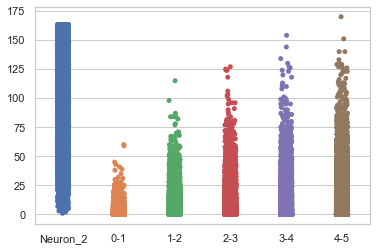

In [37]:
# Plot dist_data1 in a strip plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.stripplot(data=df1.drop("Neuron_1", axis=1)) #, jitter=True
# ax.set(ylim=ylims)
plt.show()

In [41]:
# Convert Pandas dataframes to feather files
# This can help us access the dataframes outside of this program for further analysis
import pyarrow
# df.reset_index(drop=True).to_feather("data_frame.feather")
# df1.reset_index(drop=True).to_feather("data_frame1.feather")
# df3.reset_index(drop=True).to_feather("data_frame3.feather")
# df4.reset_index(drop=True).to_feather("data_frame4.feather")